# Sobol Sensitivity Indices for the BTD Model

## Setup packages.

In [329]:
require(data.table)
require(magrittr)
require(rpart)
require(sensitivity)
require(SobolSequence)

require(ggplot2)

Loading required package: rpart


## Design experiment.

### Load input ranges.

In [2]:
z.ranges <- fread("input-ranges-si.tsv")
z.ranges %>% dim

[1] 32  9

In [3]:
z.ranges %>% summary

   Variable            Units               Type           Model Minimum   
 Length:32          Length:32          Length:32          Min.   :  0.00  
 Class :character   Class :character   Class :character   1st Qu.:  0.00  
 Mode  :character   Mode  :character   Mode  :character   Median :  0.01  
                                                          Mean   : 17.89  
                                                          3rd Qu.:  1.00  
                                                          Max.   :168.00  
 Model Maximum      Model Default       Sensitivity Minimum Sensitivity Maximum
 Length:32          Min.   :        0   Min.   :        0   Min.   :0.000e+00  
 Class :character   1st Qu.:        0   1st Qu.:        0   1st Qu.:3.000e+00  
 Mode  :character   Median :        1   Median :        0   Median :1.400e+01  
                    Mean   : 12547769   Mean   :  3764340   Mean   :5.865e+07  
                    3rd Qu.:     1664   3rd Qu.:      512   3rd Qu.:1.058e+

### Experiment based on Sobol sequences.

In [4]:
n <- 200
k <- dim(z.ranges)[1]

In [5]:
z.design <- sobolSequence.points(2 * k, count = n)
colnames(z.design) <- c(z.ranges$Variable, z.ranges$Variable)
z.design %>% dim

[1] 200  64

In [6]:
write.table(z.design, file = "design-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

### Relate the design to the model's variables.

In [7]:
z.ab <- z.design
for (i in 1:k) {
    for (j in c(i, k + i)) {
        z.ab[, j] <- z.ranges[i, `Sensitivity Minimum`] * (1 - z.ab[, j]) +
                     z.ranges[i, `Sensitivity Maximum`] *      z.ab[, j]
        if (z.ranges[i, `Type`] %in% c("Integer", "Boolean"))
            z.ab[, j] <- round(z.ab[, j])
    }
}
z.inputs <- rbind(
    data.table(Matrix = "A", Index = 0, z.ab[, 1:k    ]),
    data.table(Matrix = "B", Index = 0, z.ab[, 1:k + k])    
)
for (i in 1:k) {
    z.c <- z.ab[, 1:k + k]
    z.c[, i] <- z.ab[, i]
    z.inputs <- rbind(
        z.inputs,
        data.table(Matrix = "C", Index = i, z.c)
    )
}
z.inputs <- cbind(
    Run = 1:dim(z.inputs)[1],
    z.inputs
)
z.inputs %>% dim

[1] 6800   35

In [8]:
z.inputs %>% summary

      Run          Matrix              Index       aversion to NPV deviation
 Min.   :   1   Length:6800        Min.   : 0.00   Min.   :0.0600           
 1st Qu.:1701   Class :character   1st Qu.: 7.00   1st Qu.:0.7075           
 Median :3400   Mode  :character   Median :15.50   Median :1.3549           
 Mean   :3400                      Mean   :15.53   Mean   :1.3537           
 3rd Qu.:5100                      3rd Qu.:24.00   3rd Qu.:2.0024           
 Max.   :6800                      Max.   :32.00   Max.   :2.6498           
 base external investor ask rate bioproduct long term price
 Min.   : 2.400                  Min.   :1500              
 1st Qu.: 6.384                  1st Qu.:3368              
 Median :10.369                  Median :5236              
 Mean   :10.364                  Mean   :5224              
 3rd Qu.:14.353                  3rd Qu.:7103              
 Max.   :18.337                  Max.   :8971              
 bioproduct performance advantage commerc

In [9]:
write.table(z.inputs[, 1:3], file="indices-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

In [10]:
write.table(z.inputs[, -(2:3)], file="inputs-si.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

## Analyze results.

### Read files.

#### Read design.

In [13]:
z.design <- fread("design-si.tsv")
z.design %>% dim

[1] 200  64

In [58]:
n <- dim(z.design)[1]
k <- dim(z.design)[2] / 2

#### Read inputs.

In [15]:
z.inputs <- fread("inputs-si.tsv")
z.inputs %>% dim

[1] 6800   33

#### Read outputs.

In [372]:
z.outputs <- rbind(
    fread("outputs-si-direct-niche.tsv"     )[, `:=`(Replacement="Direct"    , Scale="Niche"    )],
    fread("outputs-si-direct-commodity.tsv" )[, `:=`(Replacement="Direct"    , Scale="Commodity")],
    fread("outputs-si-perfadv-niche.tsv"    )[, `:=`(Replacement="Advantaged", Scale="Niche"    )],
    fread("outputs-si-perfadv-commodity.tsv")[, `:=`(Replacement="Advantaged", Scale="Commodity")]
)[order(Replacement, Scale, Run, Time)]
z.outputs <- z.outputs[, c(52:53, 1:51)]
z.outputs %>% summary

 Replacement           Scale                Run            Time     
 Length:217600      Length:217600      Min.   :   1   Min.   :2015  
 Class :character   Class :character   1st Qu.:1701   1st Qu.:2024  
 Mode  :character   Mode  :character   Median :3400   Median :2032  
                                       Mean   :3400   Mean   :2032  
                                       3rd Qu.:5100   3rd Qu.:2041  
                                       Max.   :6800   Max.   :2050  
 bioproduct market share mass current market size economic
 Min.   :0.000021             Min.   :1.440e+08           
 1st Qu.:0.003422             1st Qu.:2.065e+10           
 Median :0.011078             Median :4.598e+10           
 Mean   :0.084200             Mean   :1.451e+11           
 3rd Qu.:0.030125             3rd Qu.:1.254e+11           
 Max.   :4.452280             Max.   :1.272e+13           
 current market size mass long term market share long term market value
 Min.   :8.468e+04        Min.  

In [373]:
z.outputs.long <- melt(
    z.outputs,
    id.vars=c("Replacement", "Scale", "Run", "Time"),
    variable.name="Variable",
    value.name="Value"
)[, Case:=paste(Replacement, Scale)]

Warning message in melt.data.table(z.outputs, id.vars = c("Replacement", "Scale", :
"'measure.vars' [bioproduct market share mass, current market size economic, current market size mass, long term market share, ...] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion."

In [374]:
write.table(z.outputs     , file = "outputs-si-wide.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)
write.table(z.outputs.long, file = "outputs-si-long.tsv", row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

#### Just use the final year.

In [54]:
for (i in 1:5)
    for (j in 1:5)
        if (i < j)
            print(paste(i, j, sum(as.matrix(z.outputs[[i]]) - as.matrix(z.outputs[[j]]))))

[1] "1 2 -2928473544327266"
[1] "1 3 0"
[1] "1 4 -2929504645261694"
[1] "1 5 51258989985645.2"
[1] "2 3 2928473544327266"
[1] "2 4 -1031100934428.6"
[1] "2 5 2979732534312910"
[1] "3 4 -2929504645261694"
[1] "3 5 51258989985645.2"
[1] "4 5 2980763635247340"


In [257]:
sensitivityIndices <- function(inputs, outputs) {
    result <- NULL
    for (i in 3:ncol(outputs)) {
        ya <-        as.matrix(outputs[1:n              , i, with=FALSE])
        yb <-        as.matrix(outputs[1:n + n          , i, with=FALSE])
        yc <- matrix(as.matrix(outputs[(2*n+1):((k+2)*n), i, with=FALSE]), nrow=n, byrow=TRUE)
        f0 <- mean(ya)
        s1 <-     ((t(yc) %*% ya) / n - f0^2) / as.numeric((t(ya) %*% ya) / n - f0^2)
        ta <- 1 - ((t(yc) %*% yb) / n - f0^2) / as.numeric((t(ya) %*% ya) / n - f0^2)
        result <- rbind(
            result,
            data.table(
                Input  = colnames(inputs)[1:k + 1],
                Output = colnames(outputs)[i]     ,
                S      = as.vector(s1)            ,
                T      = as.vector(ta)
            )
        )
    }
    result
}

In [267]:
z.sens <- sensitivityIndices(z.inputs, z.outputs[[1]][Time == 2050])

In [317]:
z.sens[, .(Input, Output, S=mapply(function(x) max(0, min(1, x)), S))] %>% summary

    Input              Output                S          
 Length:1568        Length:1568        Min.   :0.00000  
 Class :character   Class :character   1st Qu.:0.00000  
 Mode  :character   Mode  :character   Median :0.00000  
                                       Mean   :0.09126  
                                       3rd Qu.:0.06702  
                                       Max.   :1.00000  
                                       NA's   :160      

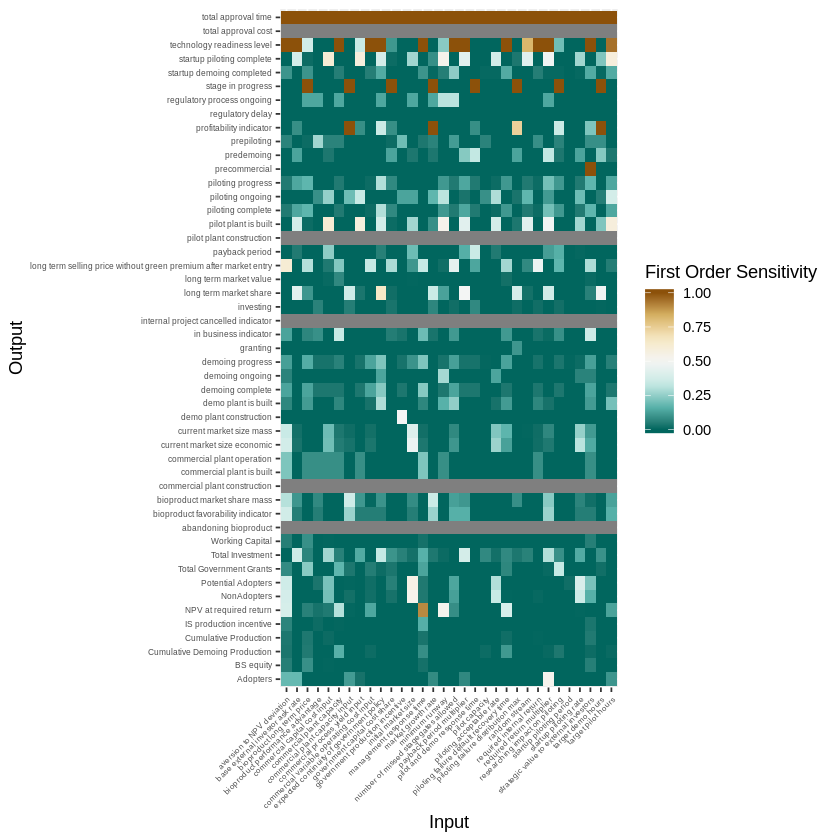

In [320]:
ggplot(
    z.sens[, .(Input, Output, `First Order Sensitivity`=mapply(function(x) max(0, min(1, x)), S))],
    aes(x=Input, y=Output, fill=`First Order Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(type="div", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

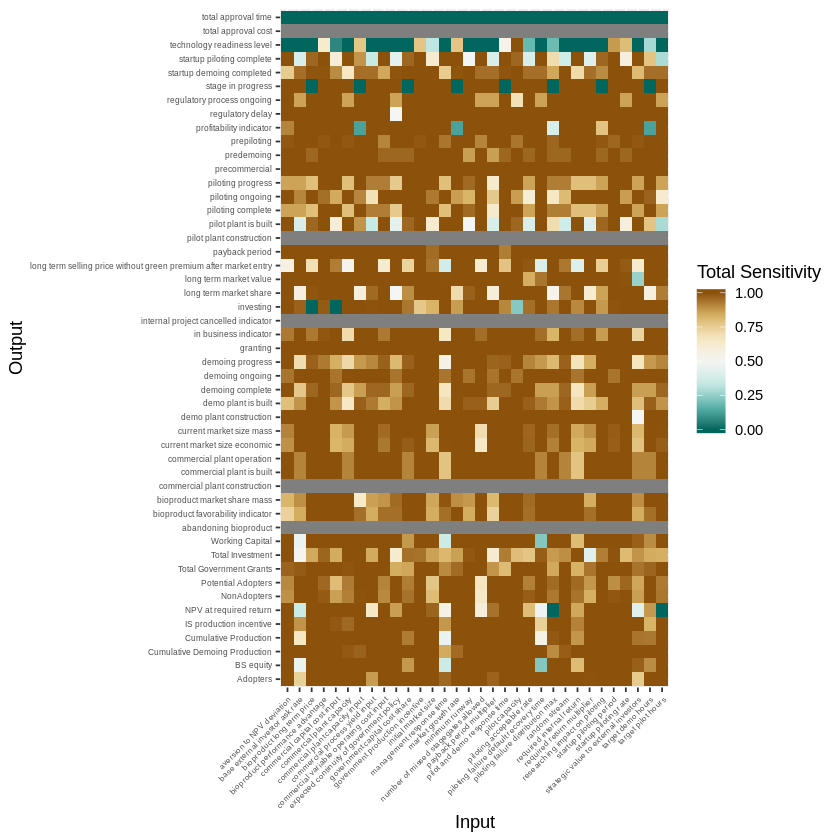

In [322]:
ggplot(
    z.sens[, .(Input, Output, `Total Sensitivity`=mapply(function(x) max(0, min(1, x)), T))],
    aes(x=Input, y=Output, fill=`Total Sensitivity`)
) +
    geom_tile() +
    scale_fill_distiller(type="div", limits=c(0, 1)) +
    theme(
        axis.text=element_text(size=5),
        axis.text.x = element_text(angle = 45, hjust=1)
    )

In [280]:
z.sens.boot <- z.sens
for (i in 1:100)
    z.sens.boot <- rbind(
        z.sens.boot,
        sensitivityIndices(z.inputs, z.outputs[[1]][Time == 2050][sample(.N, .N, replace=TRUE)])
    )
z.sens.boot %>% dim

[1] 158368      4

In [327]:
z.sens[, .(S=mean(S, na.rm=TRUE), T=mean(T, na.rm=TRUE)), by=.(Input)]

Input                                    S             T        
1  aversion to NPV deviation                 0.1002446247 0.9578673
2  base external investor ask rate           0.0654465361 0.8105870
3  bioproduct long term price                0.1256554037 0.8791017
4  bioproduct performance advantage         -0.0401510695 1.0570390
5  commercial capital cost input             0.0529850901 0.9481462
6  commercial plant capacity                 0.0157433233 0.9382908
7  commercial plant capacity input           0.0787680556 0.9111355
8  commercial process yield input           -0.0117861721 0.9829169
9  commercial variable operating cost input -0.0192826549 0.9752409
10 expected continuity of government policy  0.1424534627 0.8406893
11 government capital cost share             0.0770675998 0.9120127
12 government production incentive          -0.0726058096 1.0786866
13 initial market size                       0.0406023704 0.9803194
14 management response time                  0.0399810727 0.8613053
15 market growth rate                        0.1026670669 0.9075612
16 minimum runway                            0.0361520699 1.0147804
17 number of missed stagegates allowed       0.0383973624 0.9711689
18 payback period multiplier                 0.0843854034 0.8522971
19 pilot and demo response time              0.0557410139 0.9409758
20 pilot capacity                           -0.0581652768 1.0357101
21 piloting acceptable rate                  0.0132781351 0.9571867
22 piloting failure default recovery time   -0.0006553463 0.9509183
23 piloting failure distribution max         0.0815183339 0.8185424
24 random stream                            -0.0439969267 1.0029167
25 required internal return                  0.0077756310 0.8971234
26 required return multiplier                0.1330441037 0.8595822
27 researching impact on piloting            0.0853639829 0.9076104
28 startup piloting period                  -0.0966556001 1.0612466
29 startup piloting rate                     0.0089299600 1.0301940
30 strategic value to external investors     0.0767370021 0.8910102
31 target demo hours                         0.0991494614 0.8667529
32 target pilot hours                        0.0474195823 0.9210745

Warning message:
"Removed 15072 rows containing non-finite values (stat_boxplot)."

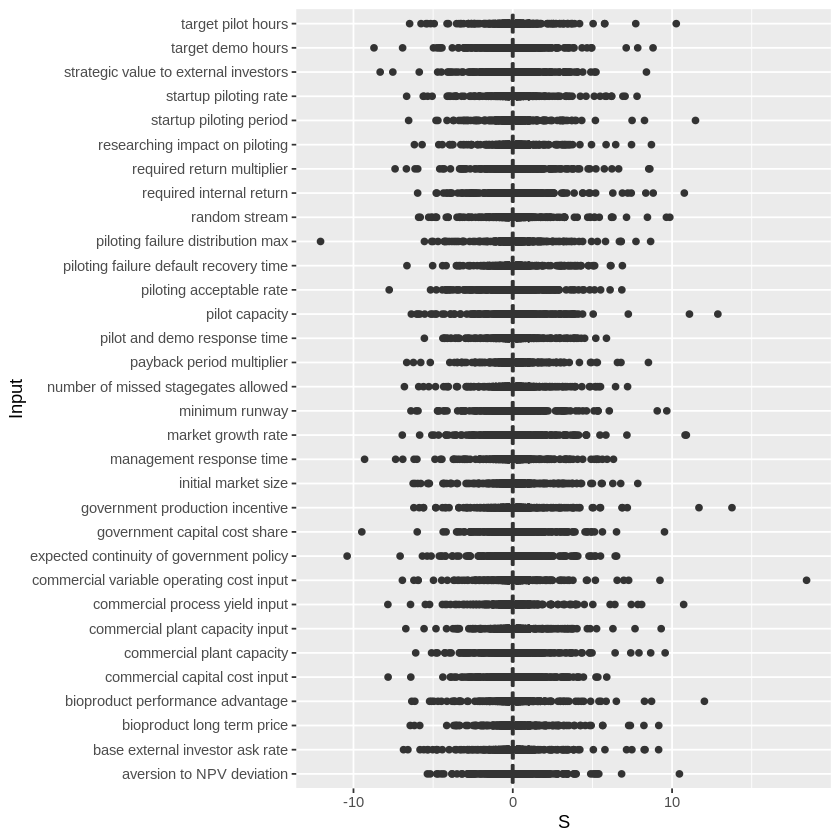

In [328]:
ggplot(z.sens.boot, aes(x=Input, y=S)) +
    geom_boxplot() +
    coord_flip()

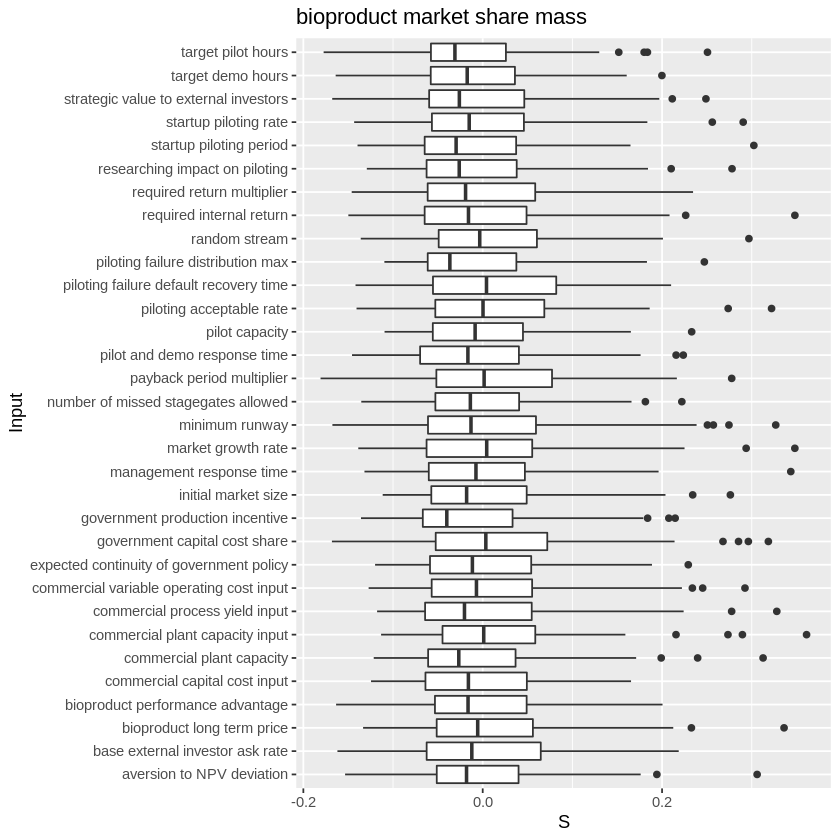

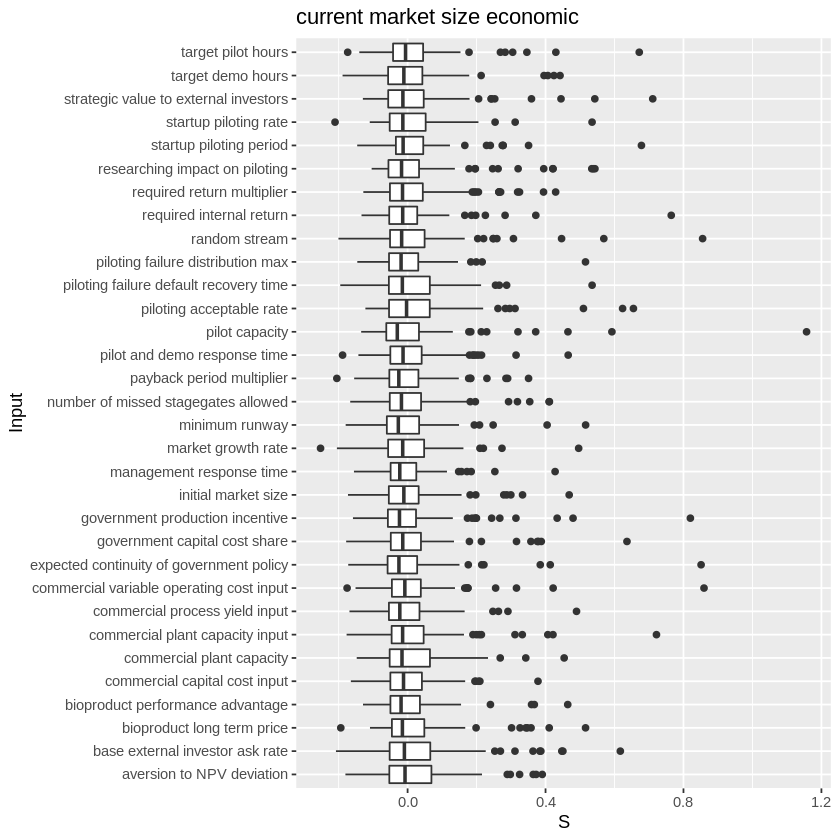

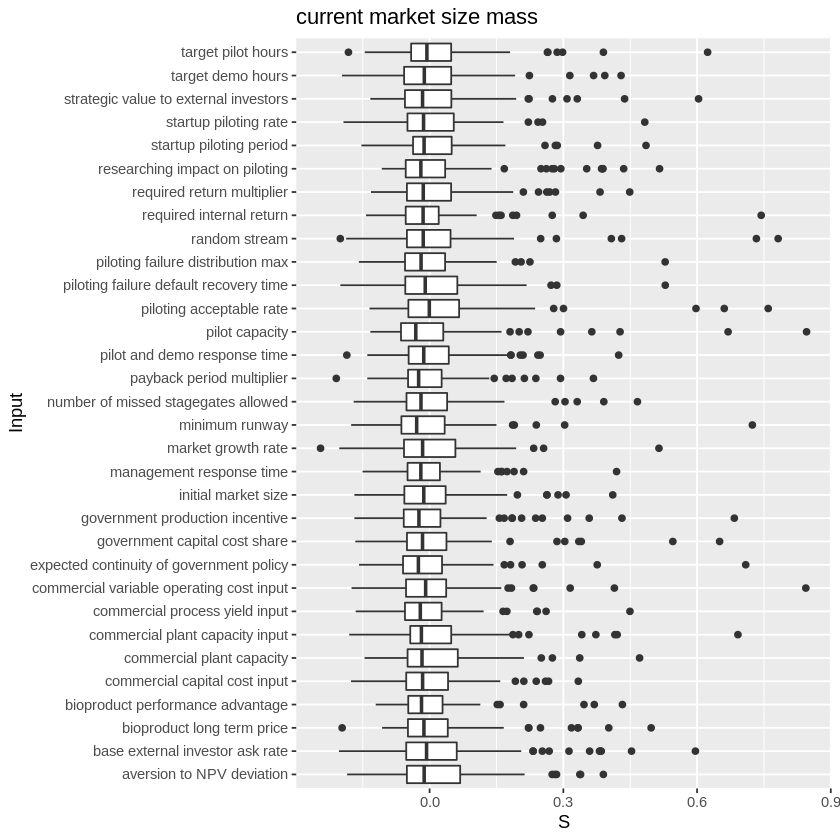

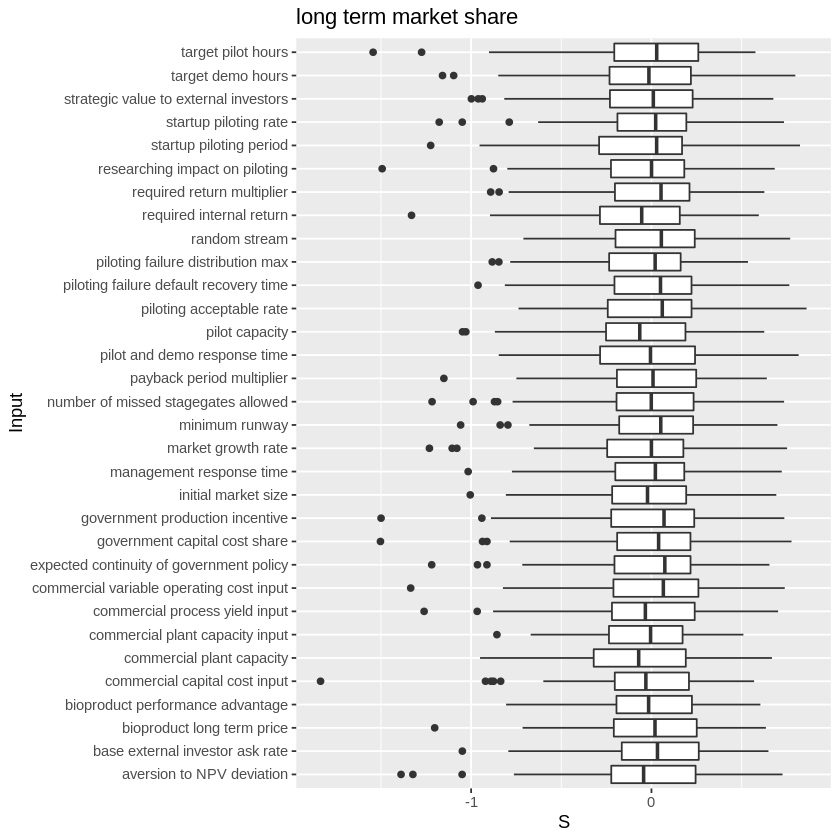

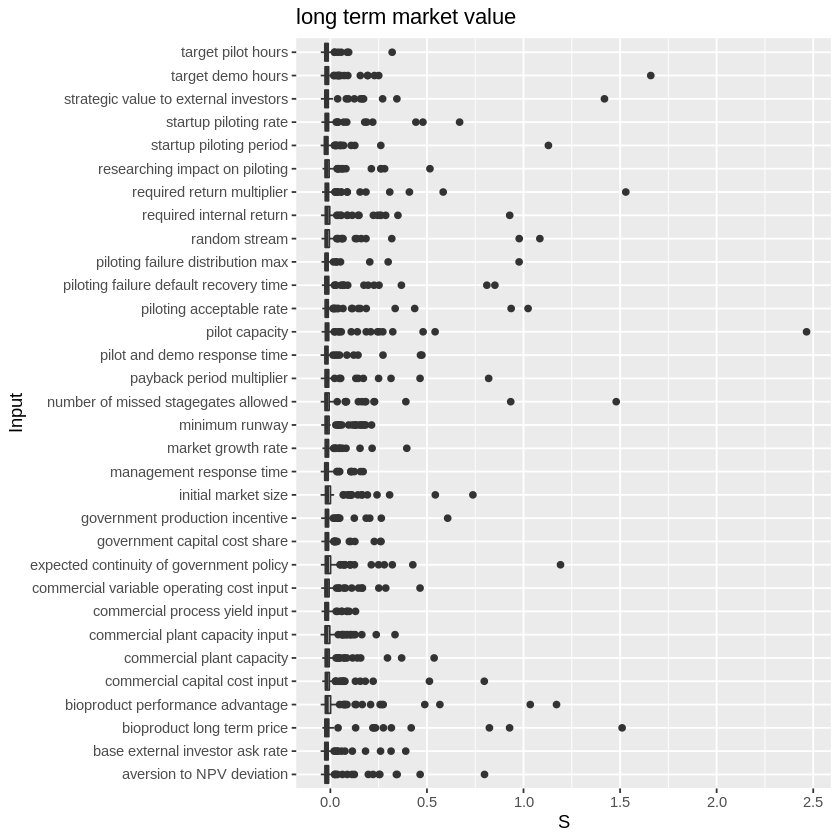

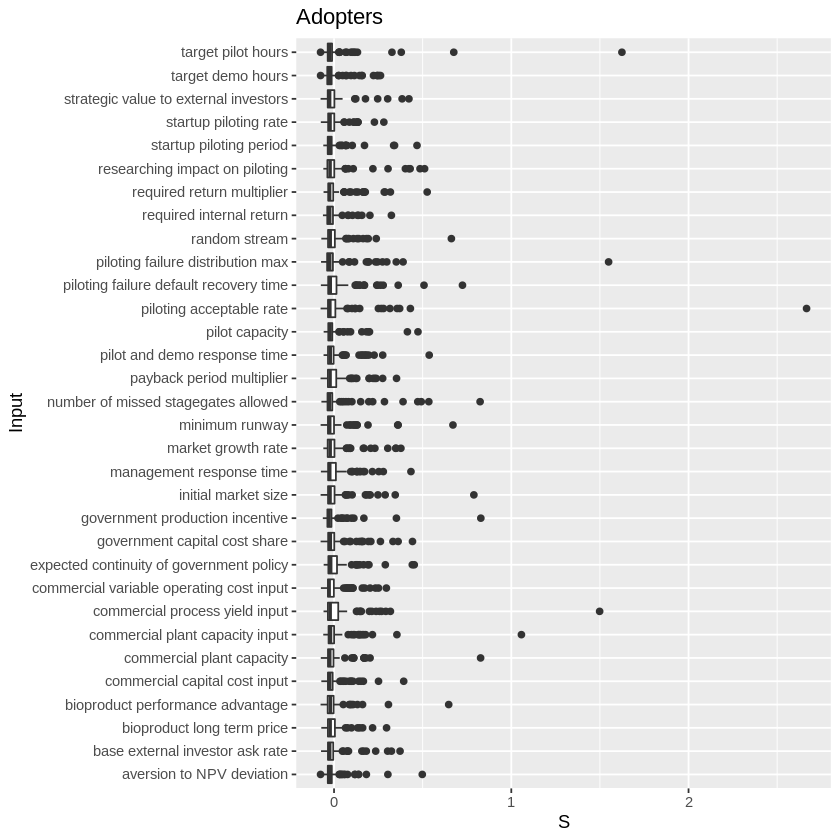

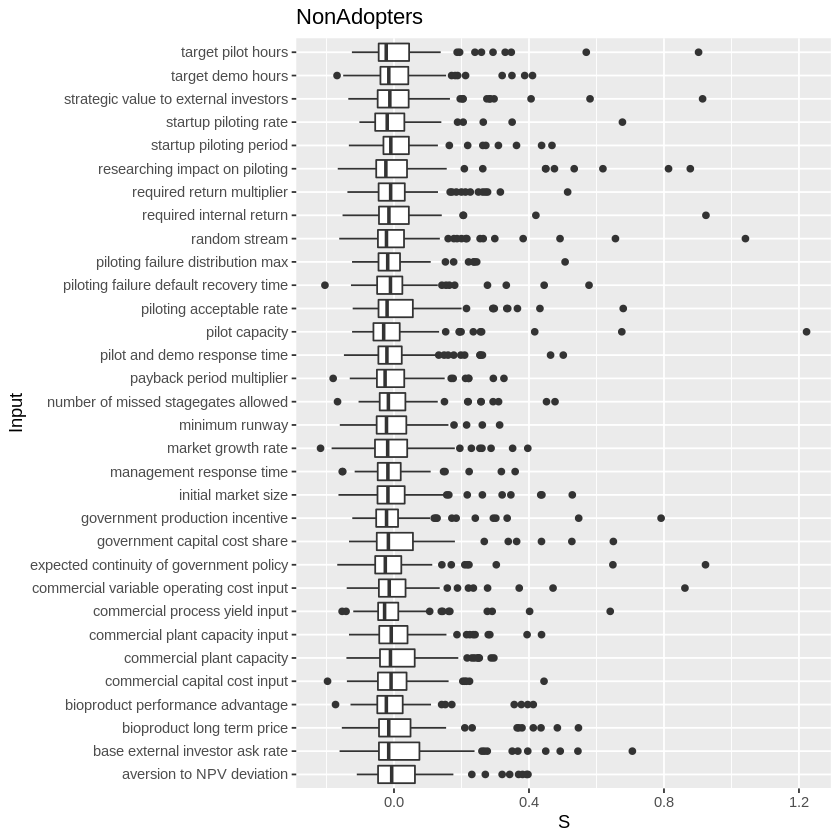

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

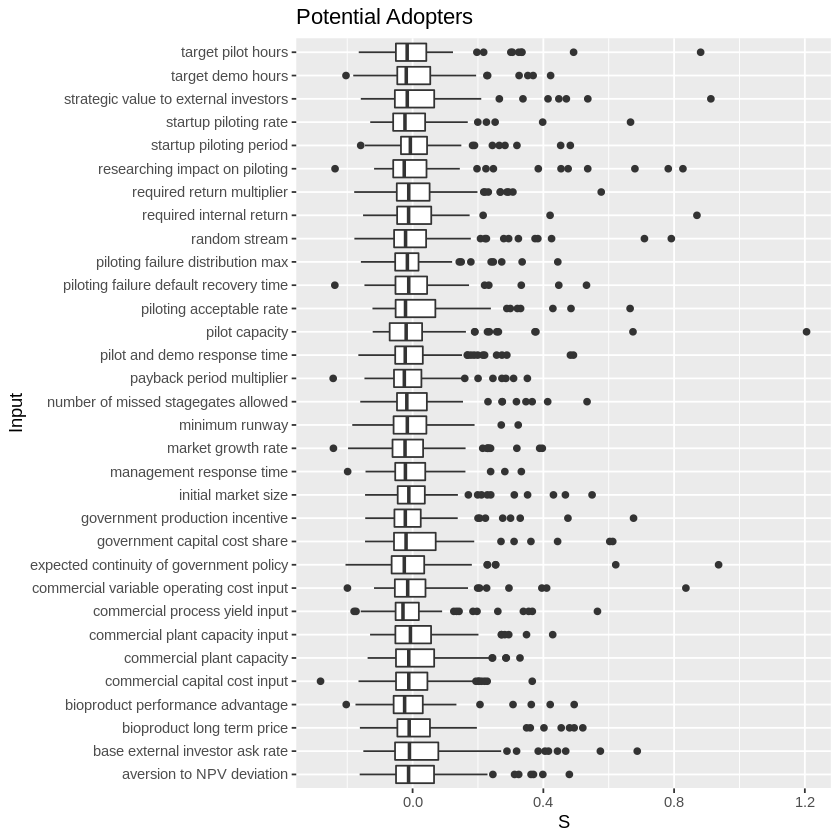

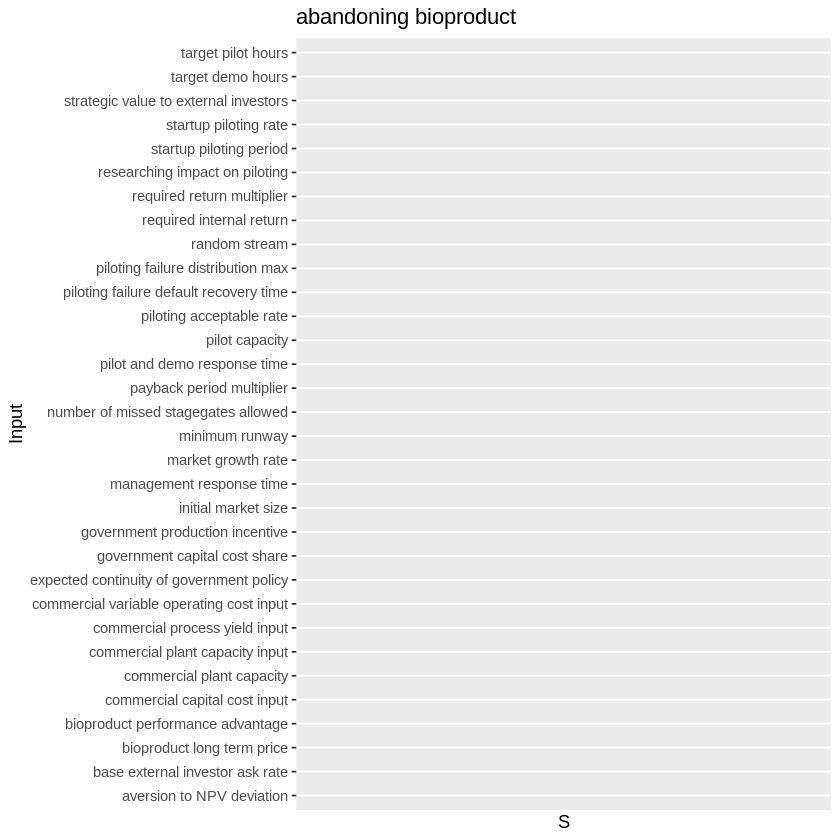

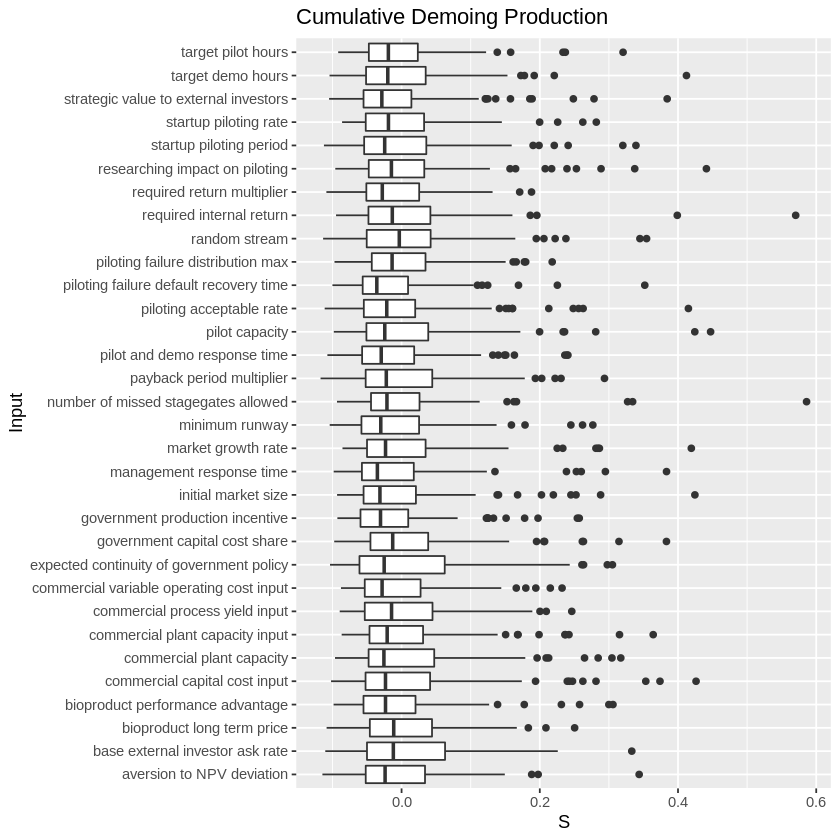

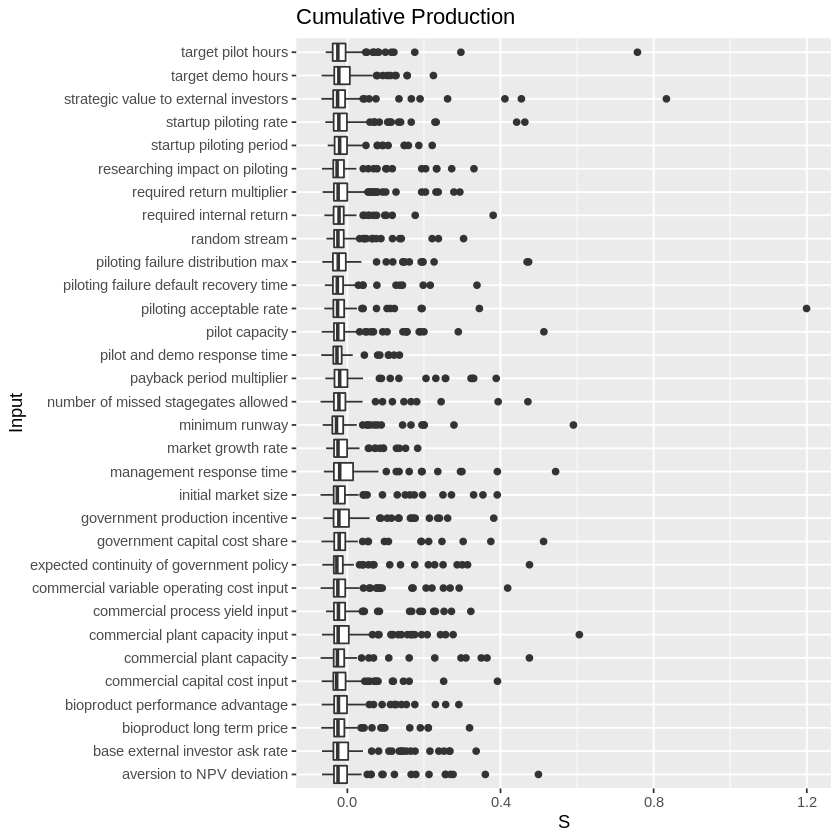

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

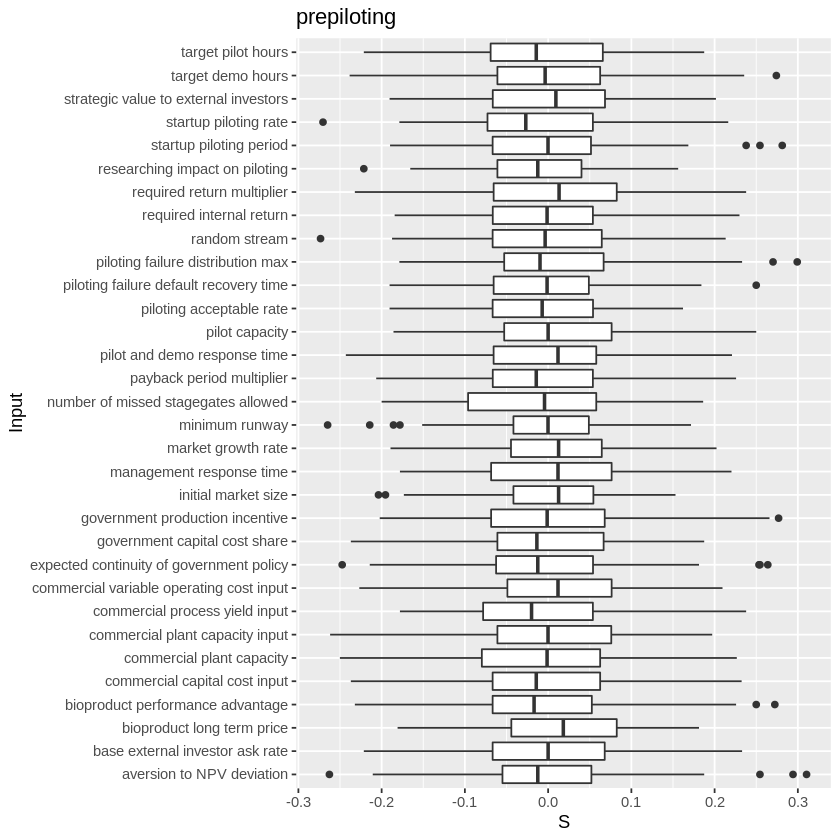

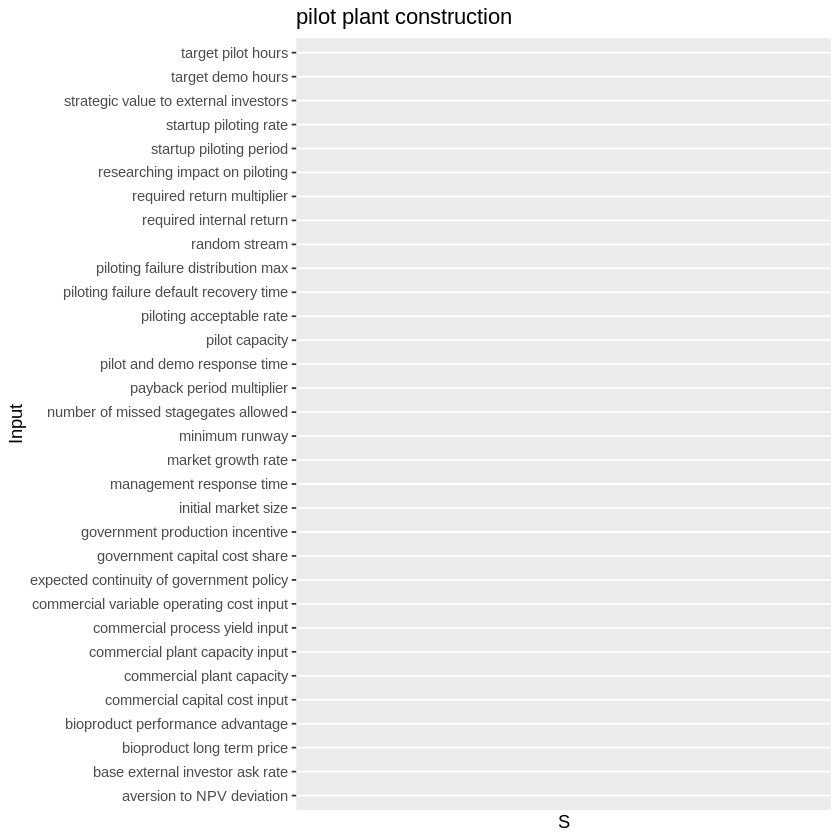

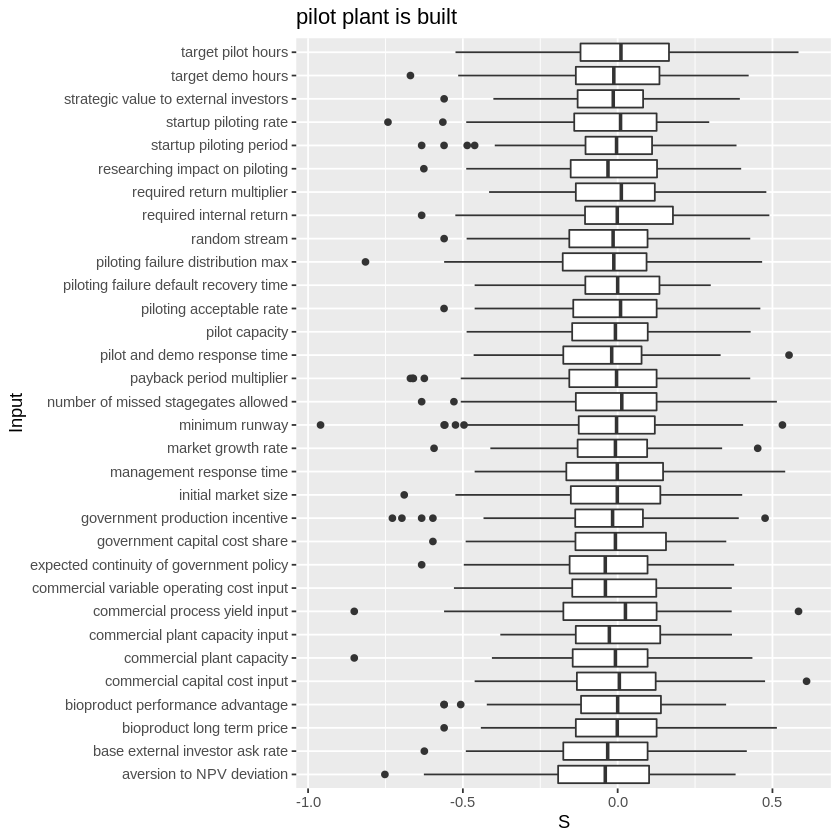

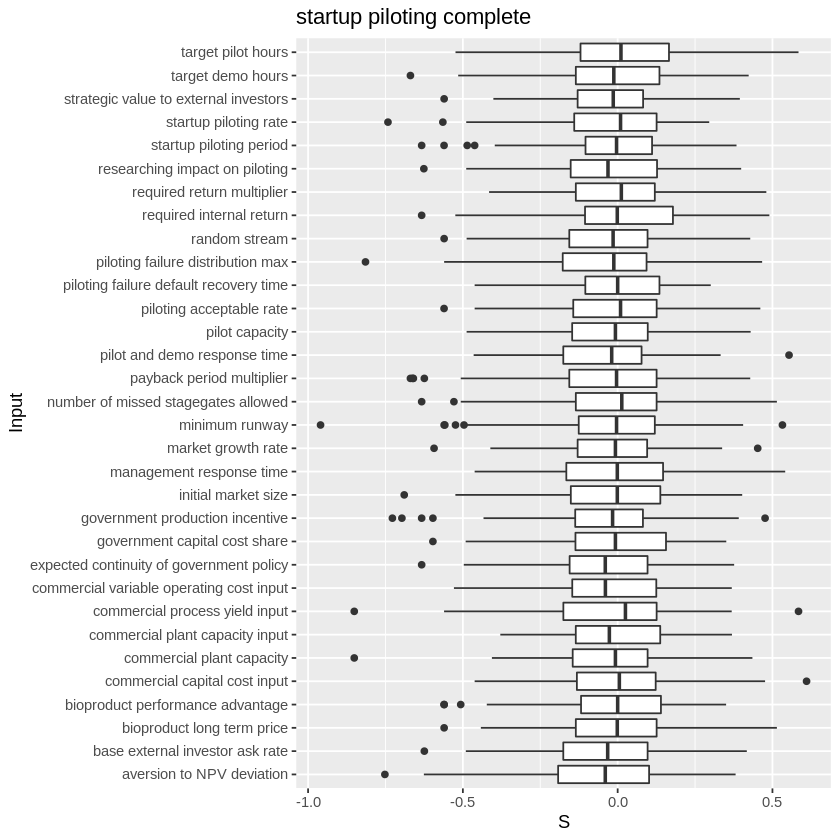

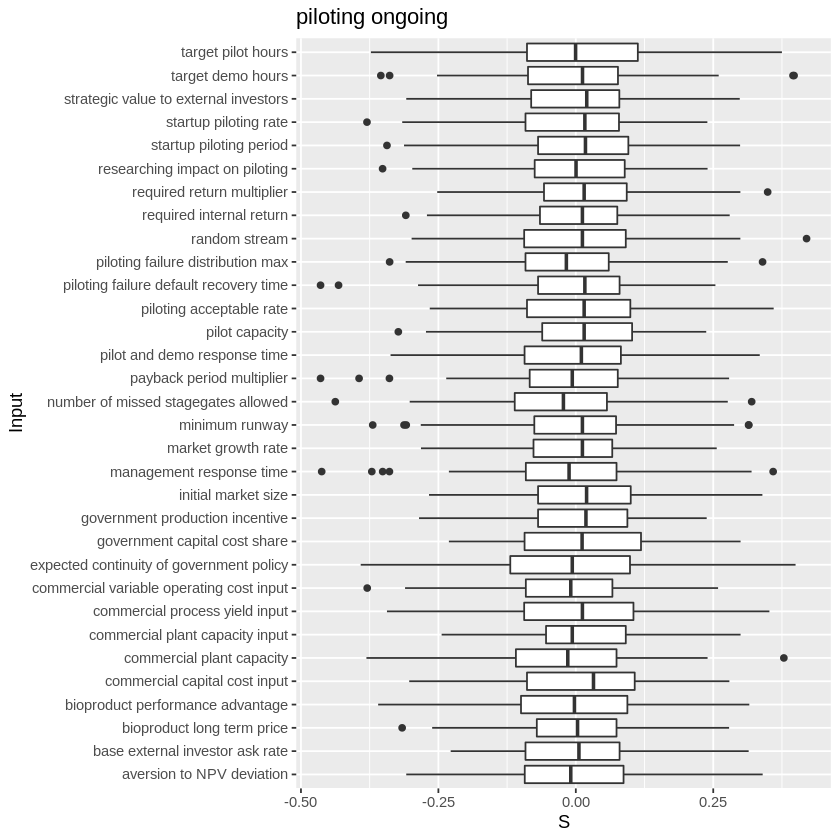

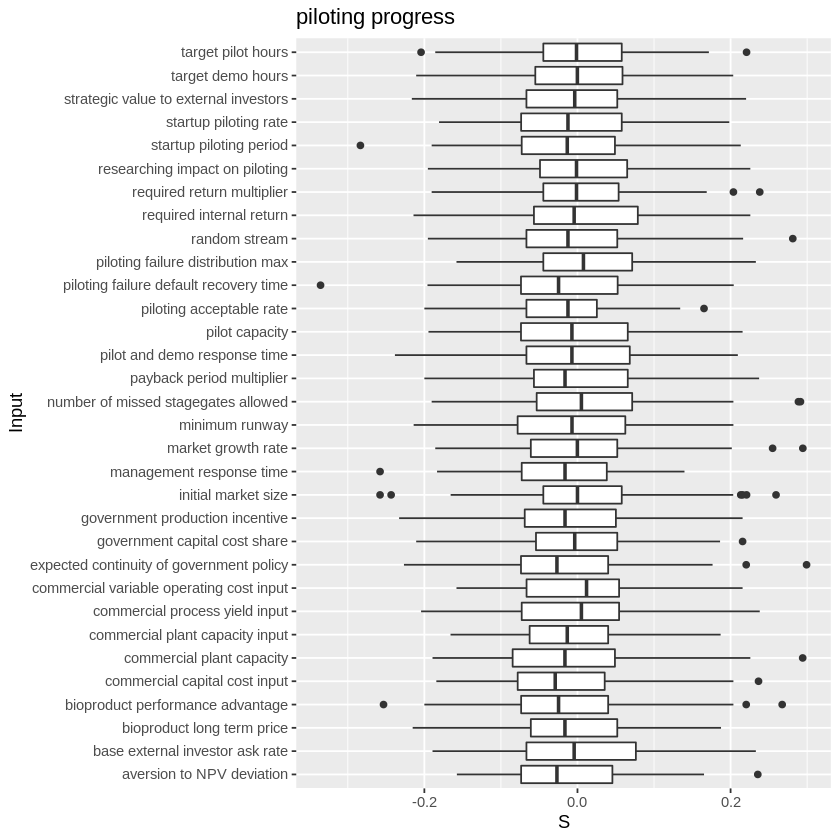

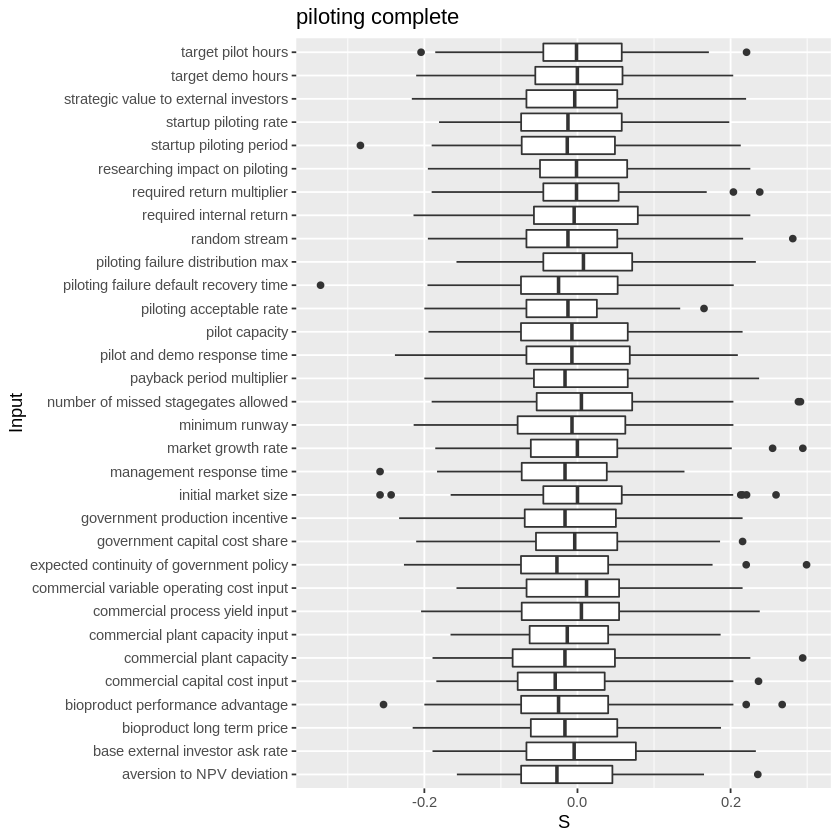

Warning message:
"Removed 224 rows containing non-finite values (stat_boxplot)."

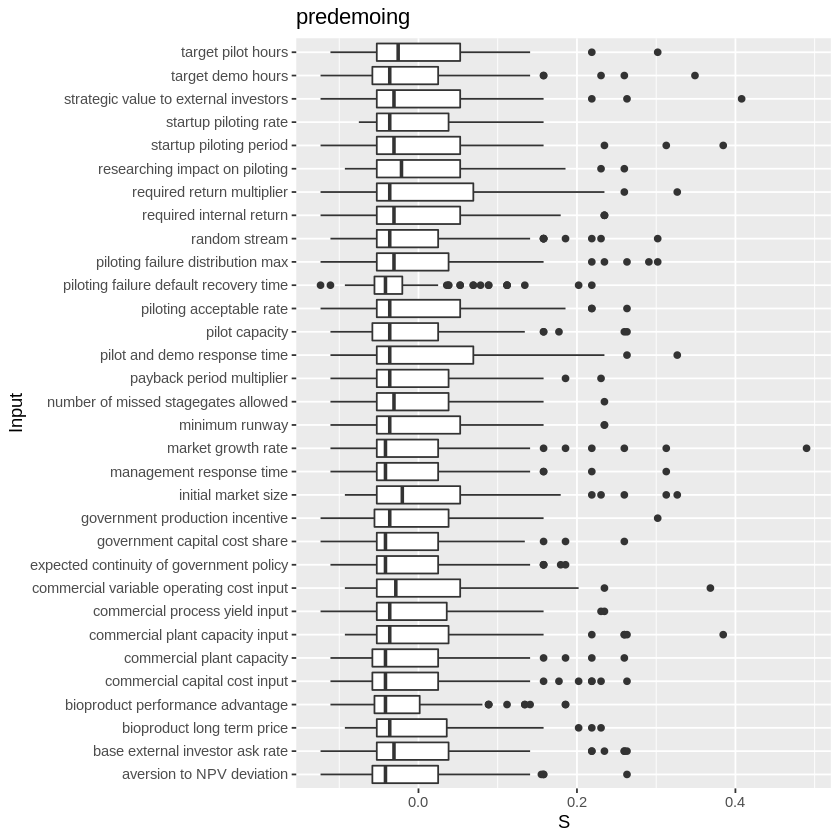

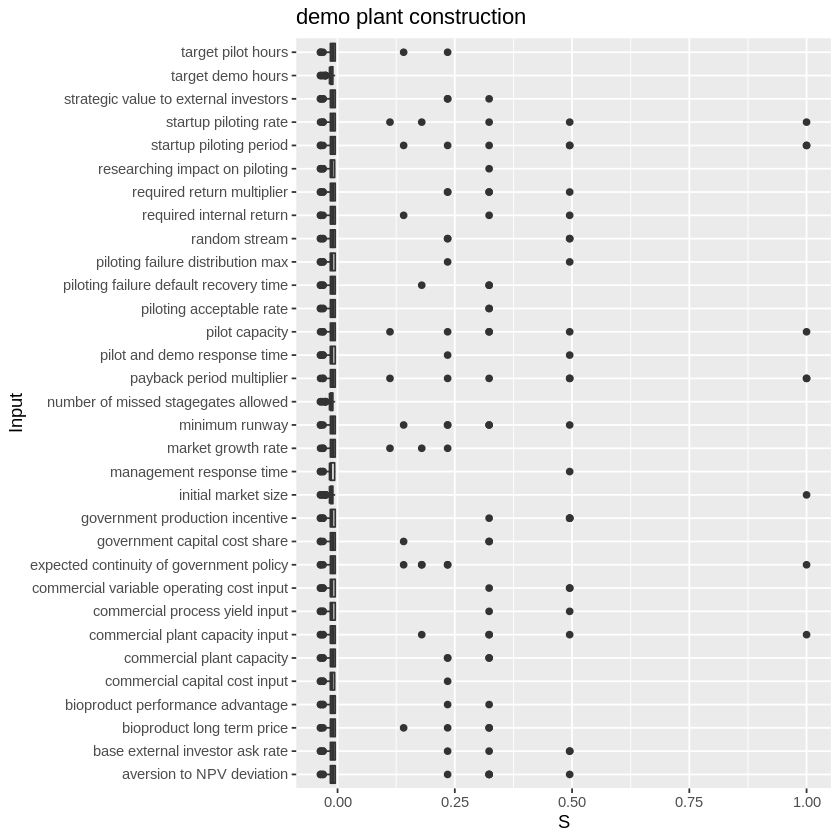

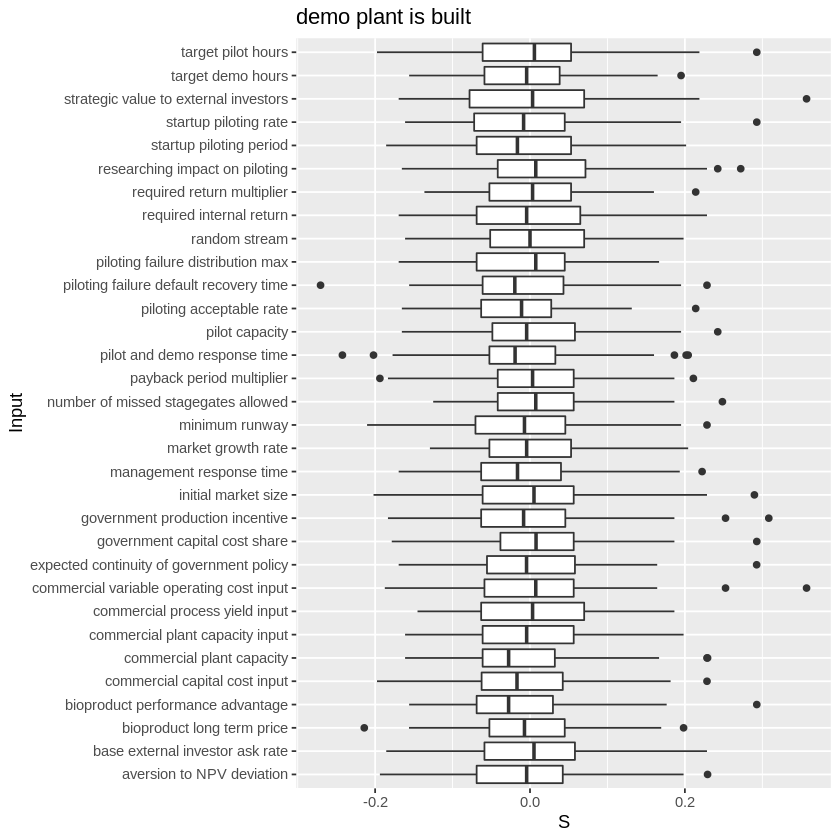

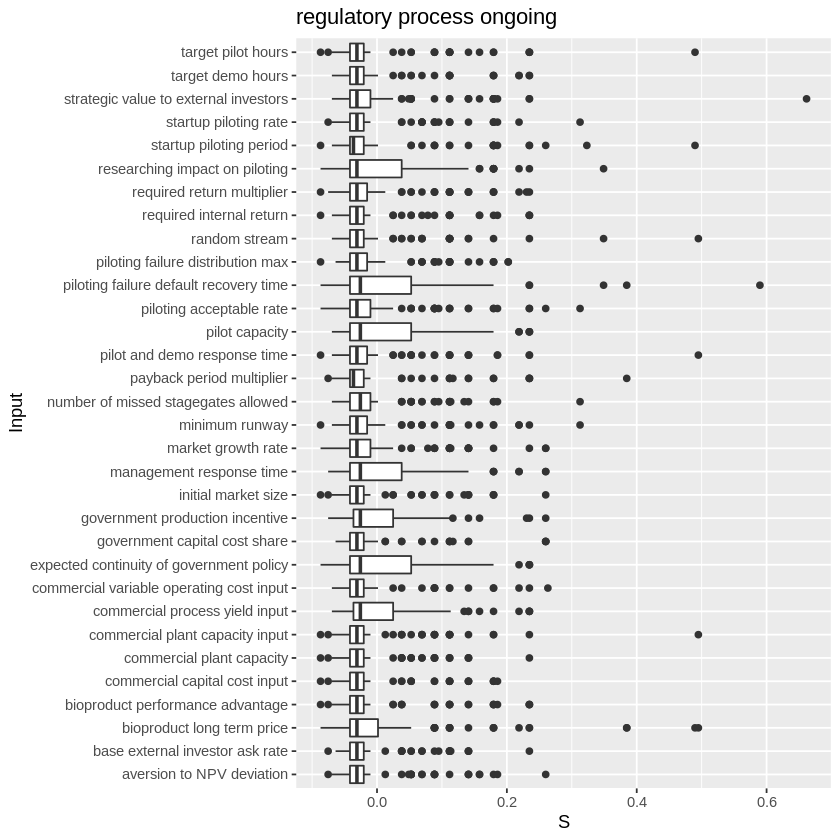

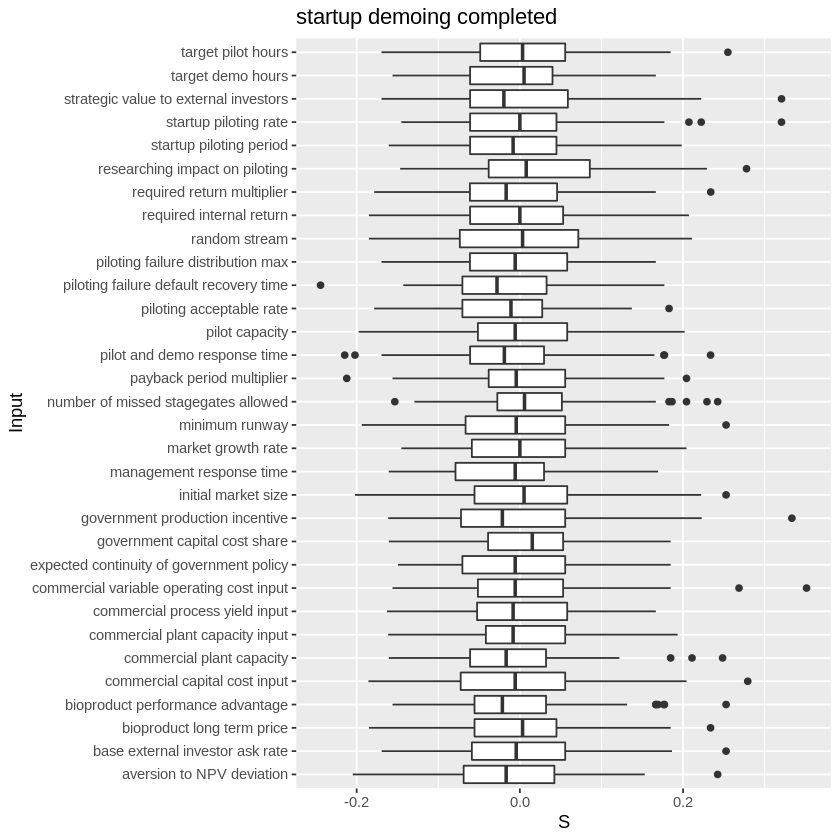

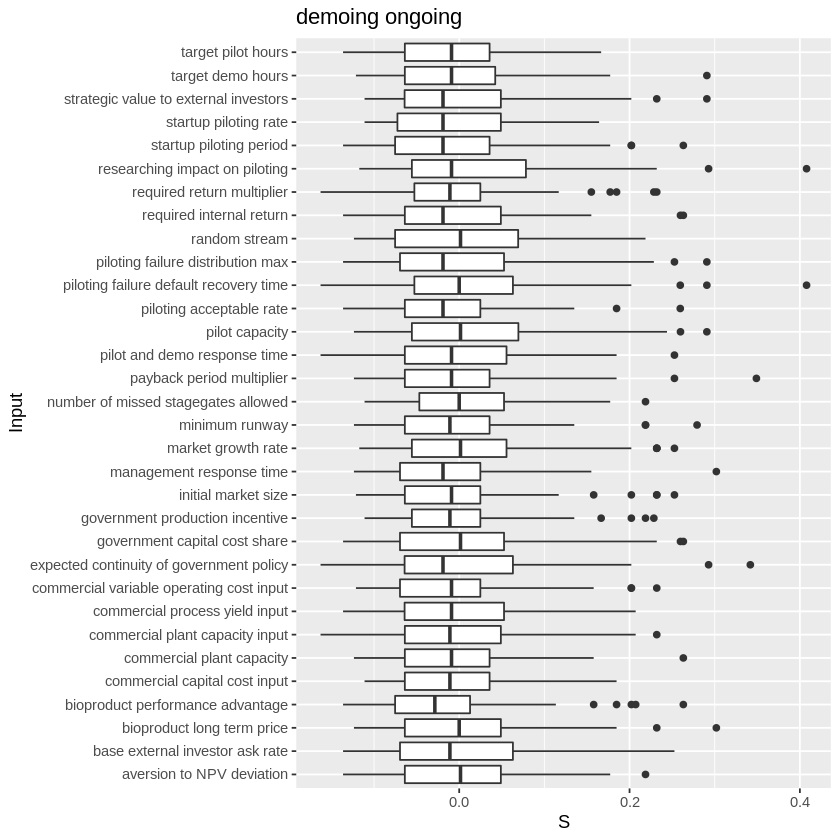

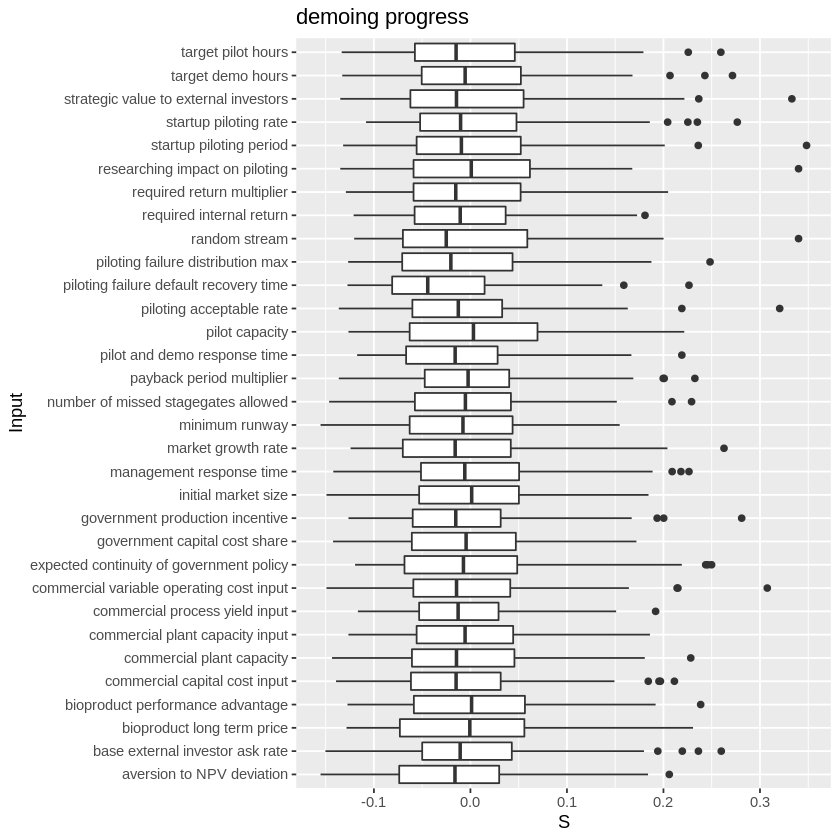

Warning message:
"Removed 864 rows containing non-finite values (stat_boxplot)."

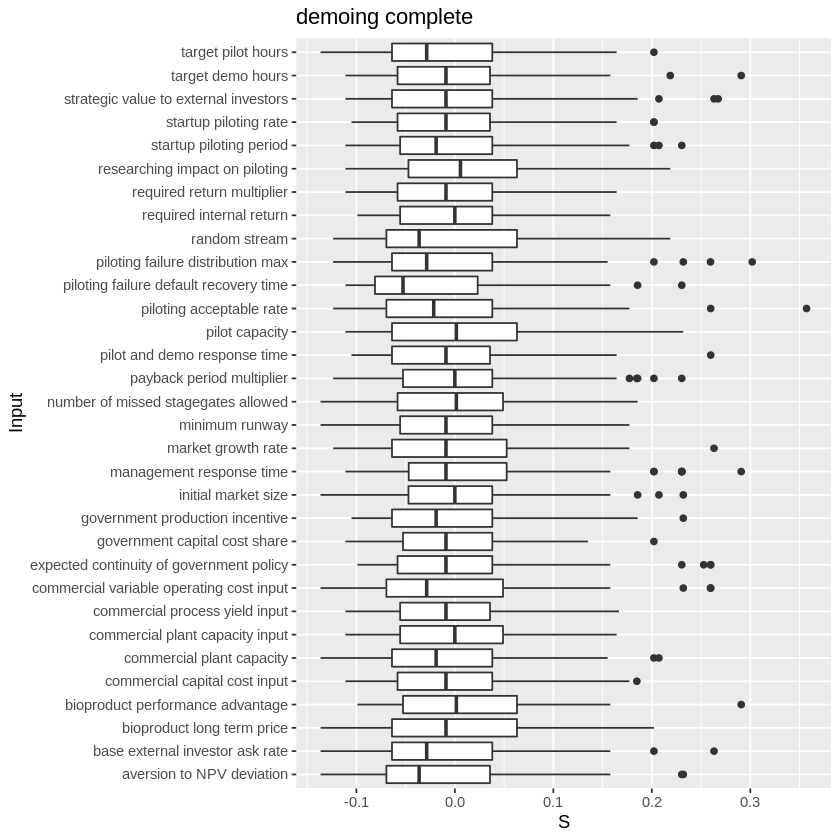

Warning message:
"Removed 96 rows containing non-finite values (stat_boxplot)."

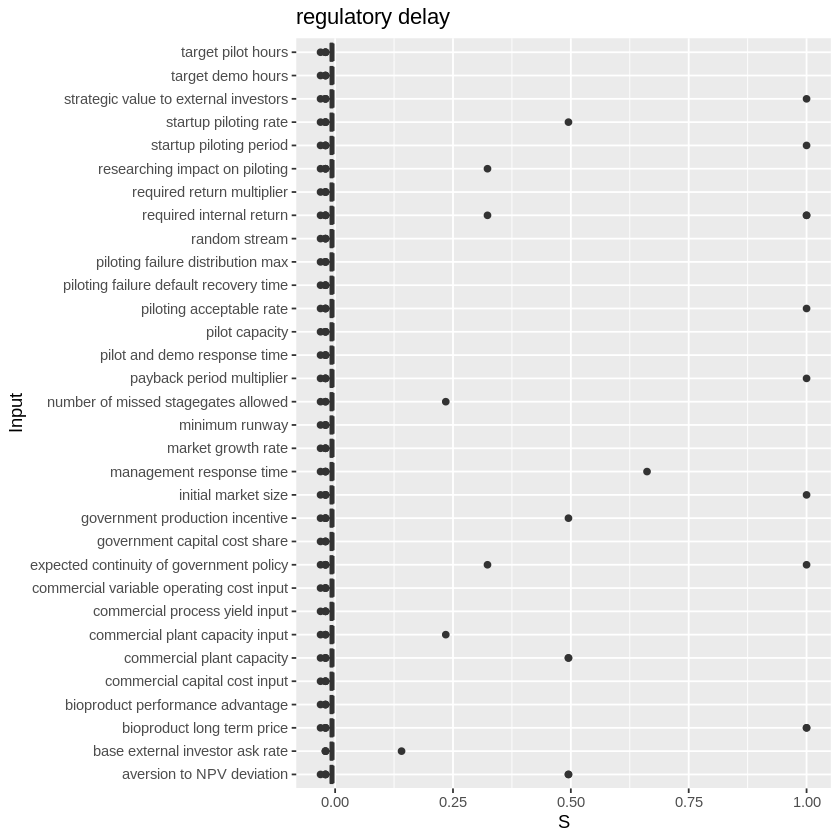

Warning message:
"Removed 960 rows containing non-finite values (stat_boxplot)."

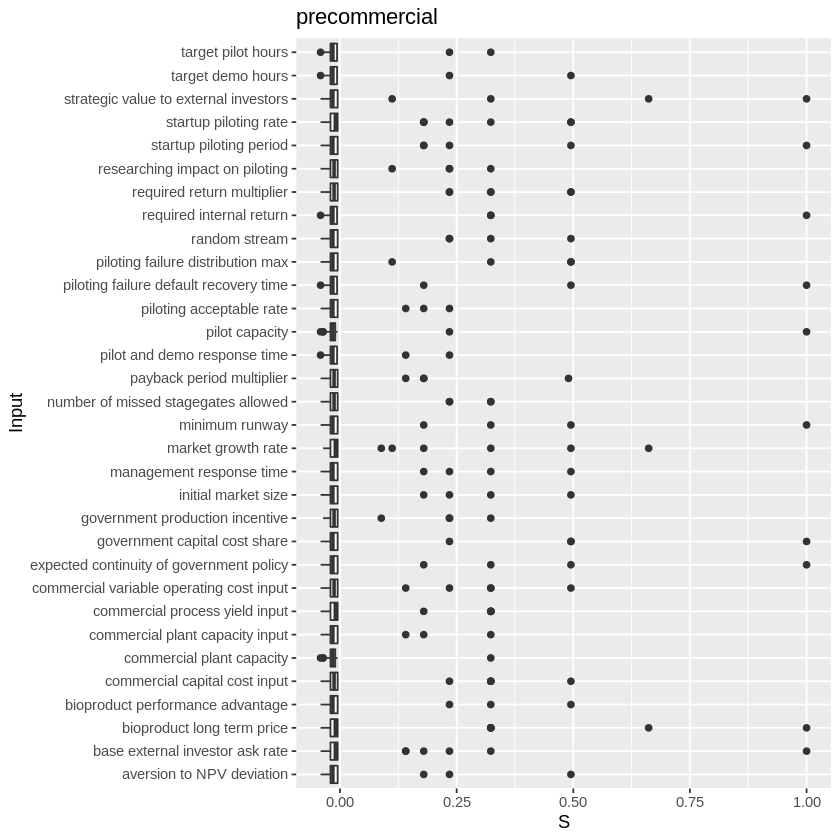

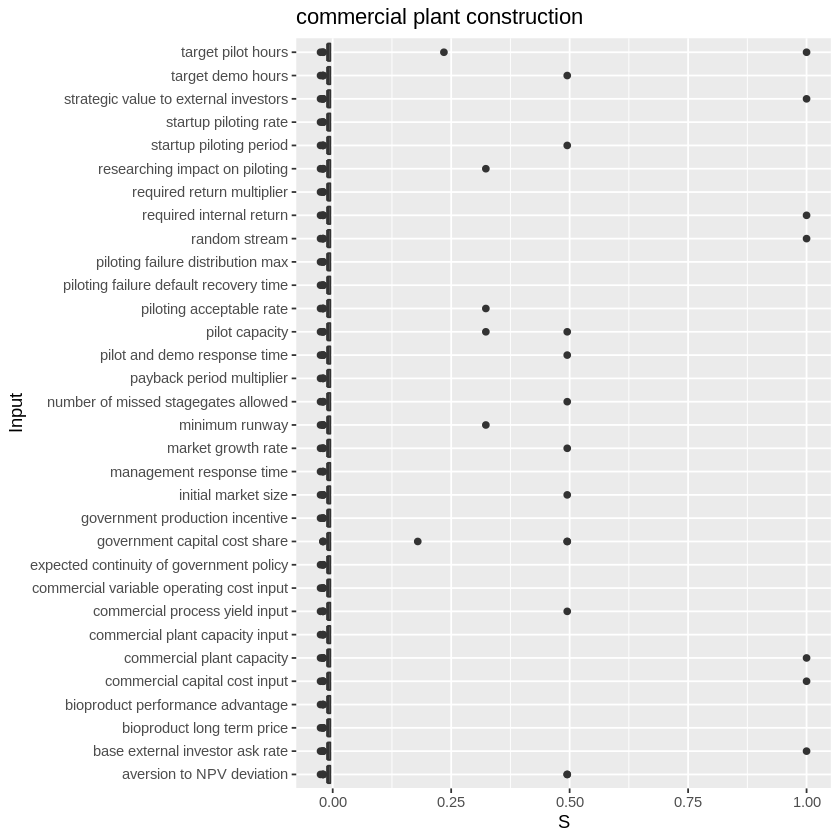

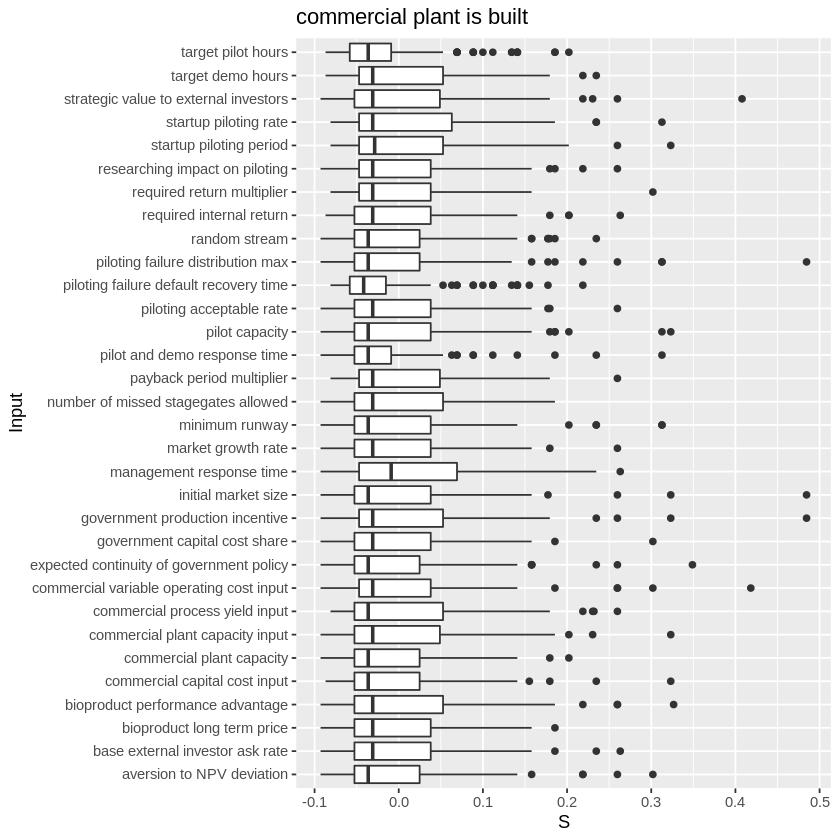

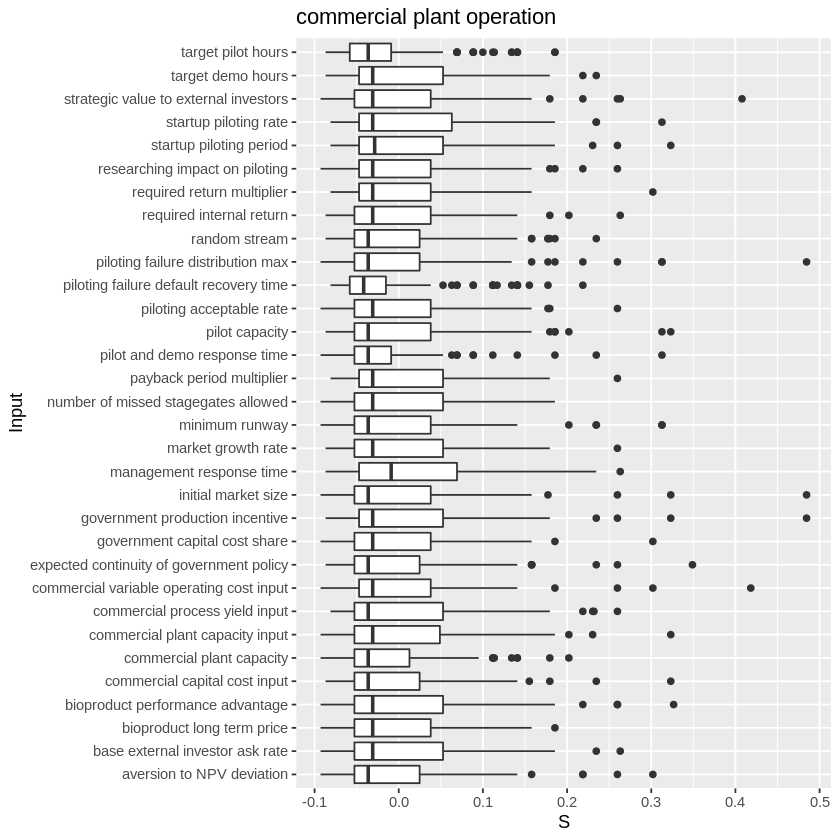

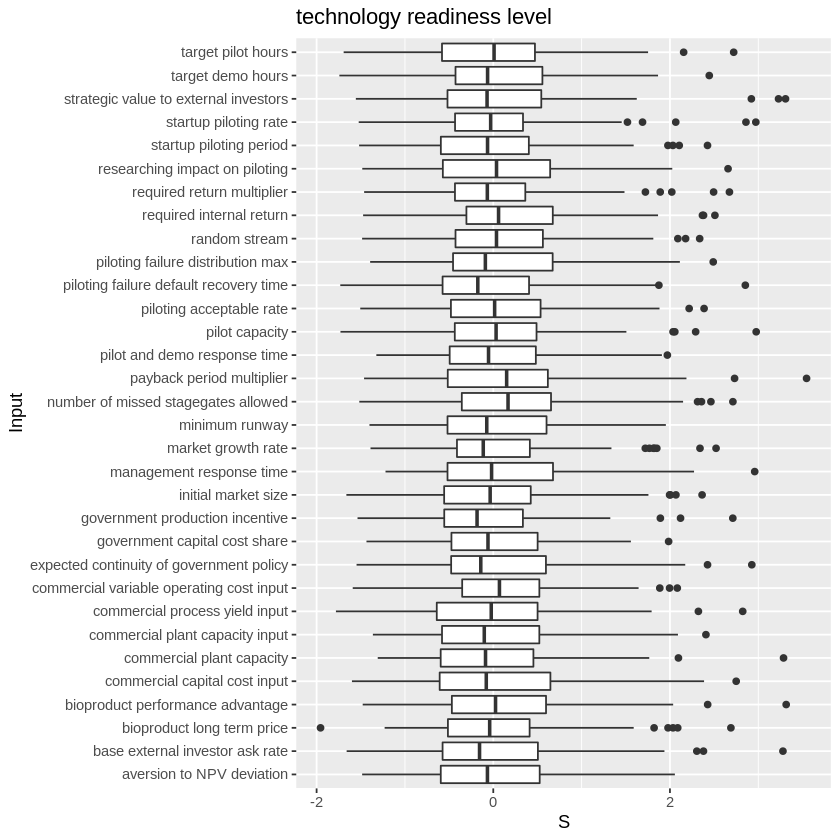

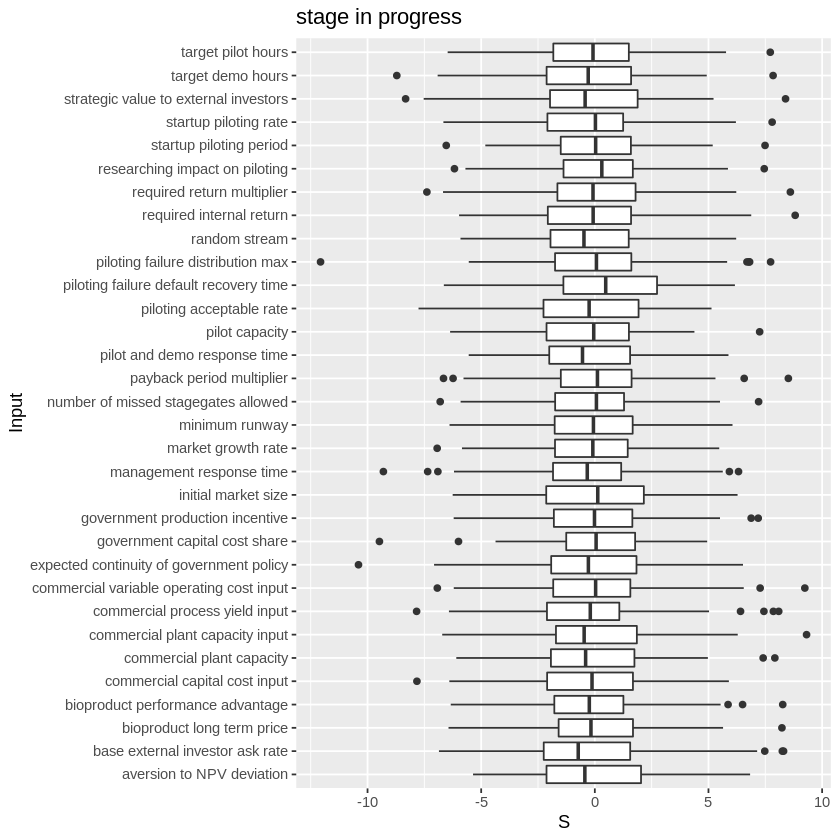

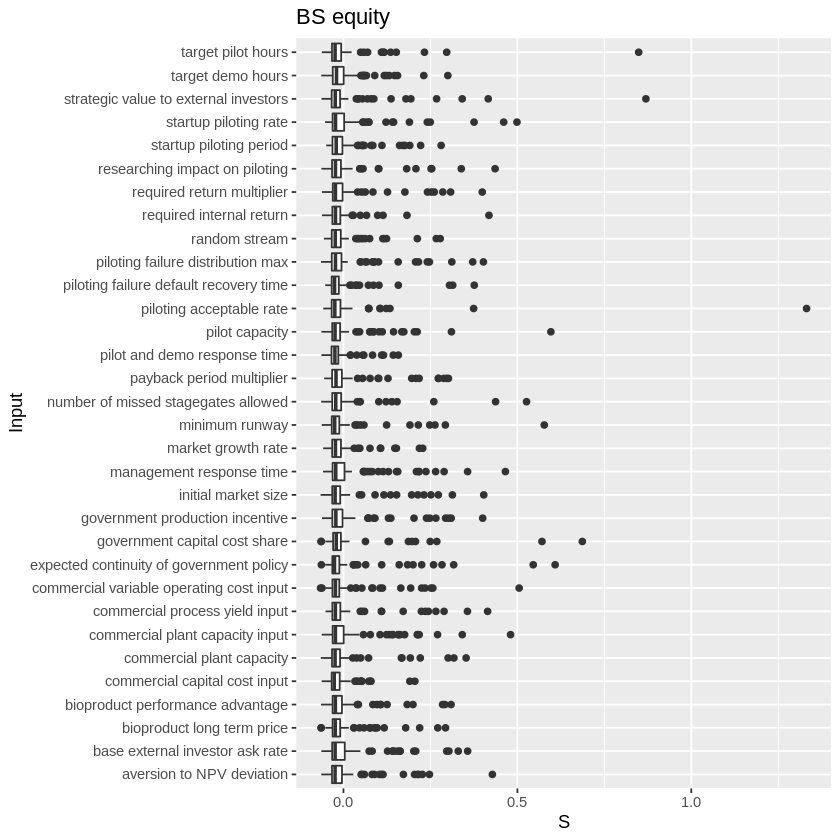

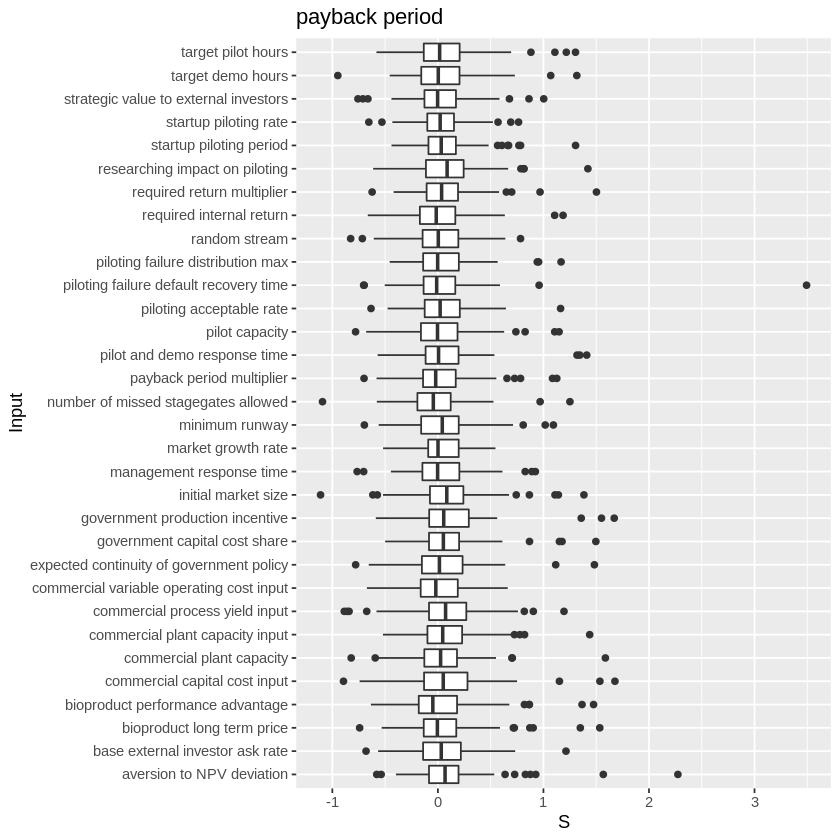

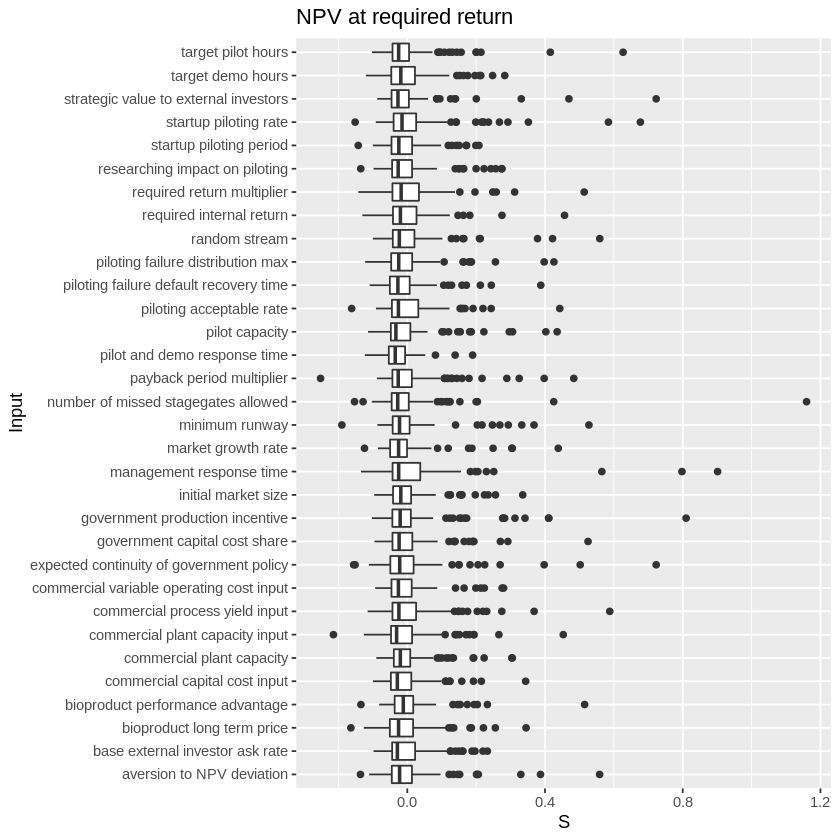

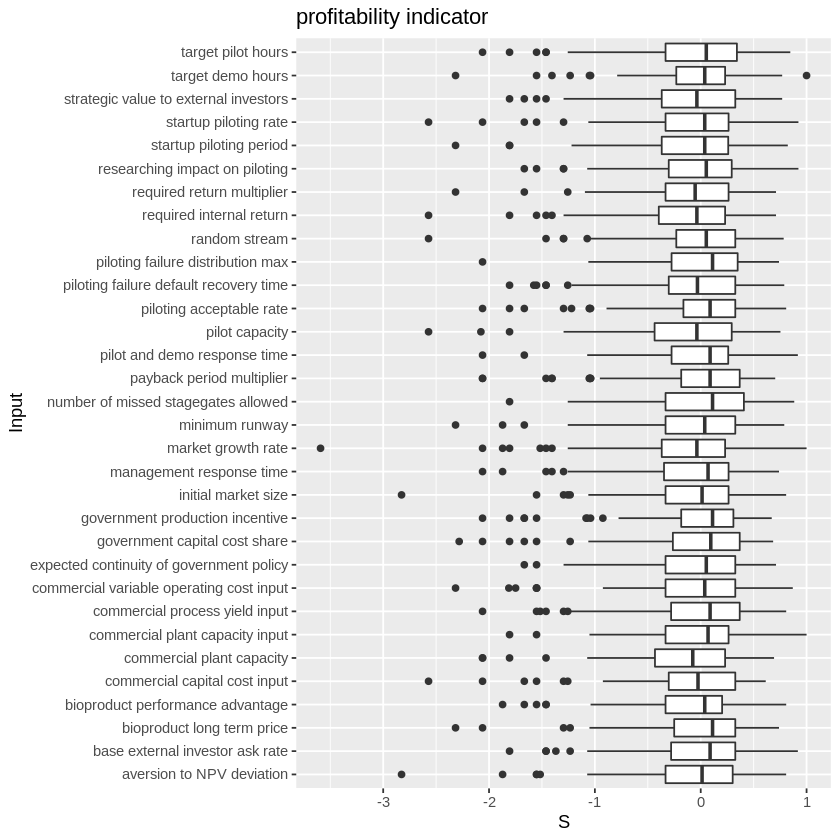

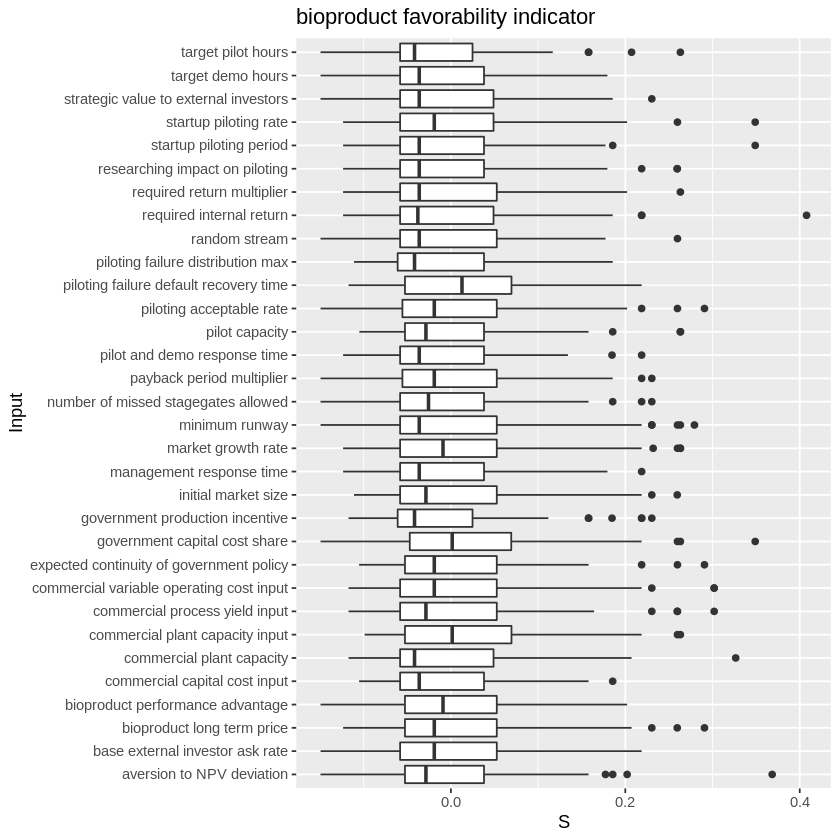

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

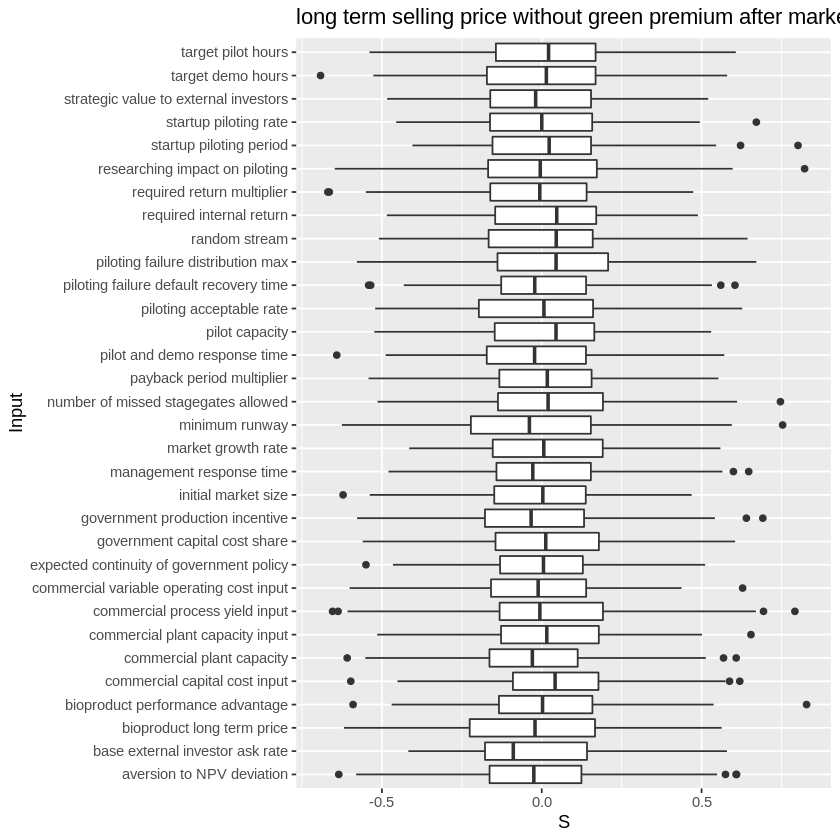

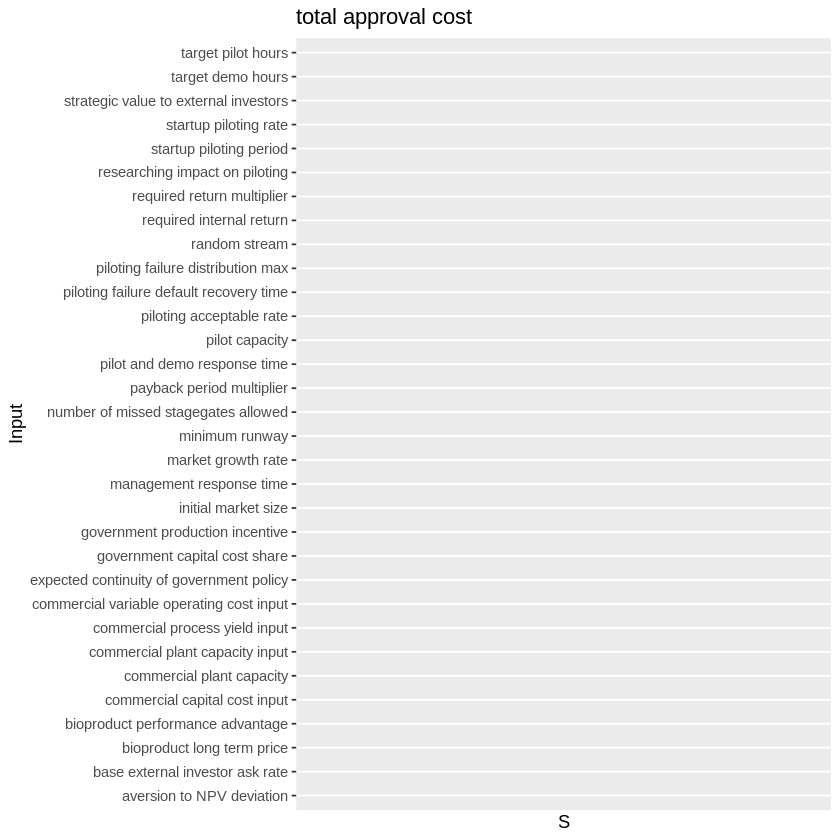

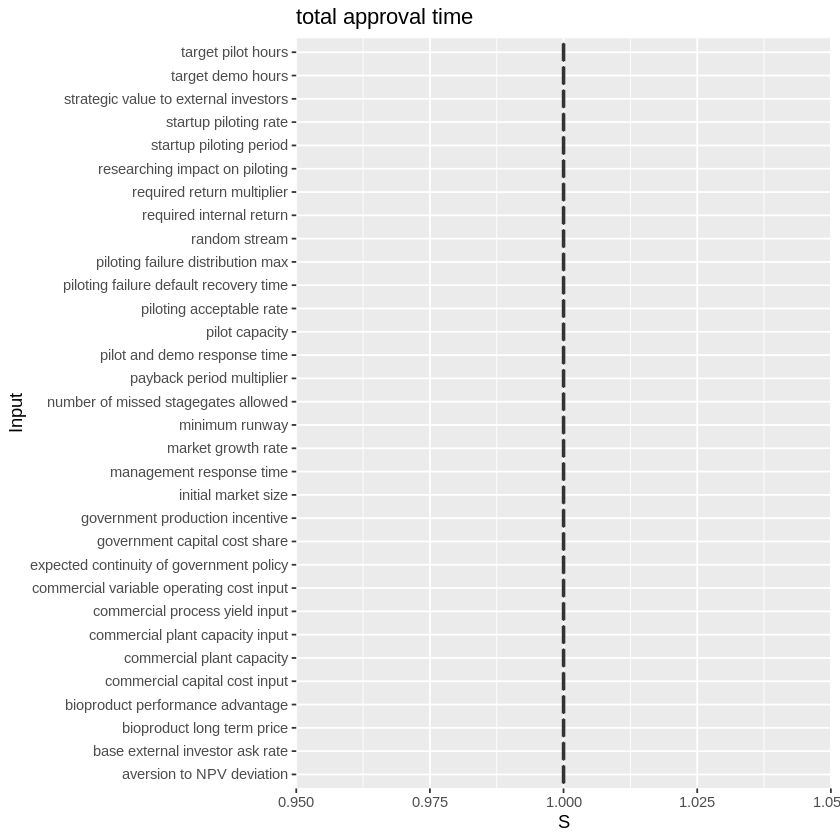

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

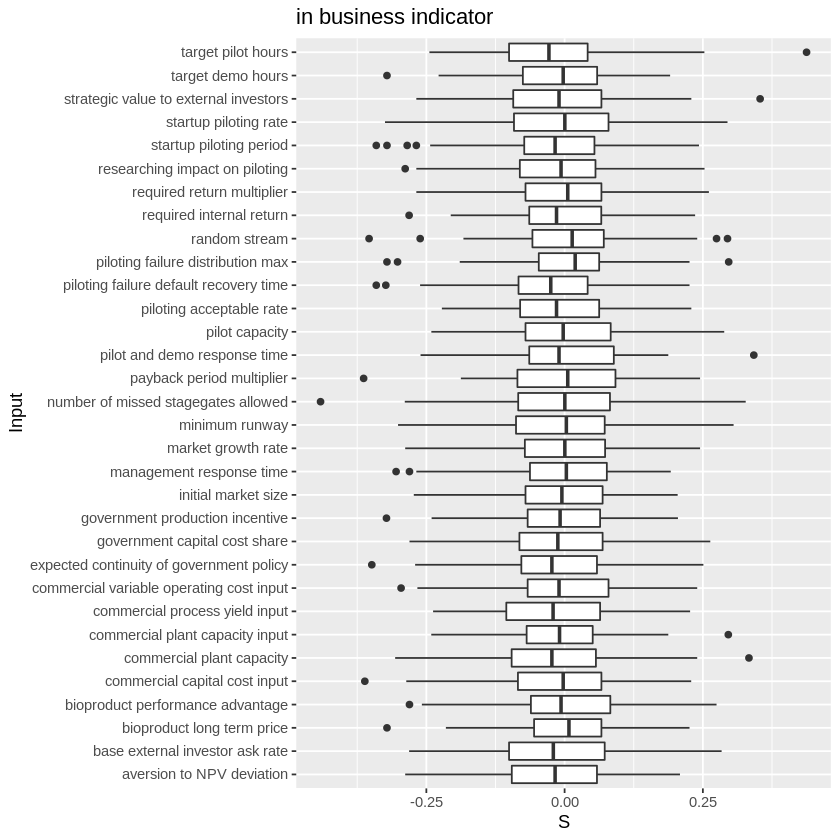

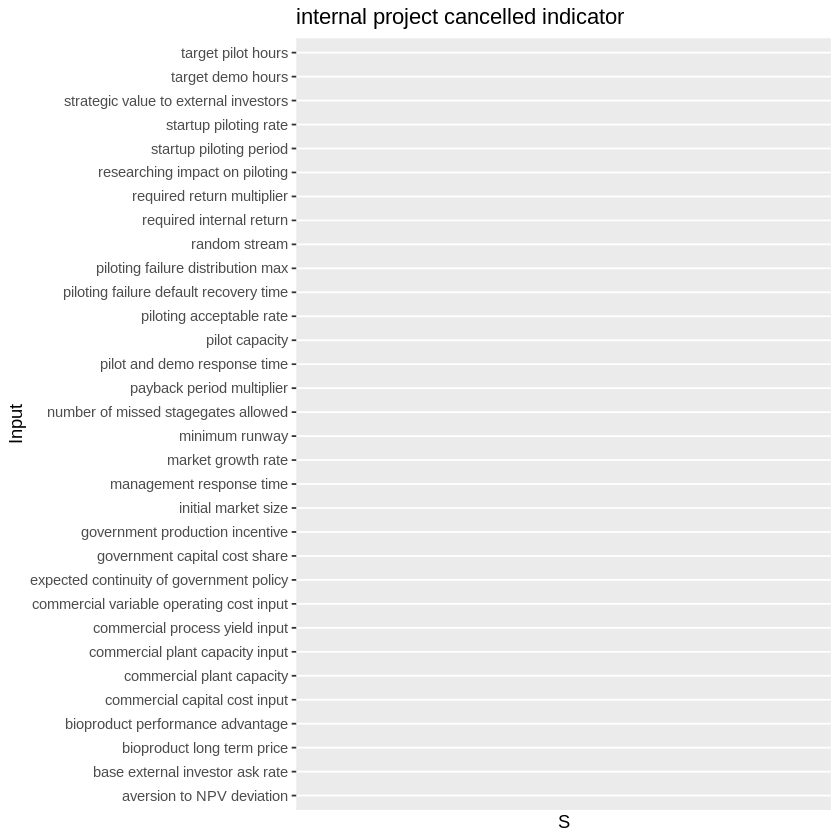

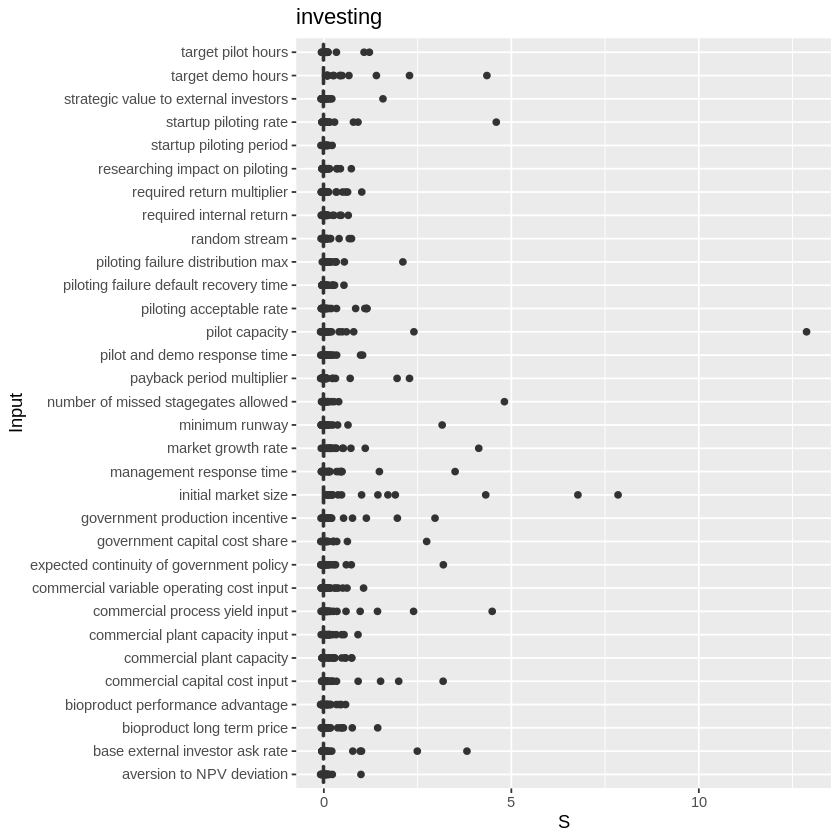

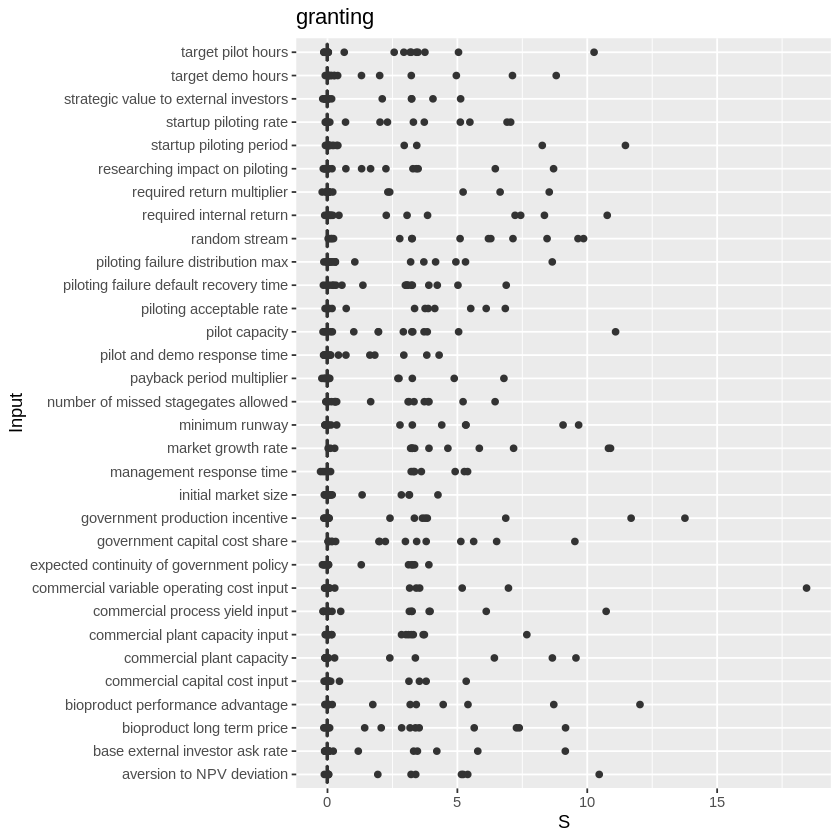

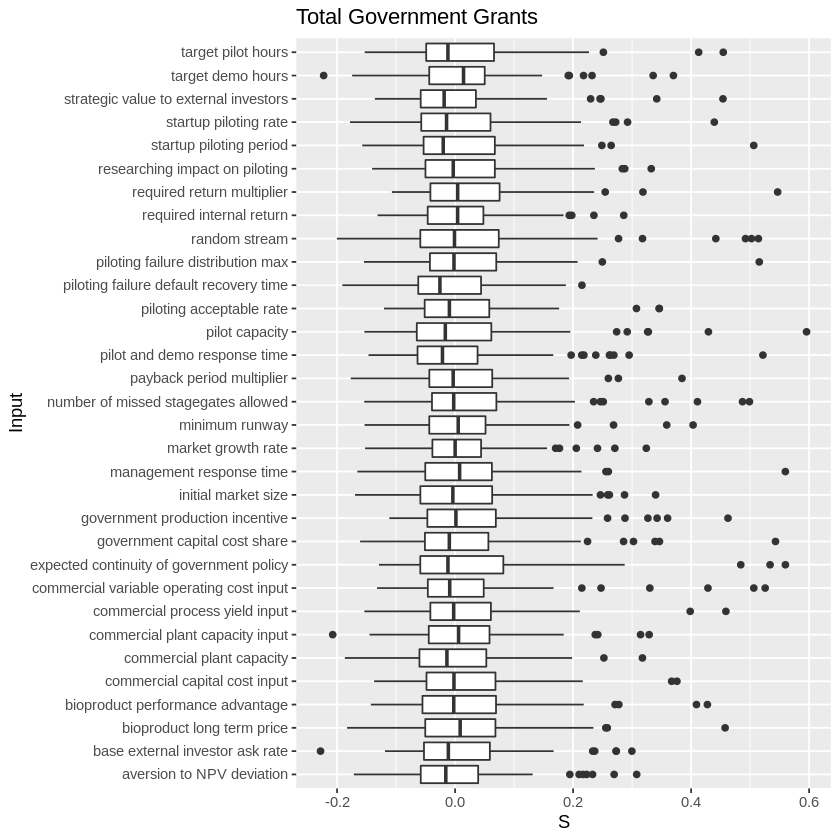

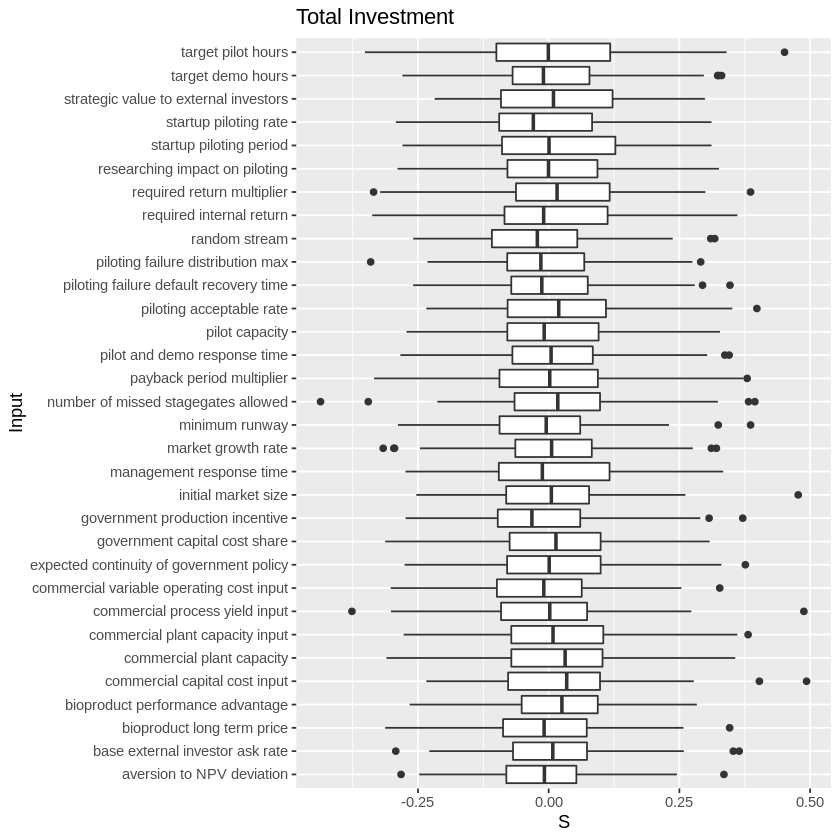

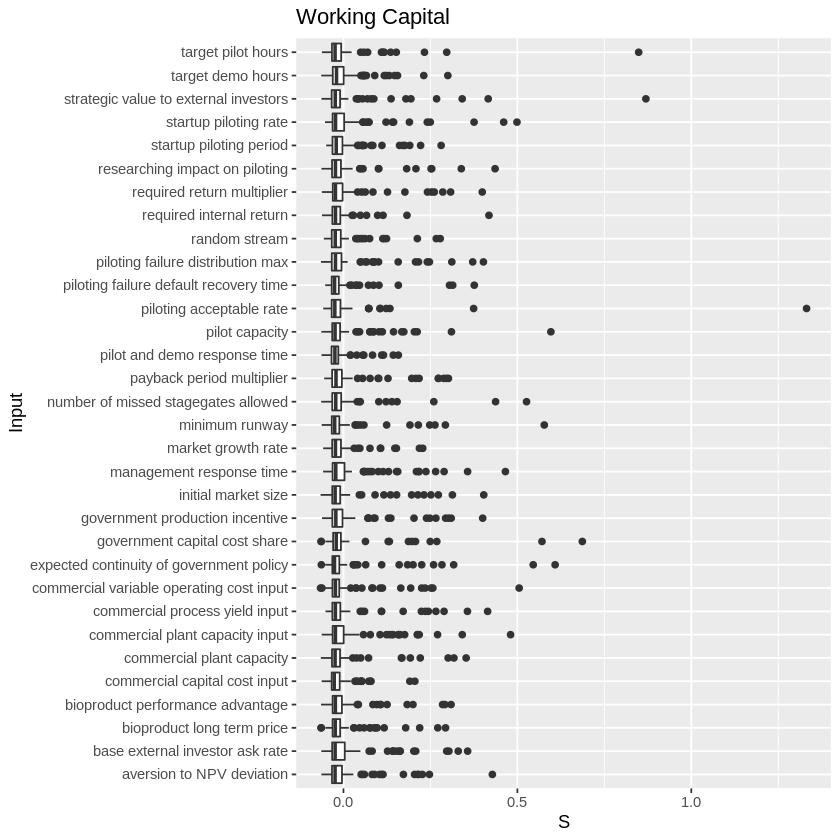

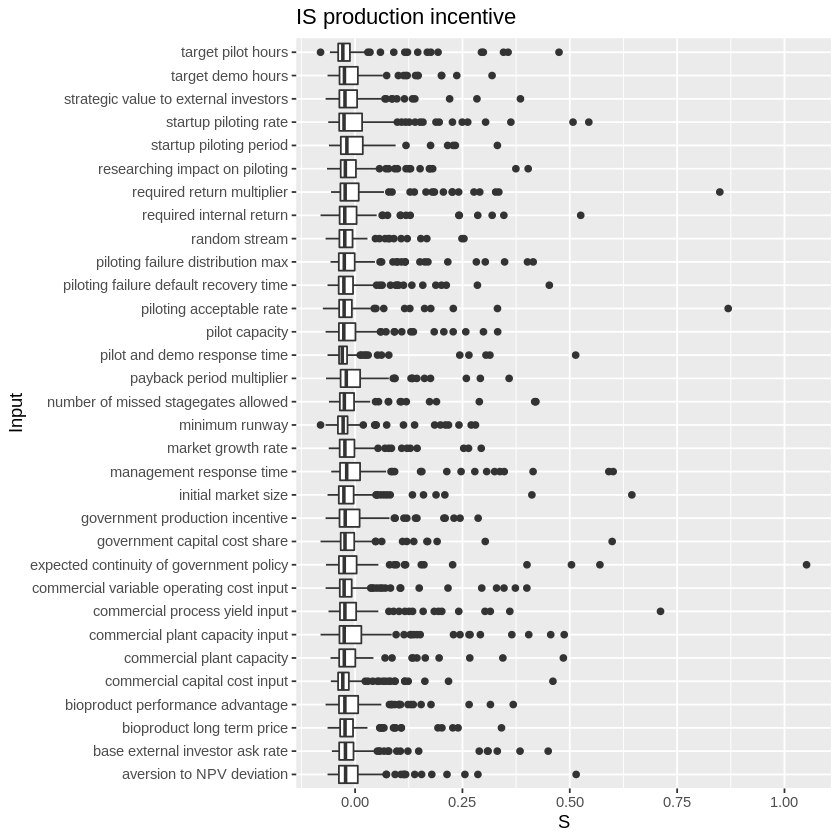

In [294]:
for (output in z.sens.boot[, unique(Output)]) {
    g <- ggplot(z.sens.boot[Output == output], aes(x=Input, y=S)) +
        geom_boxplot() +
        coord_flip() +
        ggtitle(output)
    print(g)
}

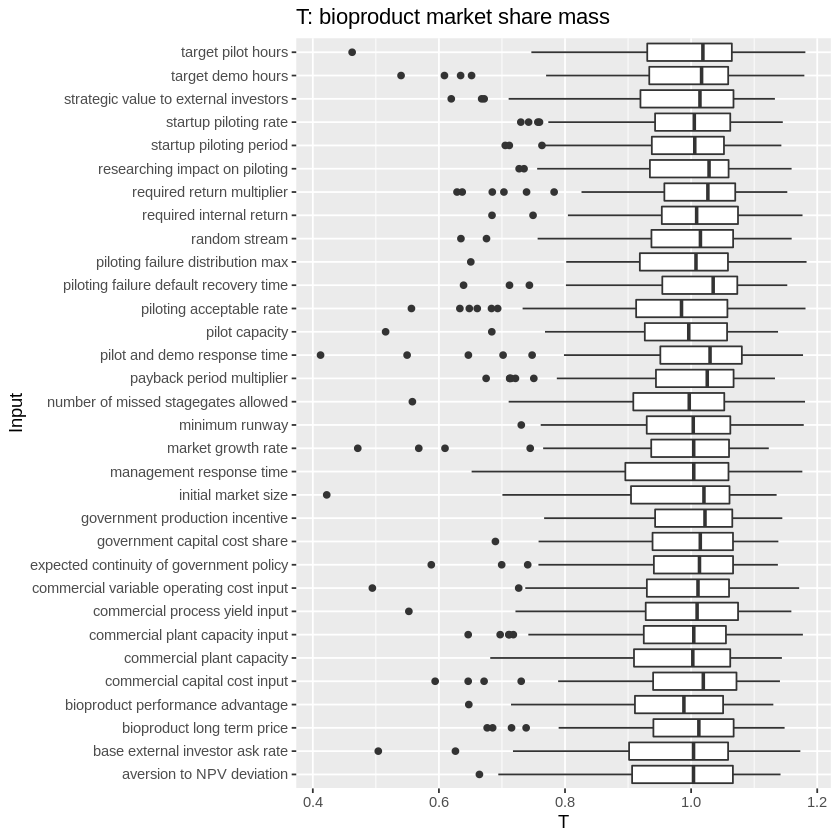

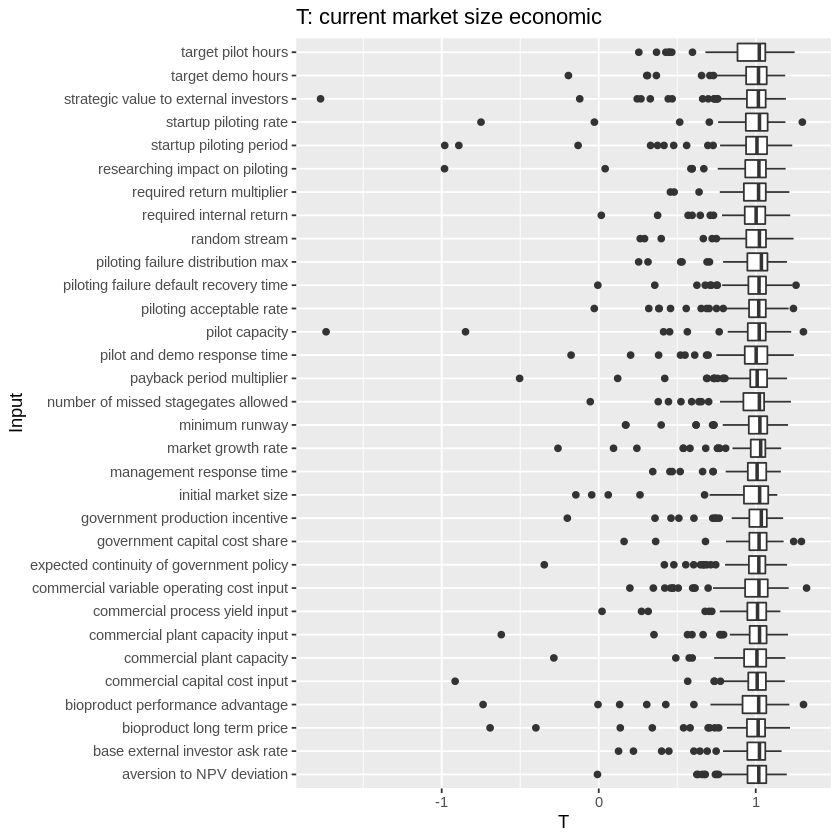

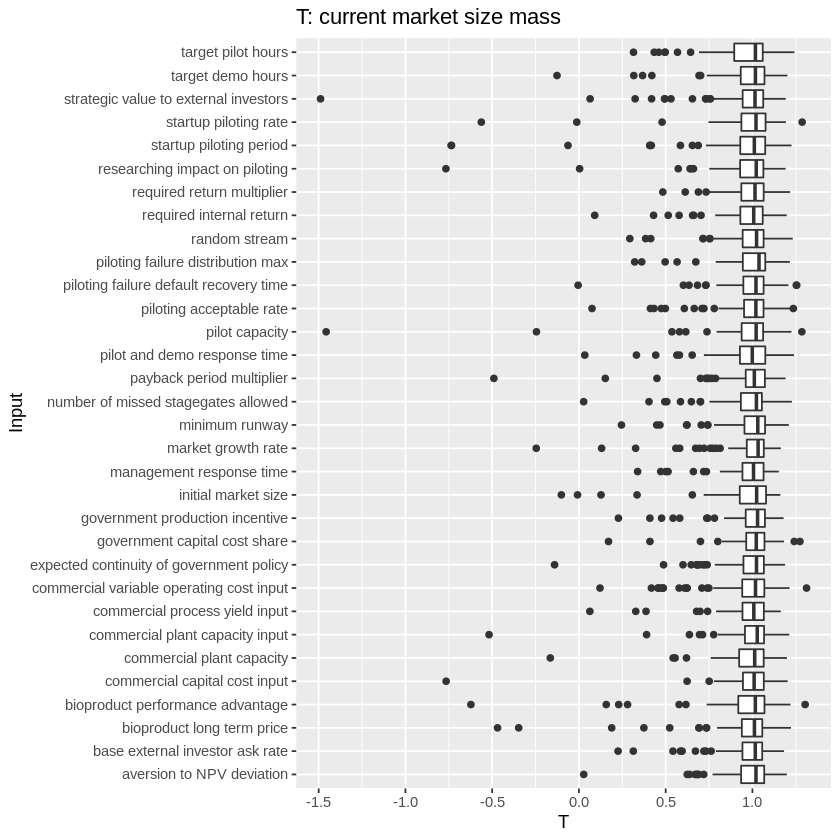

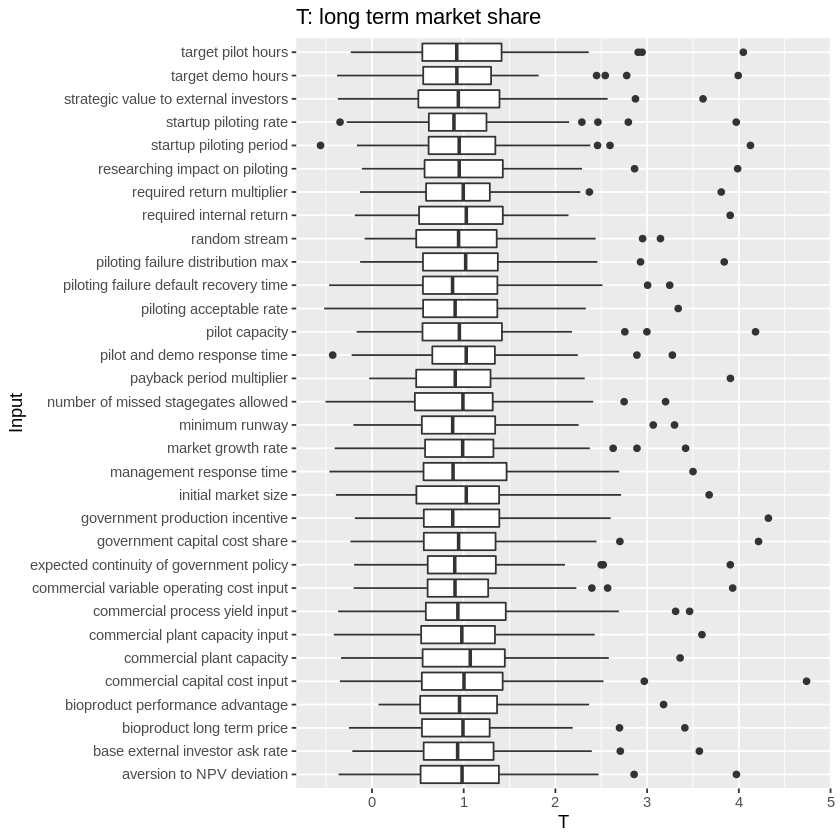

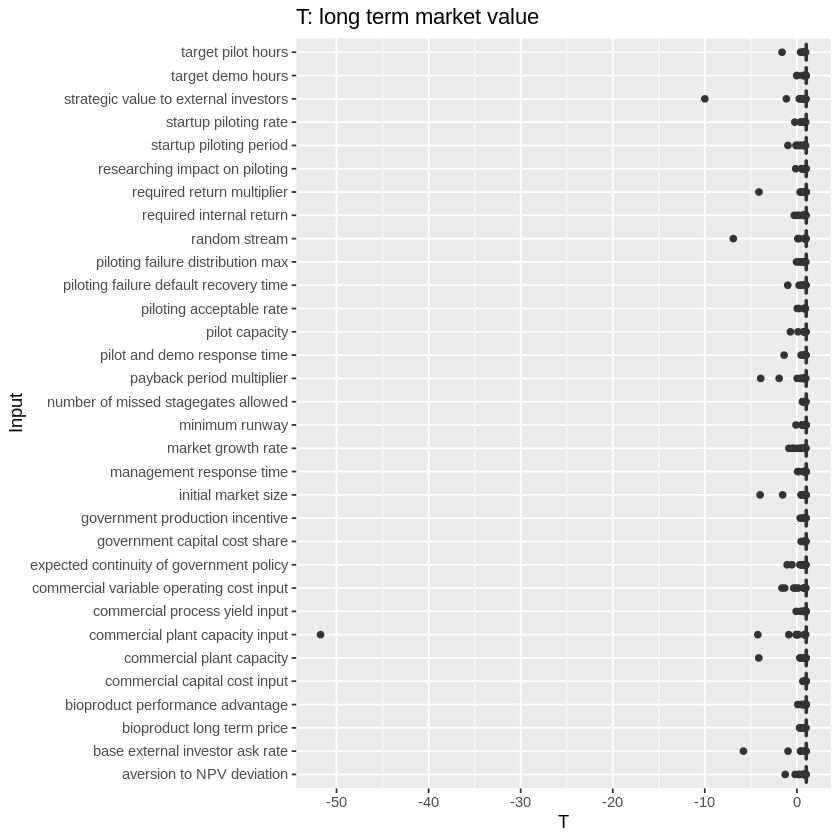

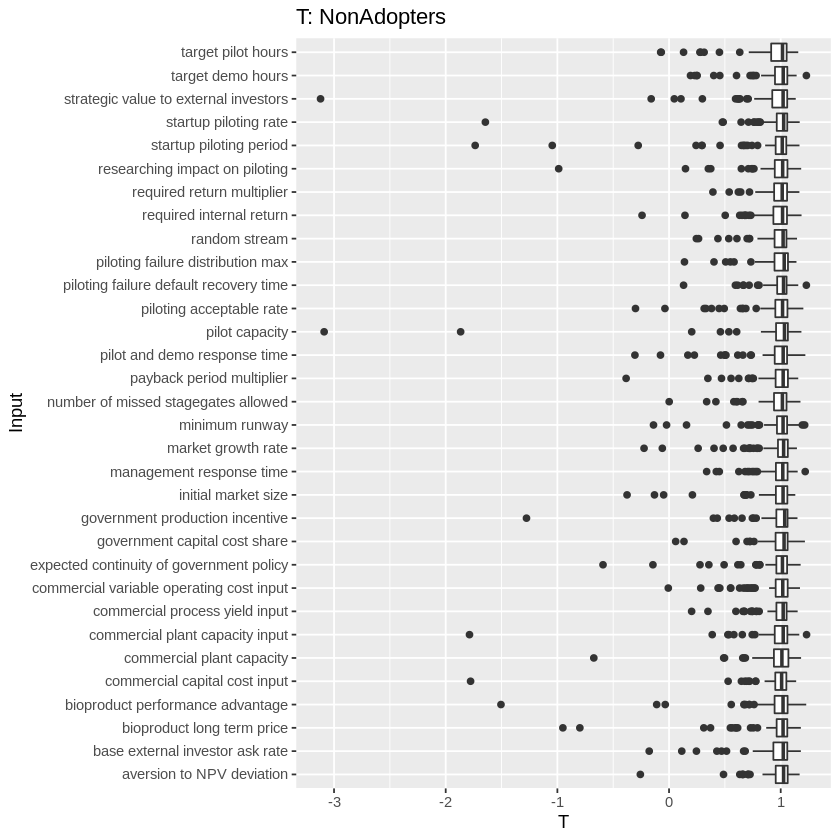

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

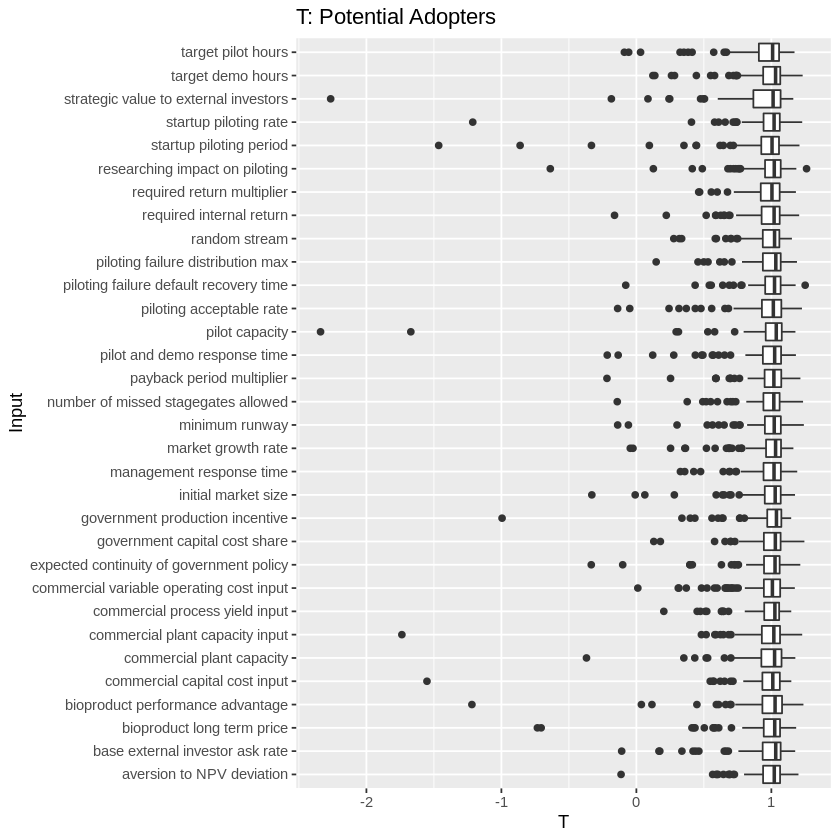

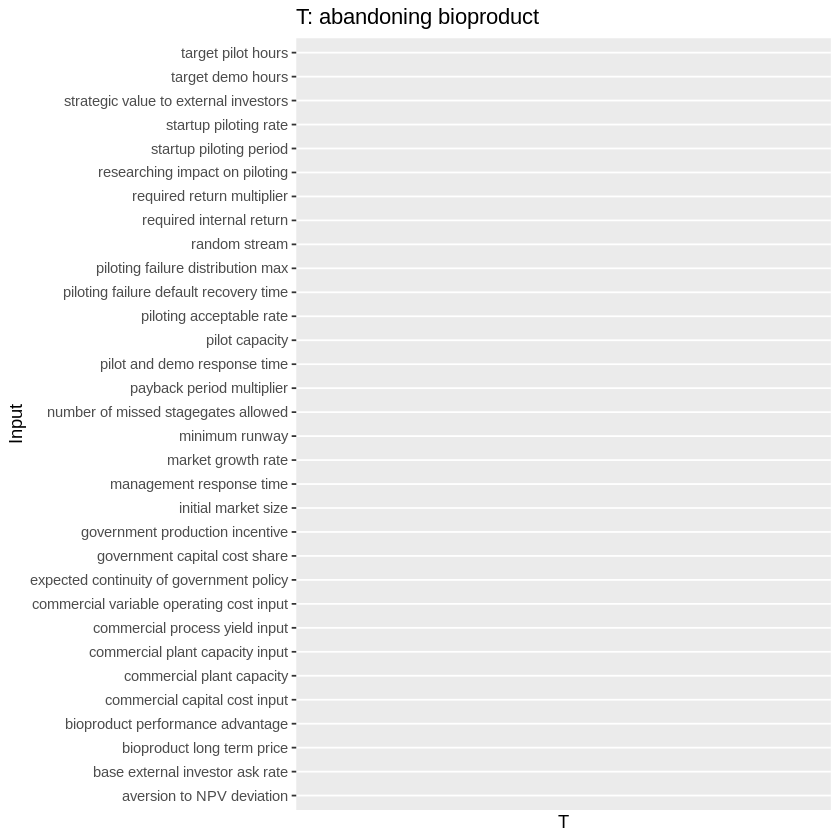

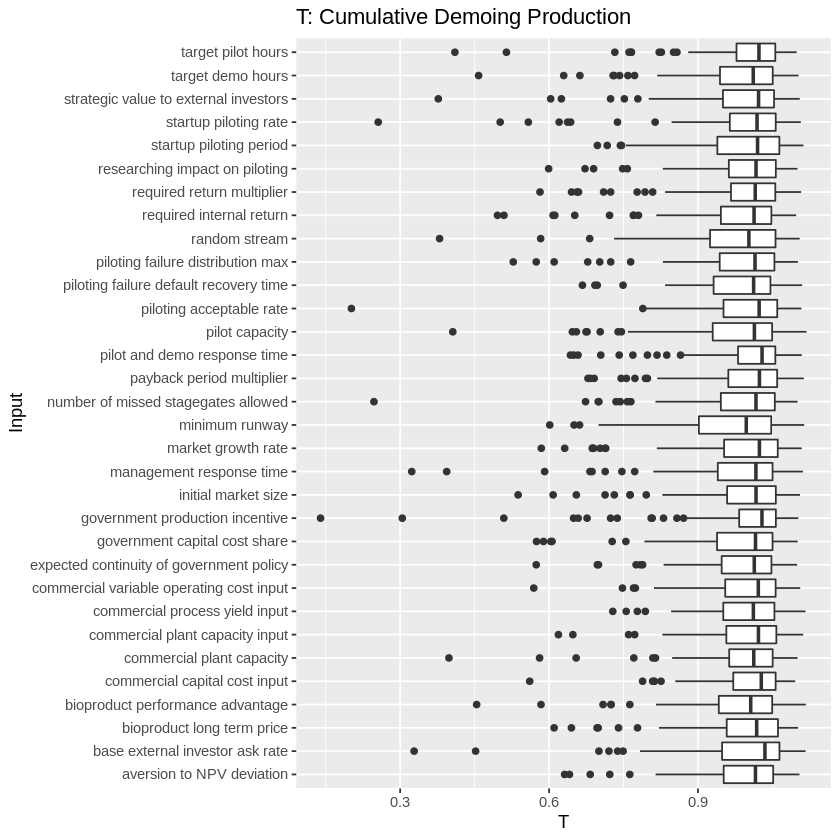

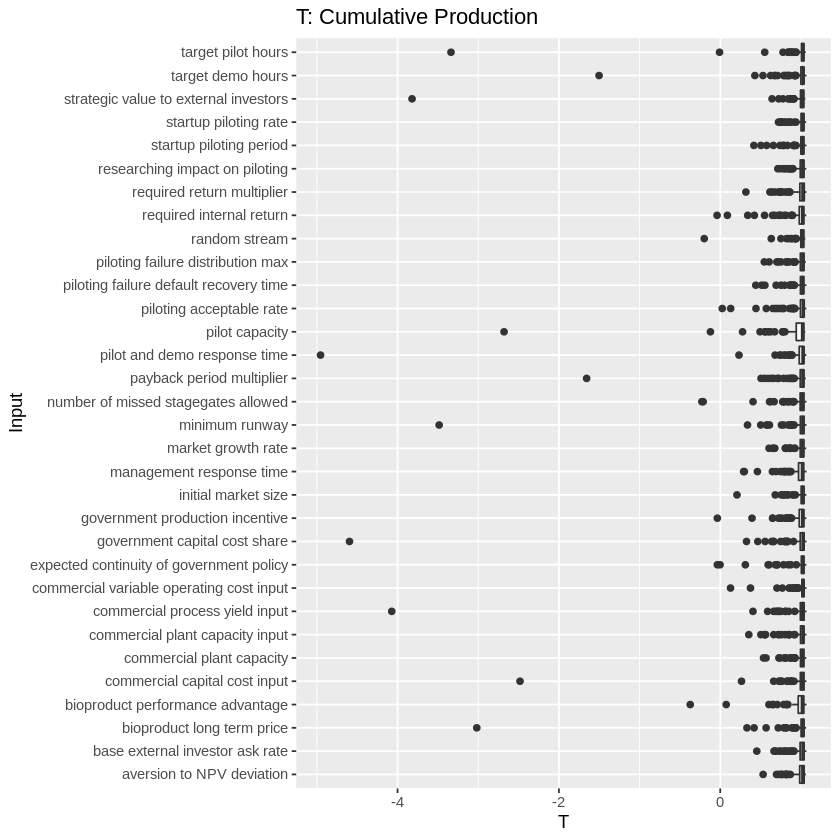

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

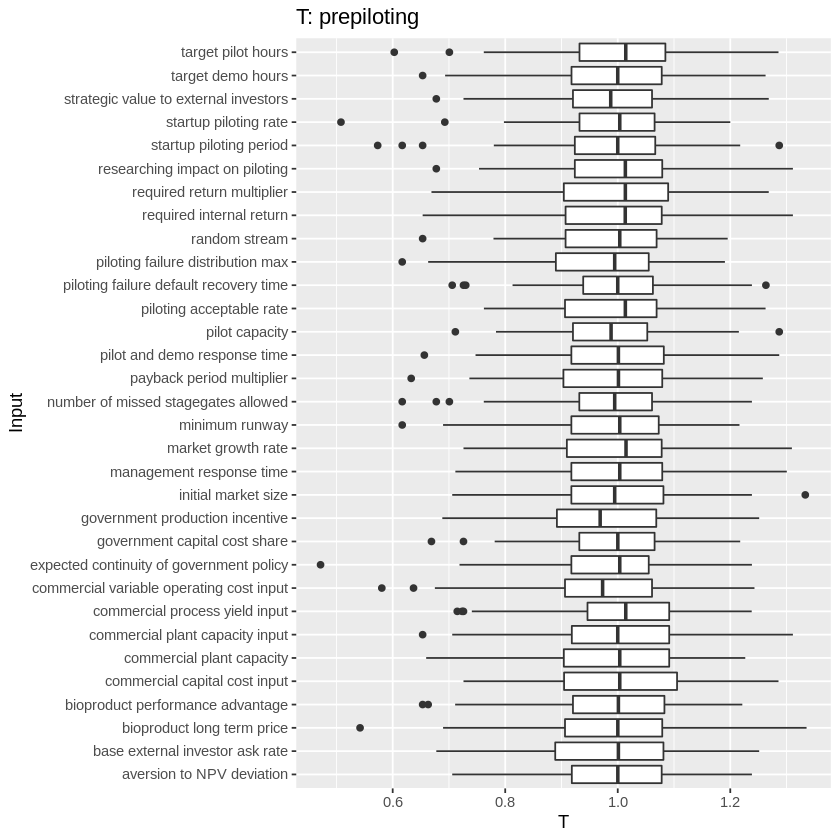

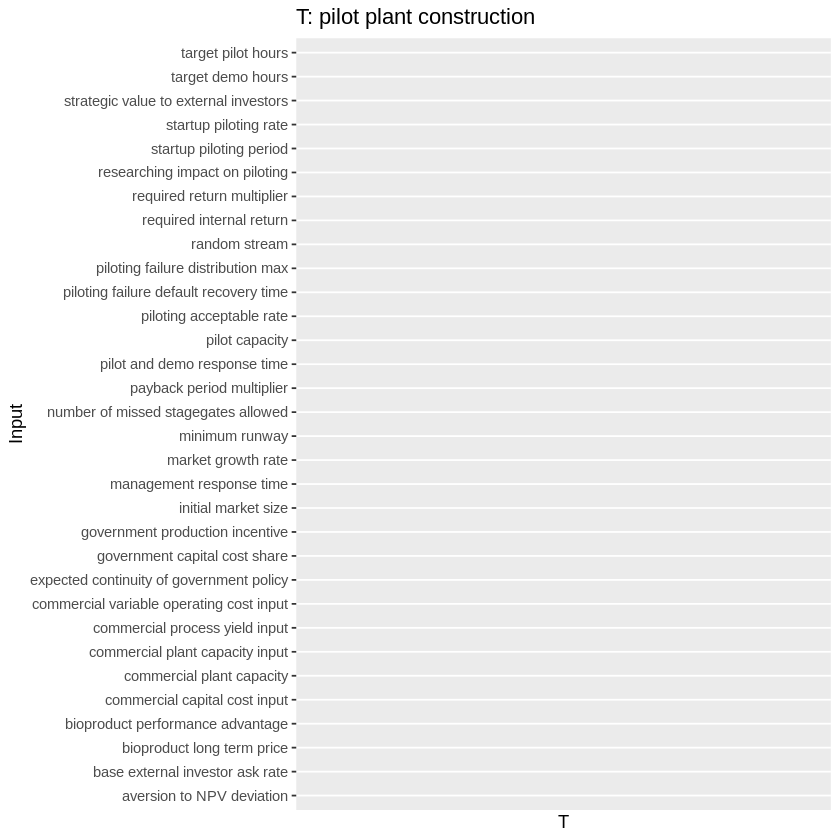

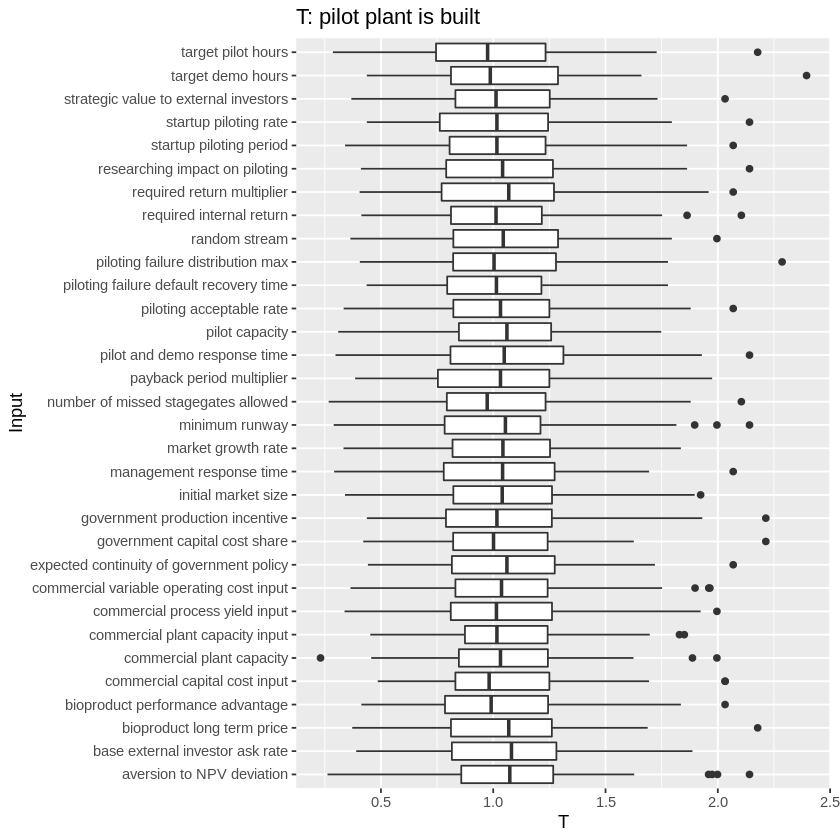

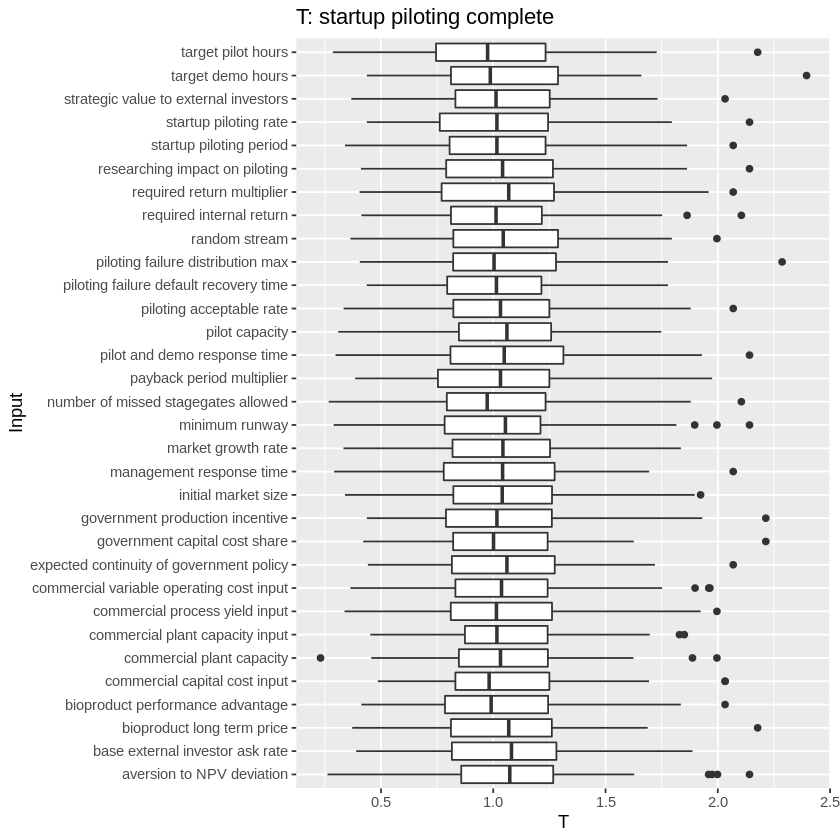

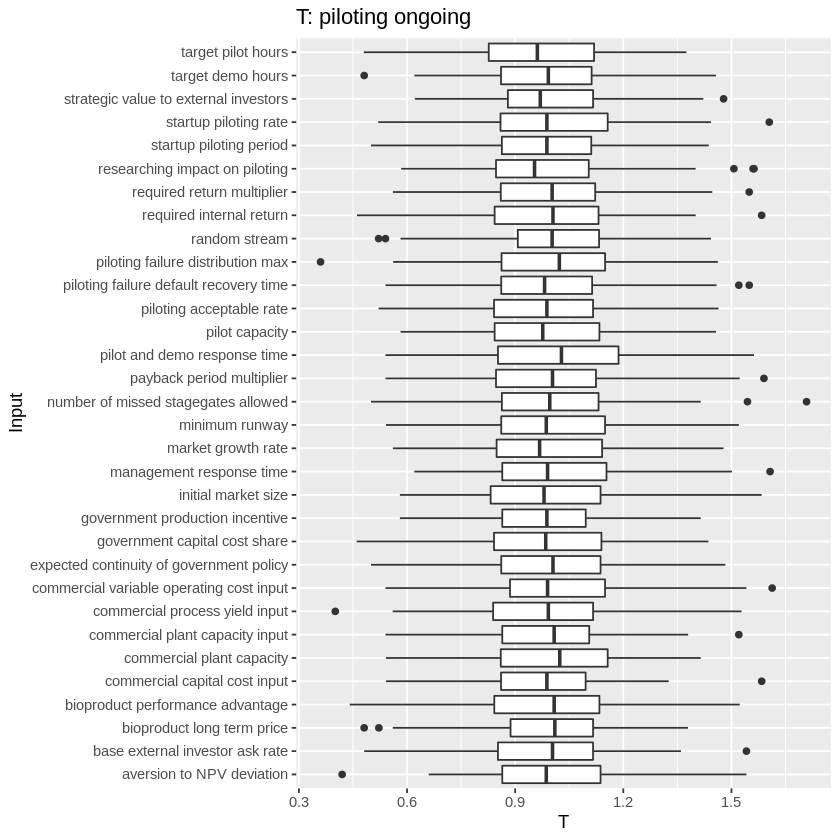

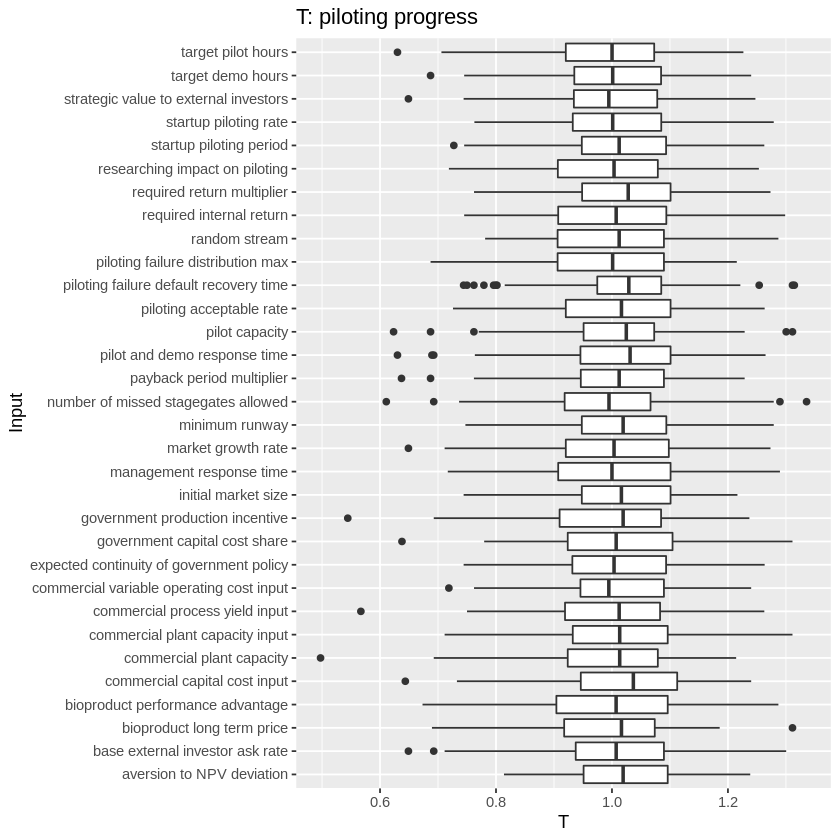

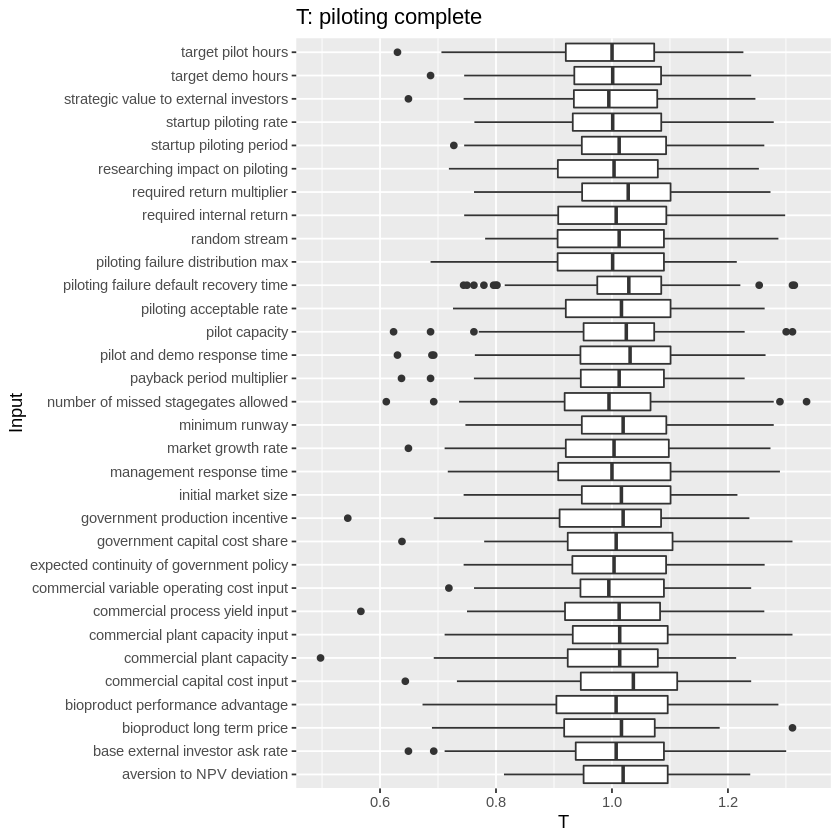

Warning message:
"Removed 224 rows containing non-finite values (stat_boxplot)."

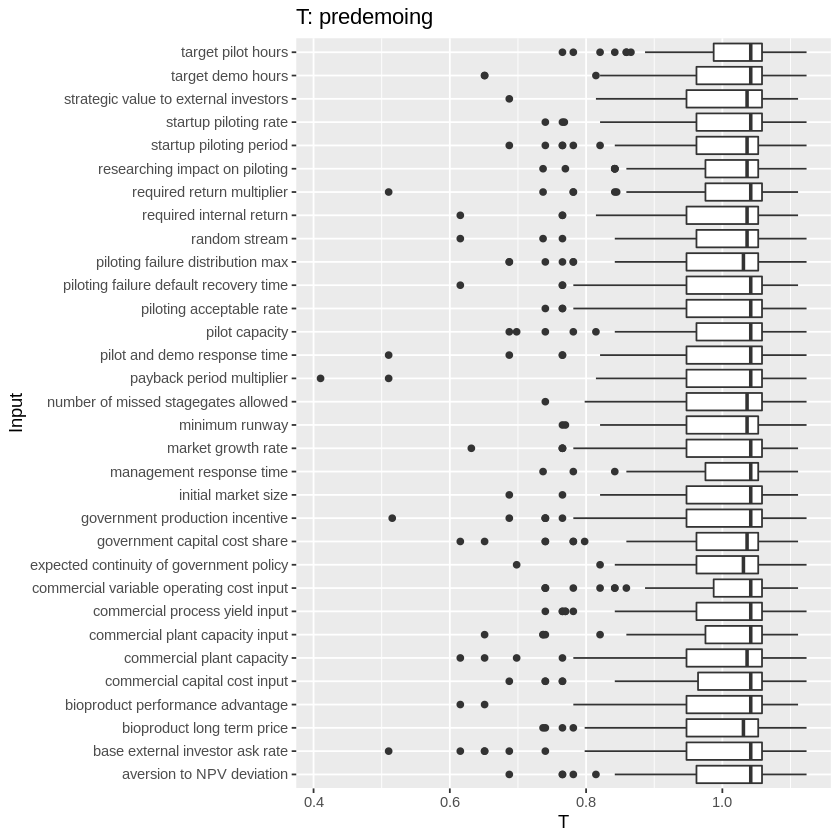

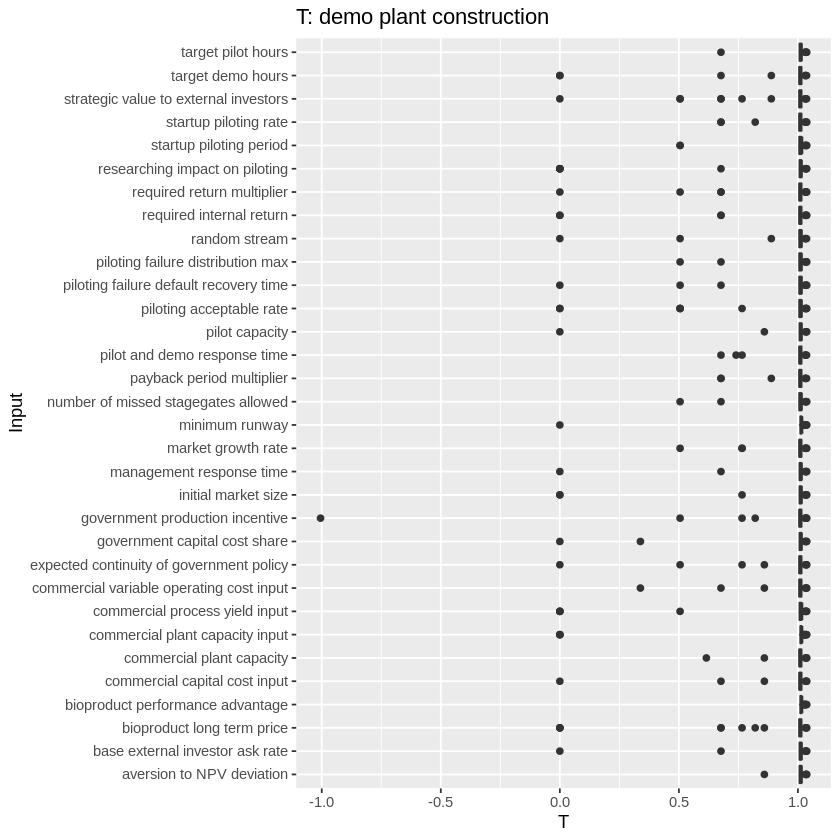

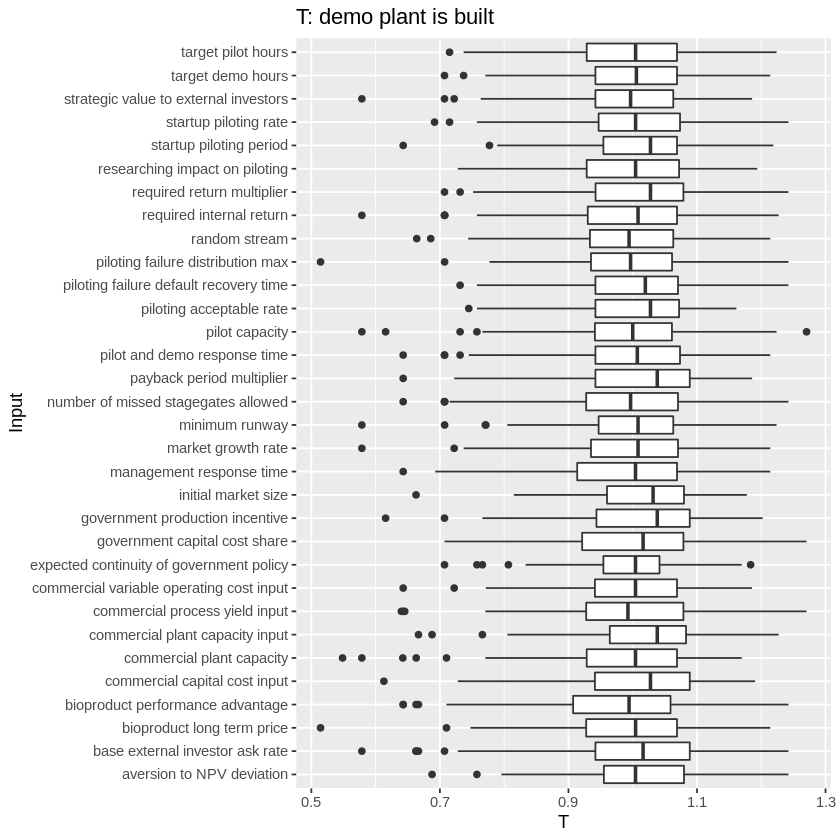

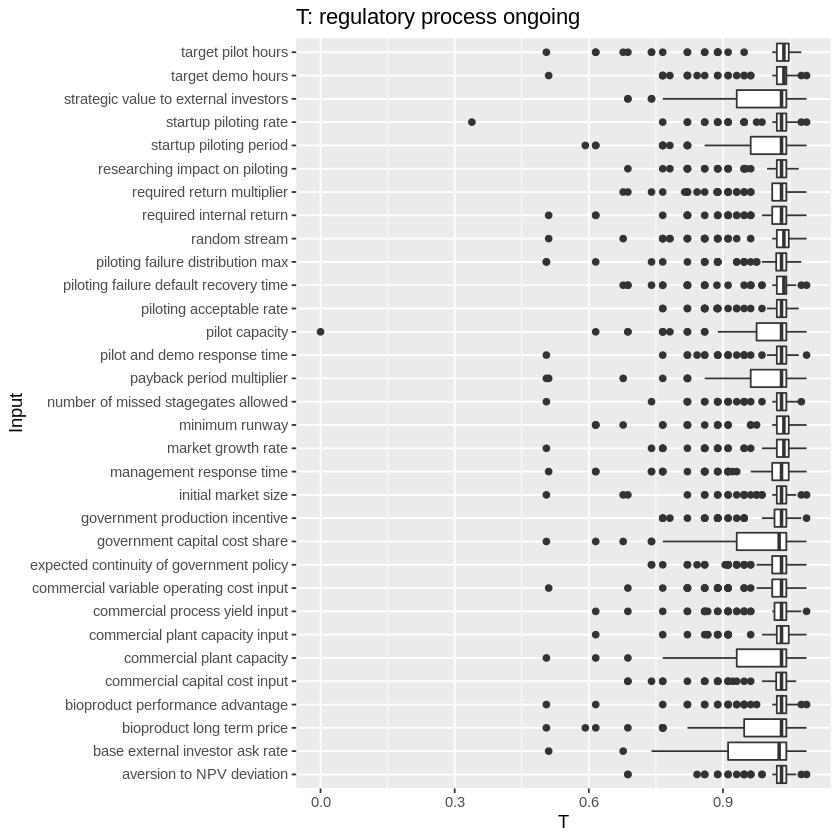

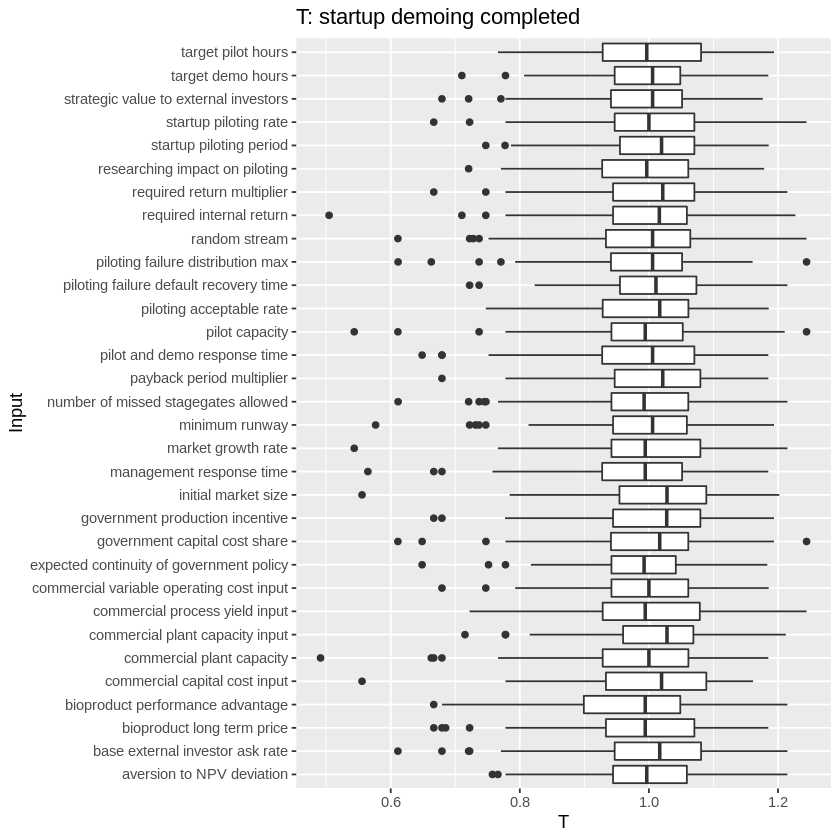

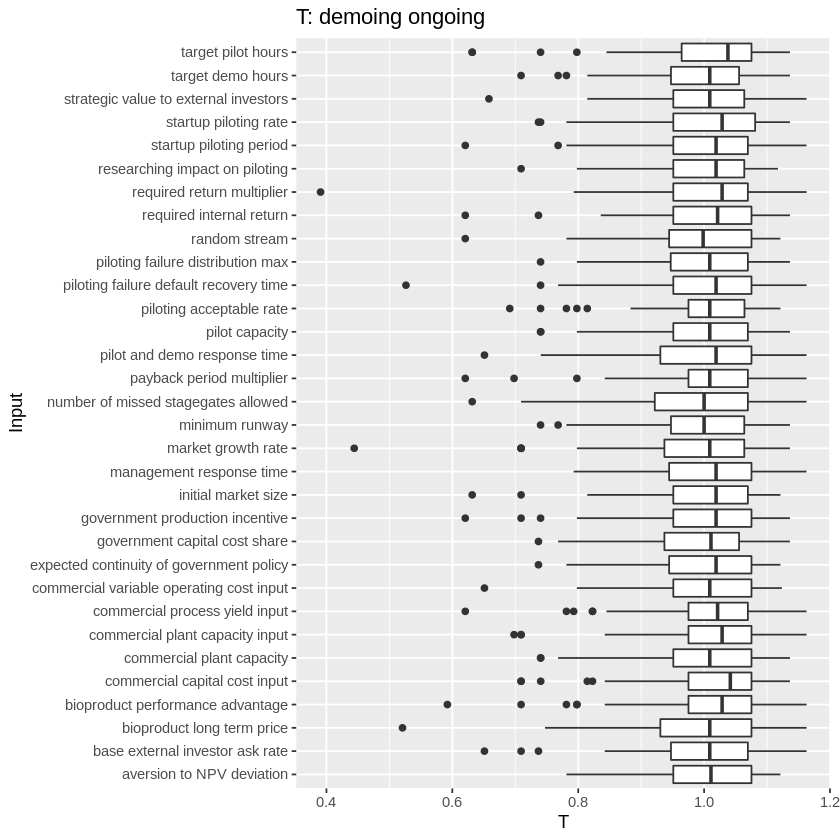

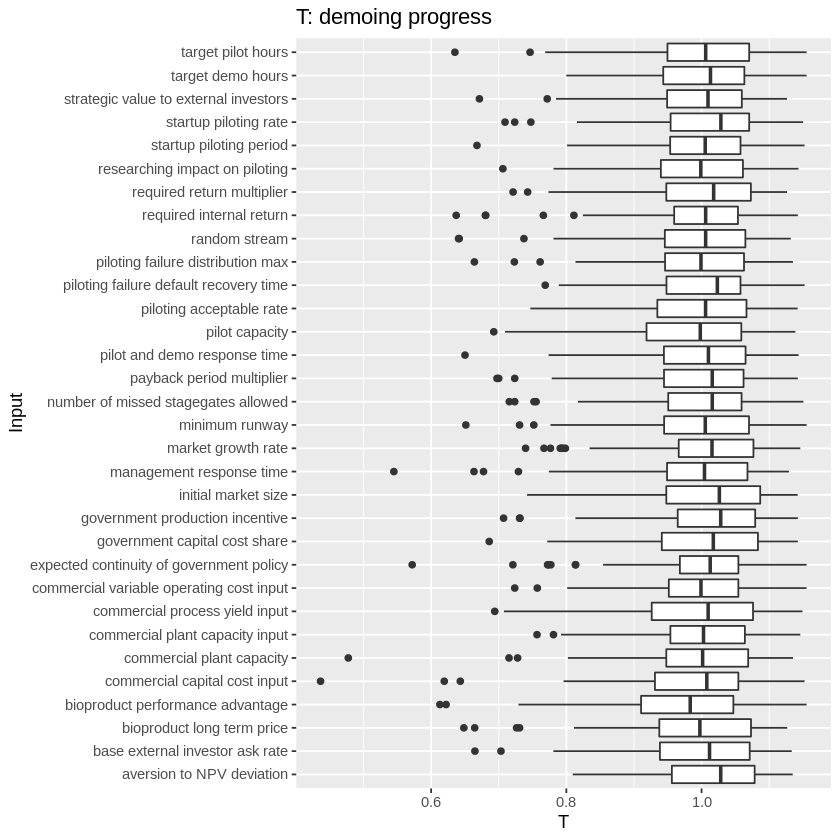

Warning message:
"Removed 864 rows containing non-finite values (stat_boxplot)."

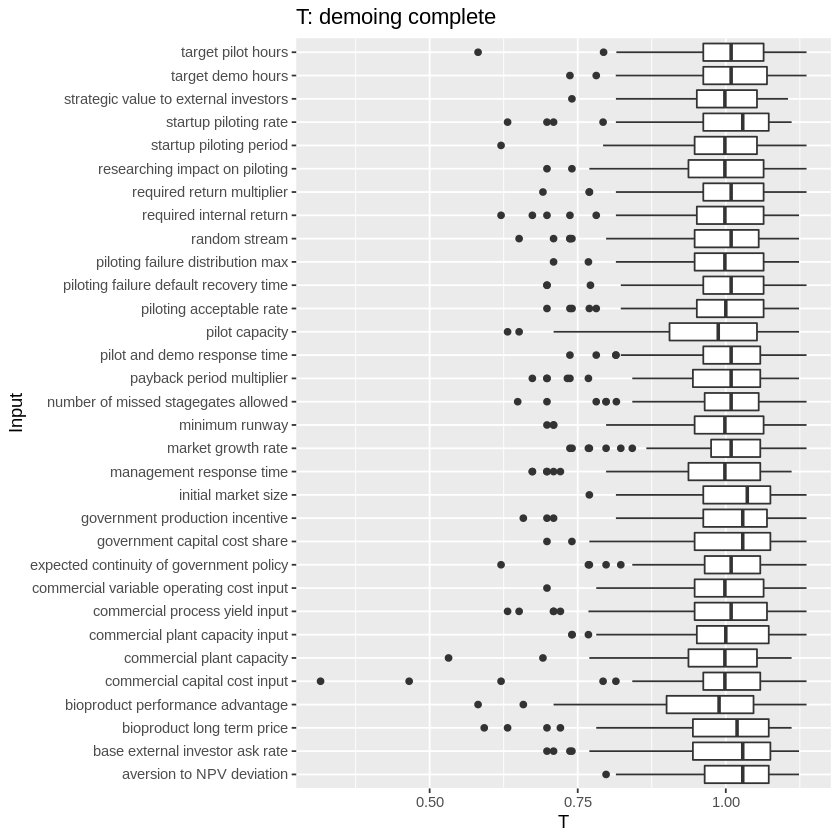

Warning message:
"Removed 96 rows containing non-finite values (stat_boxplot)."

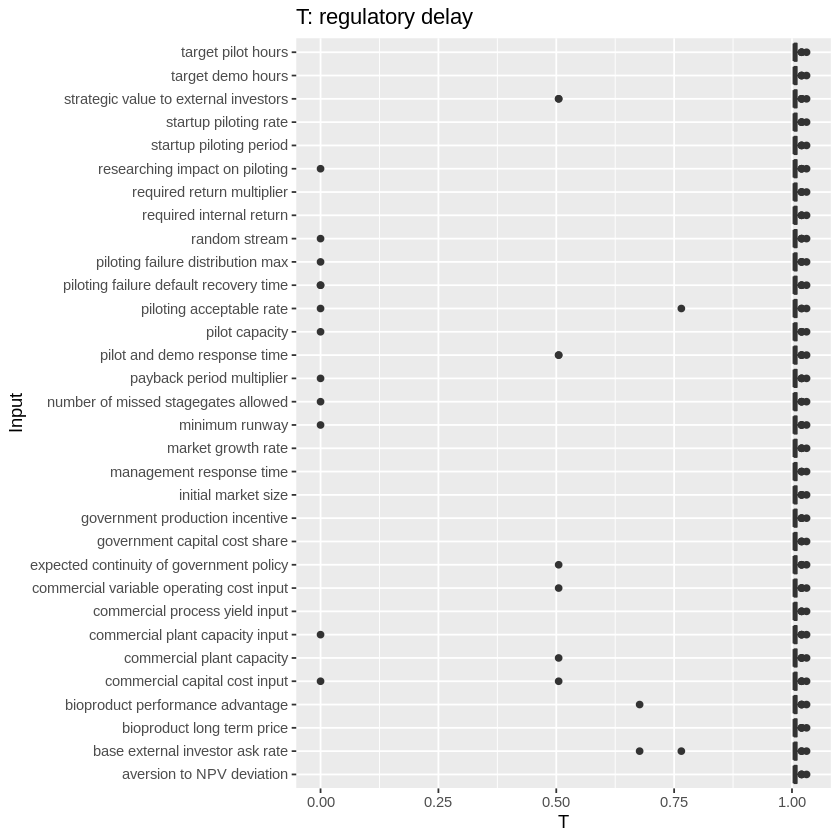

Warning message:
"Removed 960 rows containing non-finite values (stat_boxplot)."

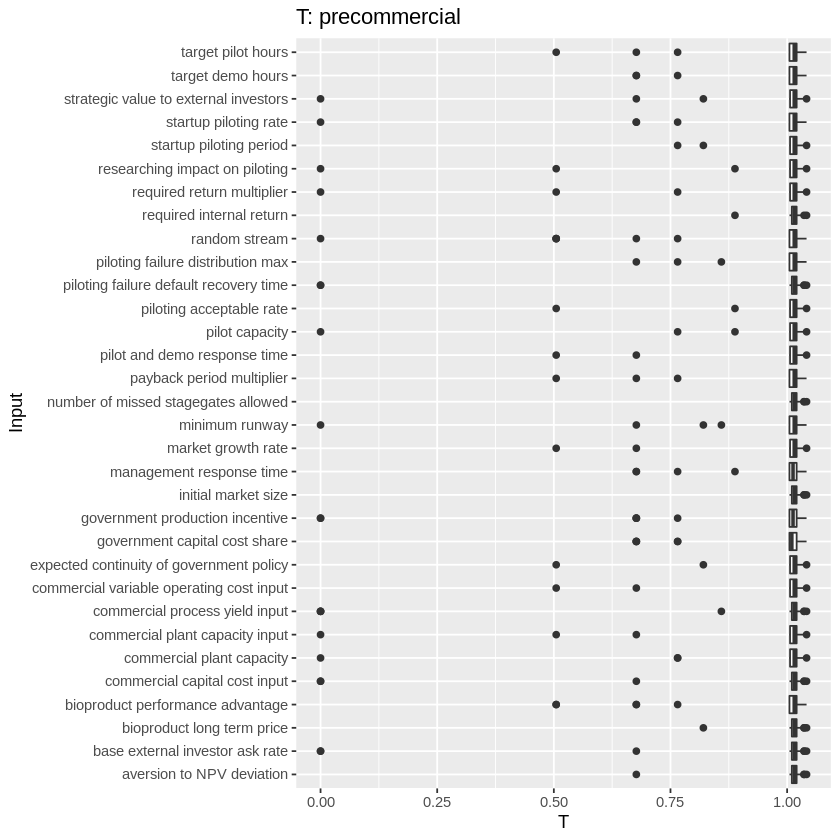

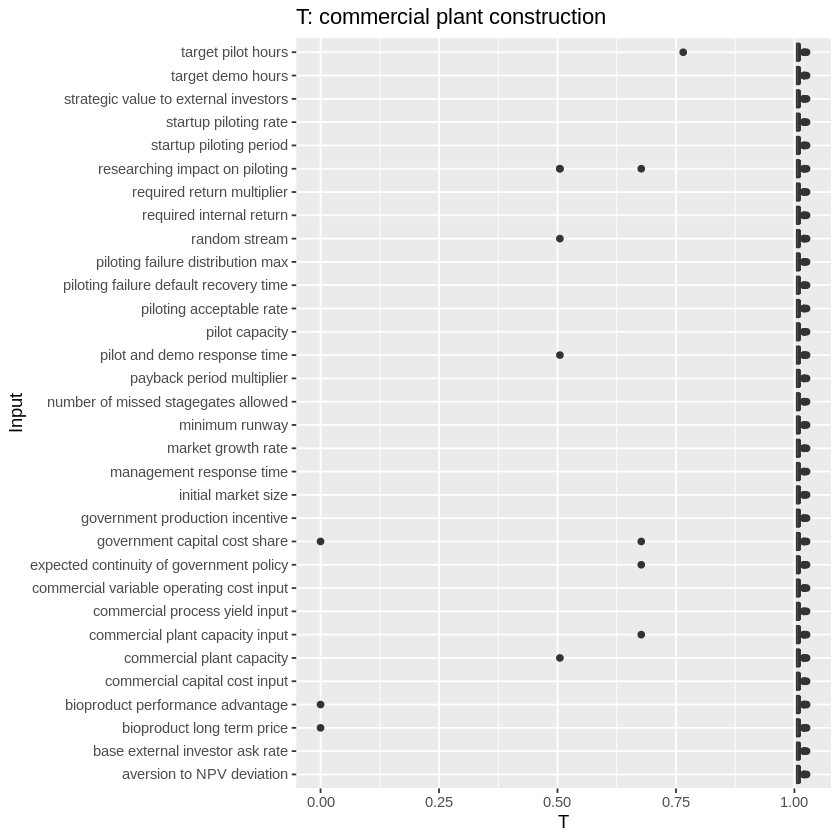

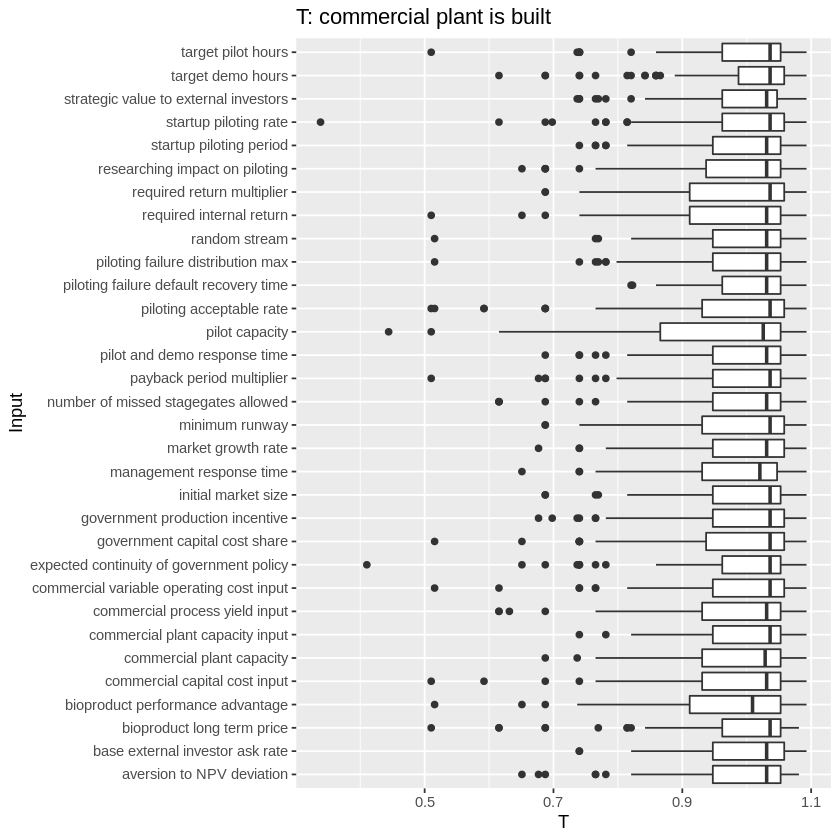

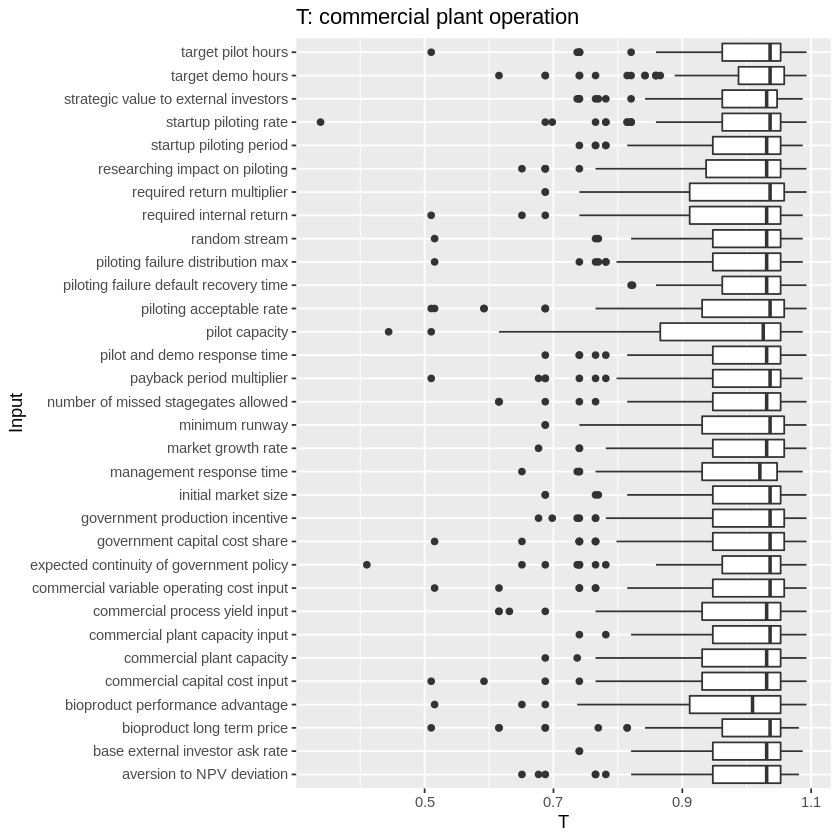

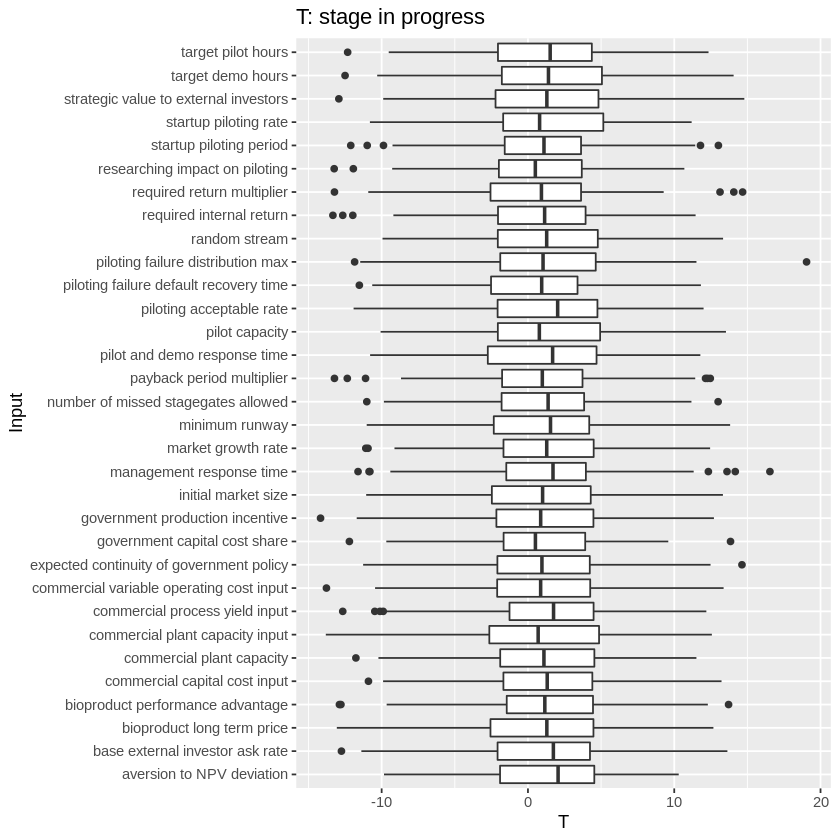

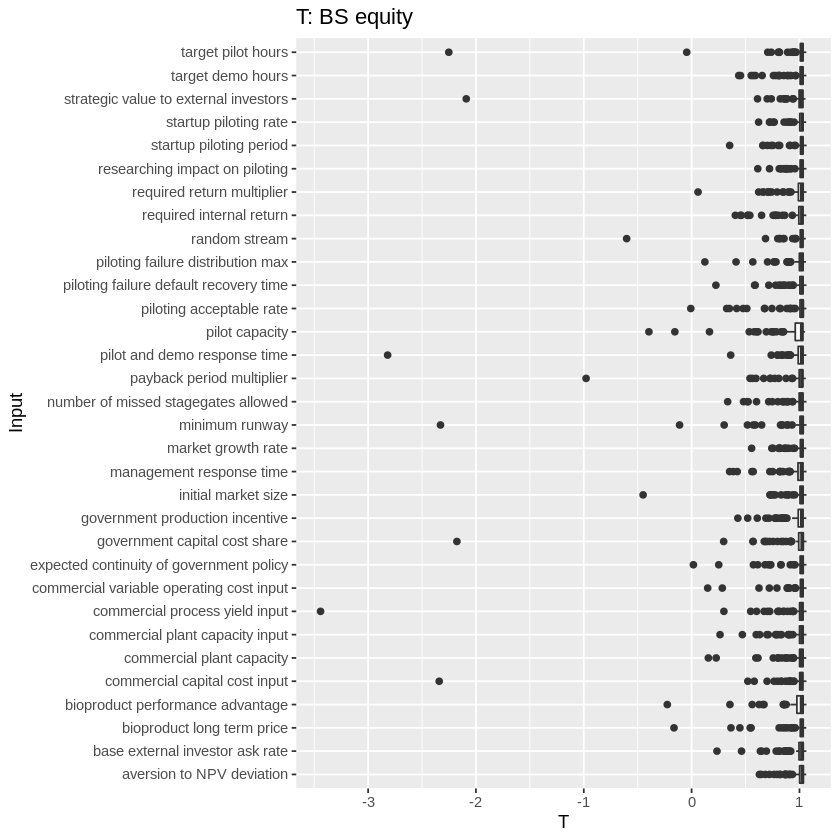

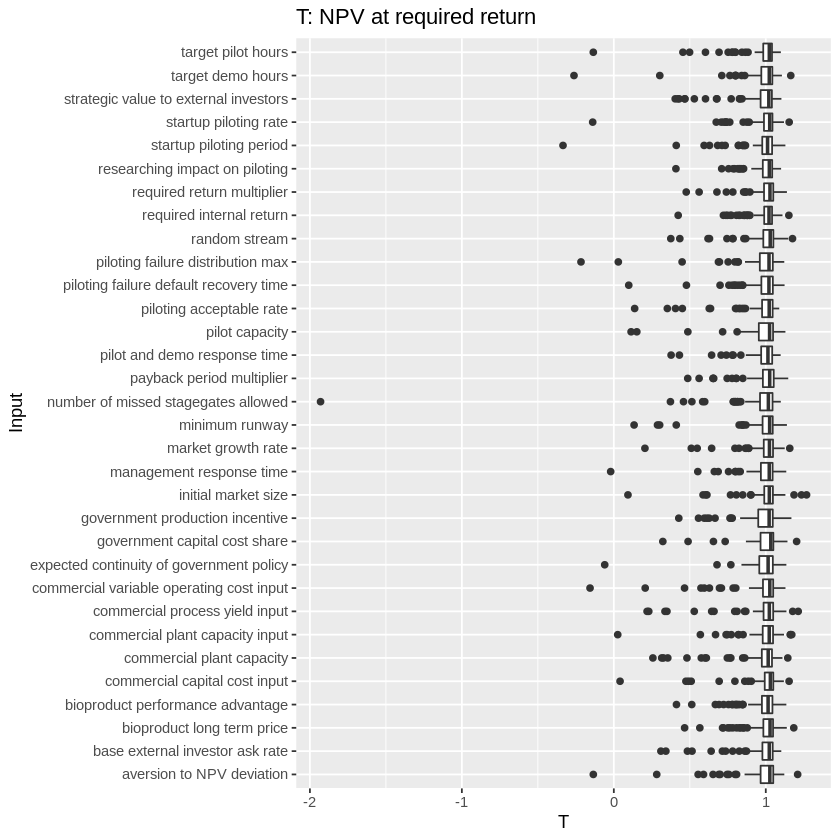

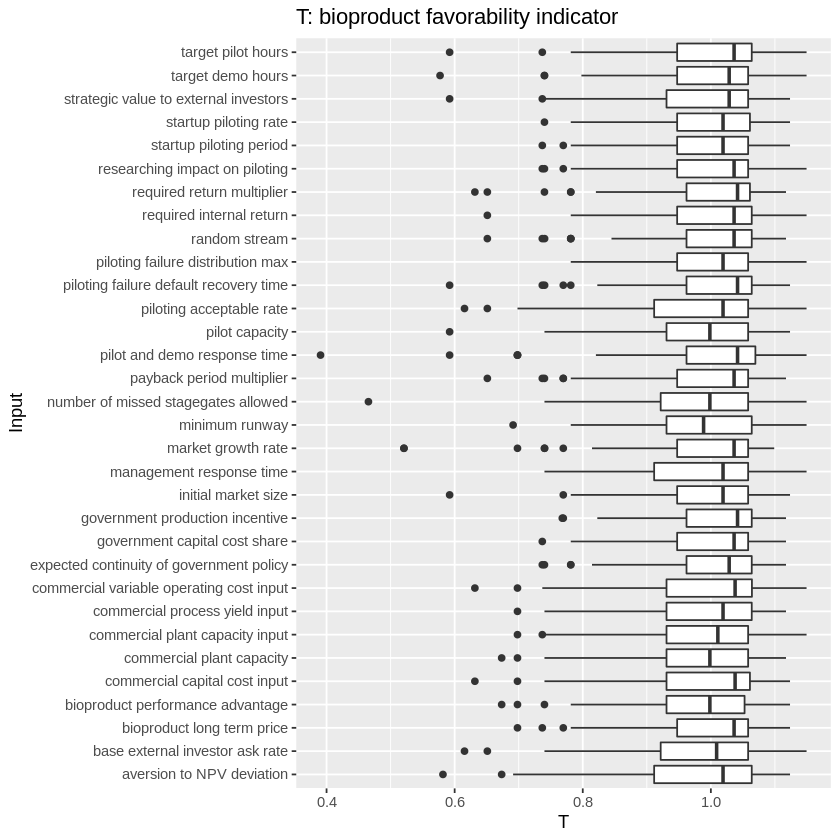

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

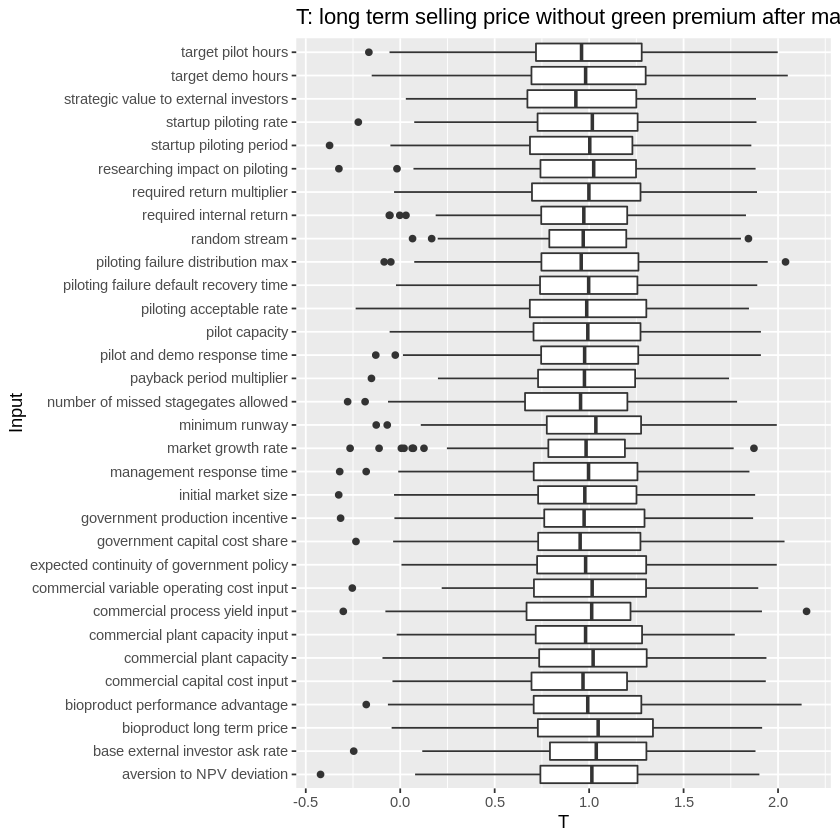

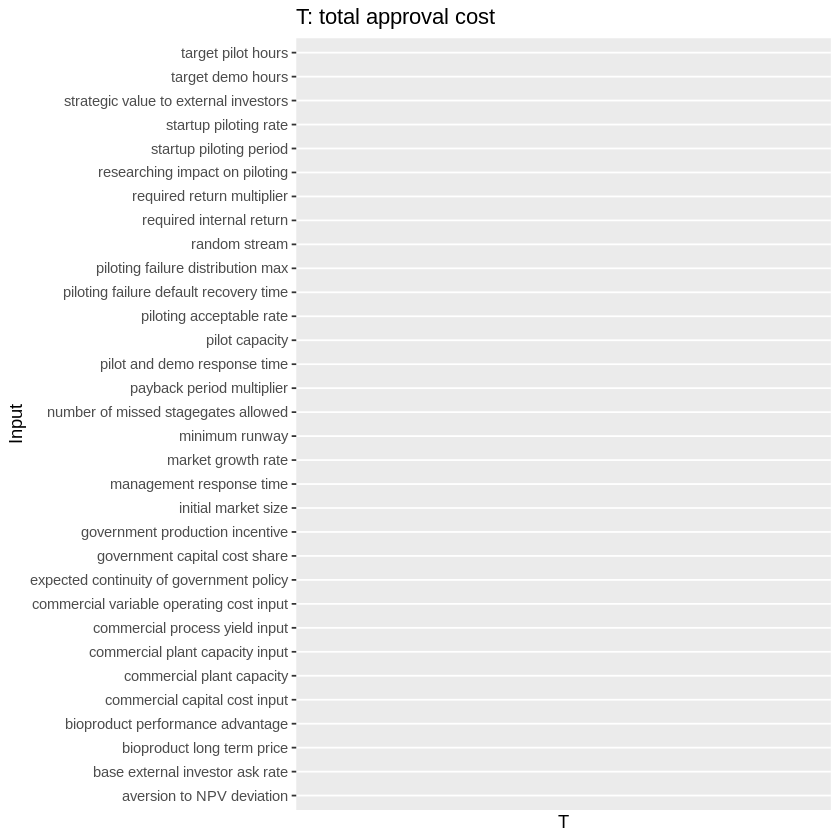

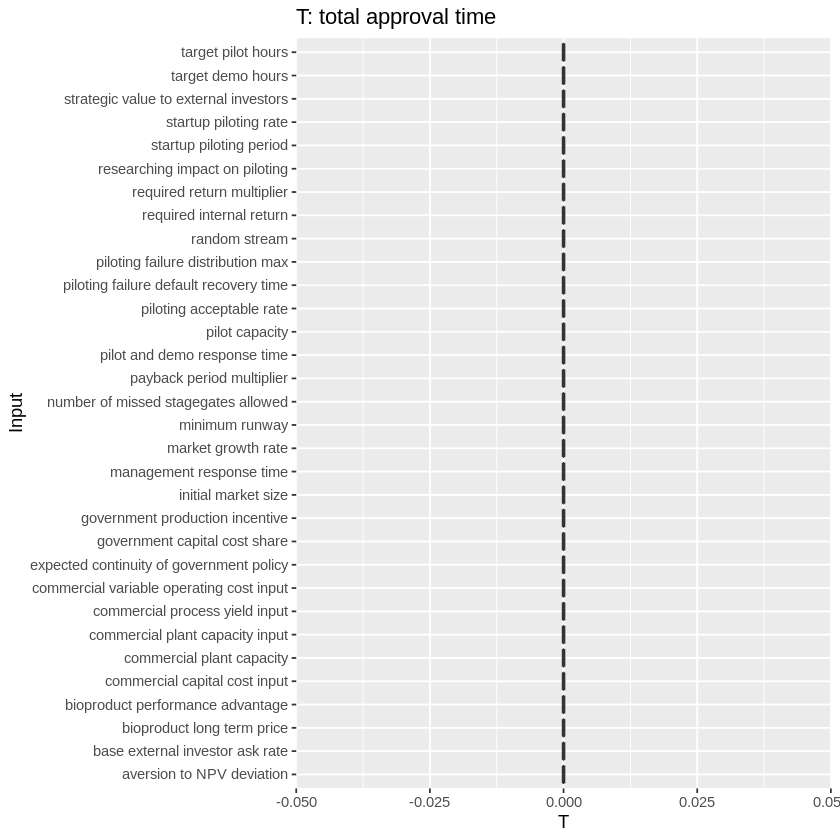

Warning message:
"Removed 3232 rows containing non-finite values (stat_boxplot)."

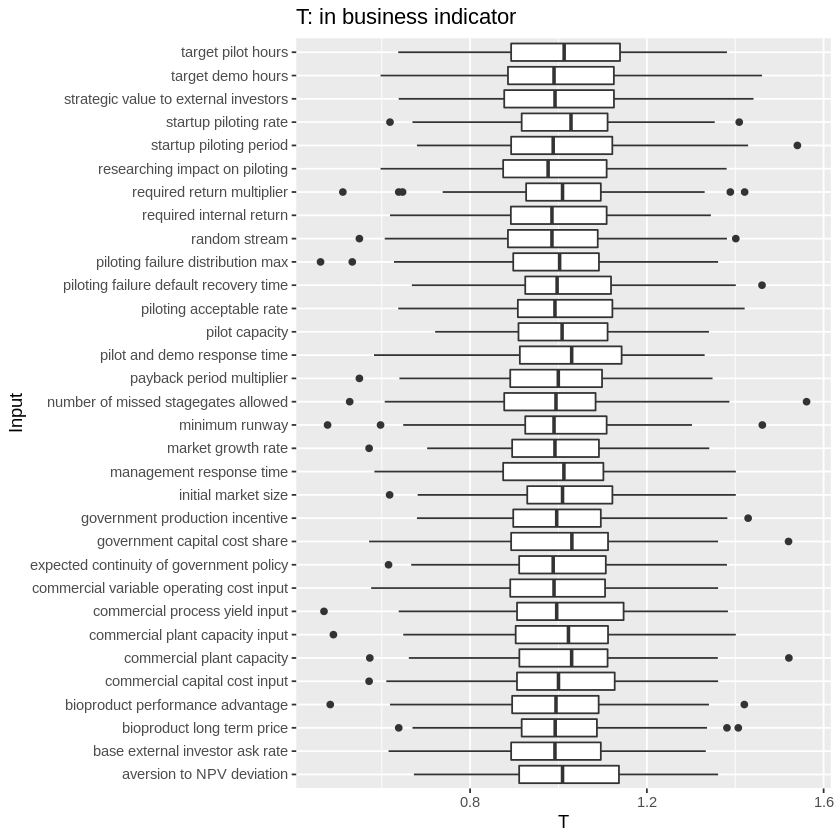

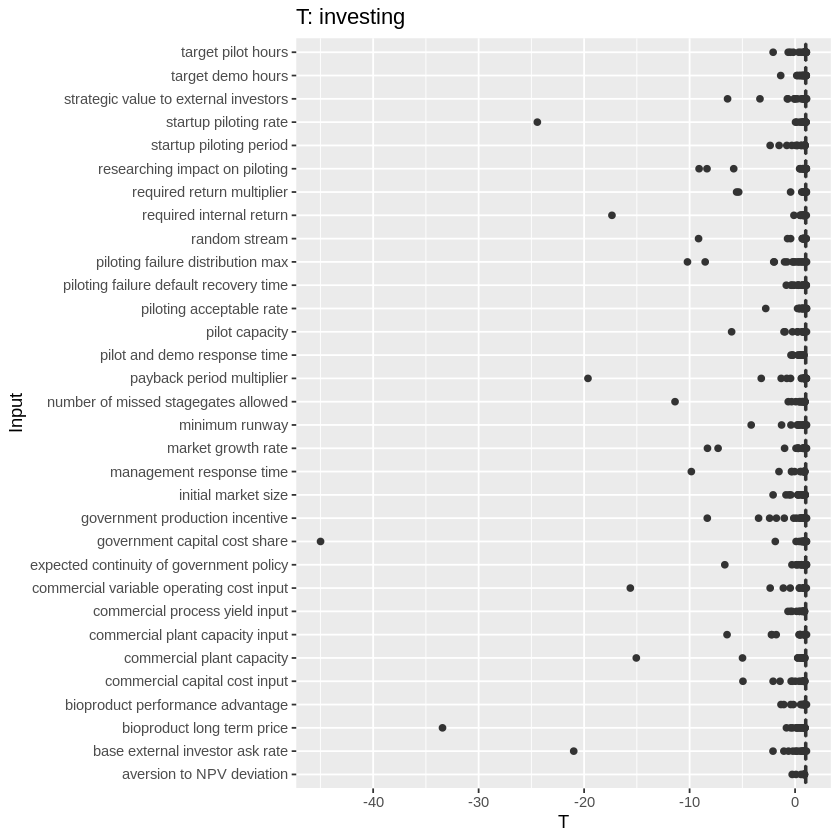

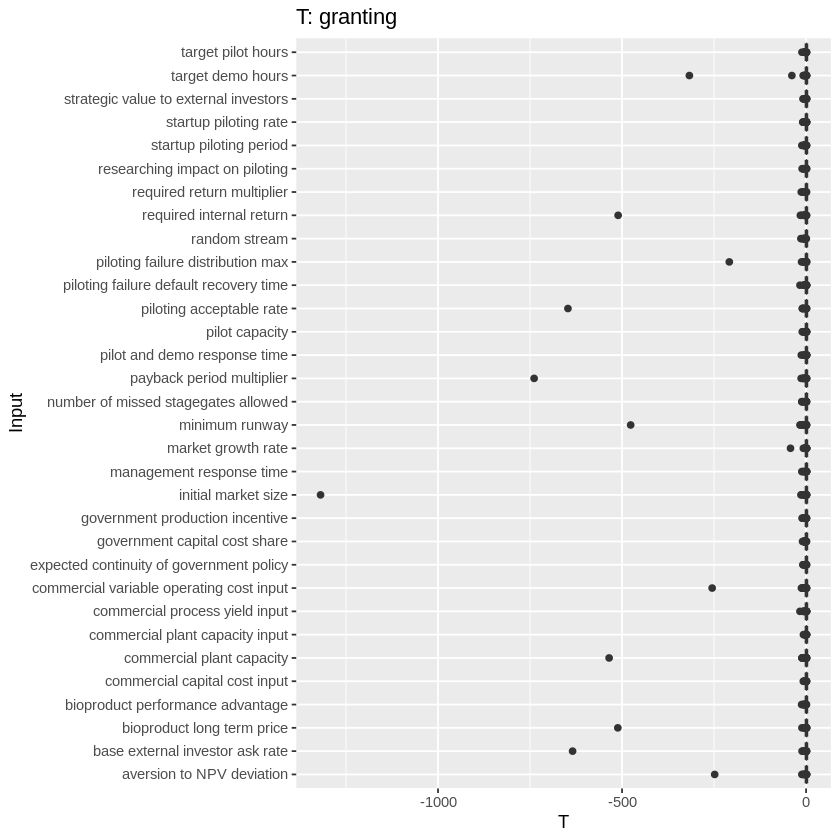

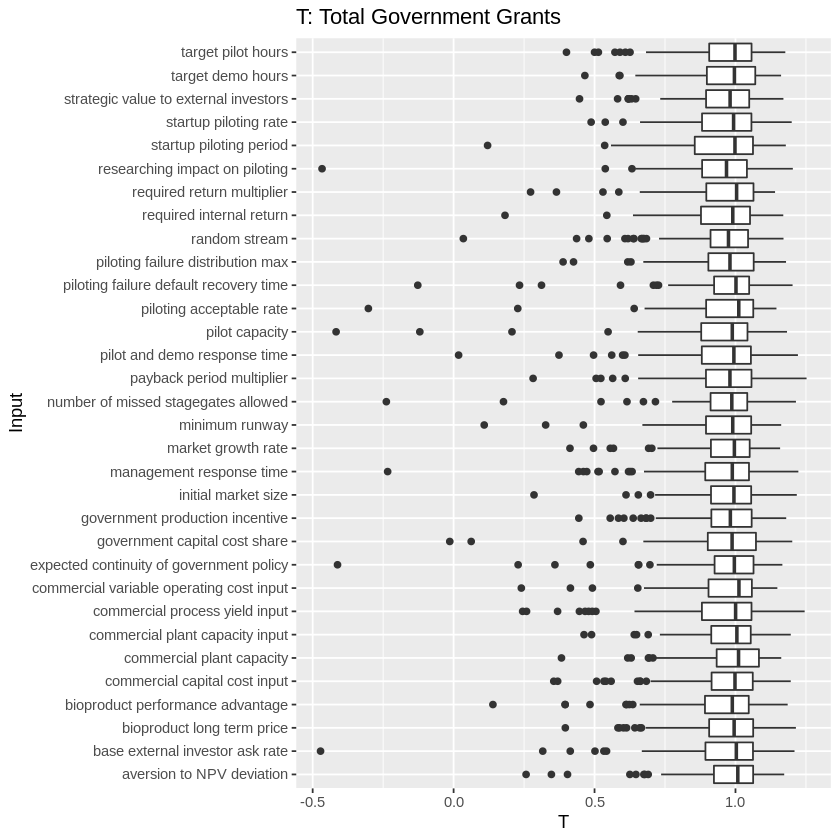

In [295]:
for (output in z.sens.boot[, unique(Output)]) {
    g <- ggplot(z.sens.boot[Output == output], aes(x=Input, y=T)) +
        geom_boxplot() +
        coord_flip() +
        ggtitle(paste("T:",output))
    print(g)
}

In [343]:
colnames(z.temp)

[1] "Run"                                                             
 [2] "Time"                                                            
 [3] "bioproduct_market_share_mass"                                    
 [4] "current_market_size_economic"                                    
 [5] "current_market_size_mass"                                        
 [6] "long_term_market_share"                                          
 [7] "long_term_market_value"                                          
 [8] "Adopters"                                                        
 [9] "NonAdopters"                                                     
[10] "Potential_Adopters"                                              
[11] "abandoning_bioproduct"                                           
[12] "Cumulative_Demoing_Production"                                   
[13] "Cumulative_Production"                                           
[14] "prepiloting"                                                     
[15] "pilot_plant_construction"                                        
[16] "pilot_plant_is_built"                                            
[17] "startup_piloting_complete"                                       
[18] "piloting_ongoing"                                                
[19] "piloting_progress"                                               
[20] "piloting_complete"                                               
[21] "predemoing"                                                      
[22] "demo_plant_construction"                                         
[23] "demo_plant_is_built"                                             
[24] "regulatory_process_ongoing"                                      
[25] "startup_demoing_completed"                                       
[26] "demoing_ongoing"                                                 
[27] "demoing_progress"                                                
[28] "demoing_complete"                                                
[29] "regulatory_delay"                                                
[30] "precommercial"                                                   
[31] "commercial_plant_construction"                                   
[32] "commercial_plant_is_built"                                       
[33] "commercial_plant_operation"                                      
[34] "technology_readiness_level"                                      
[35] "stage_in_progress"                                               
[36] "BS_equity"                                                       
[37] "payback_period"                                                  
[38] "NPV_at_required_return"                                          
[39] "profitability_indicator"                                         
[40] "bioproduct_favorability_indicator"                               
[41] "long_term_selling_price_without_green_premium_after_market_entry"
[42] "total_approval_cost"                                             
[43] "total_approval_time"                                             
[44] "in_business_indicator"                                           
[45] "internal_project_cancelled_indicator"                            
[46] "investing"                                                       
[47] "granting"                                                        
[48] "Total_Government_Grants"                                         
[49] "Total_Investment"                                                
[50] "Working_Capital"                                                 
[51] "IS_production_incentive"

In [345]:
z.inputs %>% head

Run aversion to NPV deviation base external investor ask rate
1 1   0.060                      2.4                           
2 2   1.360                     10.4                           
3 3   0.710                     14.4                           
4 4   2.010                      6.4                           
5 5   1.685                      4.4                           
6 6   0.385                     12.4                           
  bioproduct long term price bioproduct performance advantage
1 1500.500                   0.35000                         
2 5250.250                   3.07500                         
3 7125.125                   4.43750                         
4 3375.375                   1.71250                         
5 8062.562                   3.75625                         
6 4312.812                   1.03125                         
  commercial capital cost input commercial plant capacity
1  120374400                       8589.5                
2  720686400                    1265746.8                
3  420530400                     637168.1                
4 1020842400                    1894325.4                
5  870764400                    2208614.7                
6  270452400                     951457.4                
  commercial plant capacity input commercial process yield input
1    8589.5                       0.236                         
2 1265746.8                       0.676                         
3 1894325.4                       0.456                         
4  637168.1                       0.896                         
5  322878.8                       0.346                         
6 1580036.1                       0.786                         
  commercial variable operating cost input ...
1  365.7000                                ...
2 1170.4500                                ...
3  768.0750                                ...
4 1572.8250                                ...
5  566.8875                                ...
6 1371.6375                                ...
  piloting failure distribution max random stream required internal return
1 1.5000                             0            0.029000                
2 5.2500                            12            1.296500                
3 7.1250                            18            1.930250                
4 3.3750                             6            0.662750                
5 2.4375                            15            1.613375                
6 6.1875                             3            0.345875                
  required return multiplier researching impact on piloting
1 0.305000                   0.075                         
2 3.052500                   0.375                         
3 1.678750                   0.525                         
4 4.426250                   0.225                         
5 0.991875                   0.150                         
6 3.739375                   0.450                         
  startup piloting period startup piloting rate
1 150.00                   110.000             
2 525.00                  2326.500             
3 337.50                  3434.750             
4 712.50                  1218.250             
5 431.25                  1772.375             
6 806.25                  3988.875             
  strategic value to external investors target demo hours target pilot hours
1 2.710505e-11                          1550               950              
2 2.500000e+08                          7158              6058              
3 1.250000e+08                          9962              8612              
4 3.750000e+08                          4354              3504              
5 4.375000e+08                          2952              4781              
6 1.875000e+08                          8560              9889

In [347]:
z.outputs[[1]] %>% head

Run Time bioproduct market share mass current market size economic
1 1   2015 0.0715196                    261325000                   
2 1   2020 0.1481580                    279527000                   
3 1   2025 0.3900700                    231023000                   
4 1   2030 0.5636360                    200273000                   
5 1   2035 0.6875920                    178051000                   
6 1   2040 0.7761910                    167522000                   
  current market size mass long term market share long term market value
1 171571                   0                      0                     
2 184931                   0                      0                     
3 199331                   0                      0                     
4 214851                   0                      0                     
5 231581                   0                      0                     
6 249613                   0                      0                     
  Adopters NonAdopters Potential Adopters ... total approval cost
1  12270.7 159301.0      0.0000           ... 752251             
2  27399.0 157521.0     10.6530           ... 752251             
3  77753.0 121380.0    197.5930           ... 752251             
4 121098.0  93601.5    151.9470           ... 752251             
5 159233.0  72230.8    116.9500           ... 752251             
6 193747.0  55775.5     90.0889           ... 752251             
  total approval time in business indicator
1 6.019               0                    
2 6.019               1                    
3 6.019               1                    
4 6.019               0                    
5 6.019               1                    
6 6.019               1                    
  internal project cancelled indicator investing granting
1 0                                    9.6e+07   0       
2 0                                    0.0e+00   0       
3 0                                    0.0e+00   0       
4 0                                    0.0e+00   0       
5 0                                    0.0e+00   0       
6 0                                    0.0e+00   0       
  Total Government Grants Total Investment Working Capital
1 0                               0                0      
2 0                        46025200         34299000      
3 0                        46025200         14106600      
4 0                        46025200         -3220520      
5 0                       591836000        528581000      
6 0                       603767000        435541000      
  IS production incentive
1 0                      
2 0                      
3 0                      
4 0                      
5 0                      
6 0

In [348]:
?merge

In [349]:
merge(z.inputs, z.outputs[[1]][Time == 2050])

Run  aversion to NPV deviation base external investor ask rate
1     1   0.06000                    2.4                           
2     2   1.36000                   10.4                           
3     3   0.71000                   14.4                           
4     4   2.01000                    6.4                           
5     5   1.68500                    4.4                           
6     6   0.38500                   12.4                           
7     7   2.33500                   16.4                           
8     8   1.03500                    8.4                           
9     9   0.87250                    5.4                           
10   10   2.17250                   13.4                           
11   11   0.22250                   17.4                           
12   12   1.52250                    9.4                           
13   13   2.49750                    3.4                           
14   14   1.19750                   11.4                           
15   15   1.84750                   15.4                           
16   16   0.54750                    7.4                           
17   17   0.46625                    4.9                           
18   18   1.76625                   12.9                           
19   19   1.11625                   16.9                           
20   20   2.41625                    8.9                           
21   21   1.44125                    2.9                           
22   22   0.14125                   10.9                           
23   23   2.09125                   14.9                           
24   24   0.79125                    6.9                           
25   25   1.27875                    3.9                           
26   26   2.57875                   11.9                           
27   27   0.62875                   15.9                           
28   28   1.92875                    7.9                           
29   29   2.25375                    5.9                           
30   30   0.95375                   13.9                           
...  ...  ...                       ...                            
6771 6771 2.6498438                 13.3375                        
6772 6772 1.3498438                  5.3375                        
6773 6773 1.6748437                 15.3375                        
6774 6774 0.3748437                  7.3375                        
6775 6775 1.0248438                 11.3375                        
6776 6776 2.3248437                  3.3375                        
6777 6777 2.0810937                 16.8375                        
6778 6778 0.7810938                  8.8375                        
6779 6779 0.1310938                 12.8375                        
6780 6780 1.4310938                  4.8375                        
6781 6781 1.1060938                 14.8375                        
6782 6782 2.4060938                  6.8375                        
6783 6783 1.7560938                 10.8375                        
6784 6784 0.4560938                  2.8375                        
6785 6785 0.6185938                 17.8375                        
6786 6786 1.9185938                  9.8375                        
6787 6787 2.5685937                 13.8375                        
6788 6788 1.2685937                  5.8375                        
6789 6789 1.5935937                 15.8375                        
6790 6790 0.2935937                  7.8375                        
6791 6791 0.9435938                 11.8375                        
6792 6792 2.2435938                  3.8375                        
6793 6793 1.4514063                 10.9625                        
6794 6794 0.1514062                  2.9625                        
6795 6795 0.8014062                 14.9625                        
6796 6796 2.1014063                  6.9625                        
6797 6797 0.4764062                 12.9625                  

n= 6800 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 6800 327.496300 0.050735290  
   2) target_pilot_hours>=2007.516 6086 125.307900 0.021031880  
     4) expected_continuity_of_government_policy>=0.3058594 6054  99.315000 0.016683180  
       8) startup_piloting_rate>=135.9746 6022  76.989700 0.012952510  
        16) piloting_acceptable_rate>=2884.225 5646  31.818630 0.005667729 *
        17) piloting_acceptable_rate< 2884.225 376  40.372340 0.122340400  
          34) commercial_plant_capacity>=278681.9 310   1.987097 0.006451613 *
          35) commercial_plant_capacity< 278681.9 66  14.666670 0.666666700 *
       9) startup_piloting_rate< 135.9746 32   6.468750 0.718750000 *
     5) expected_continuity_of_government_policy< 0.3058594 32   4.218750 0.843750000 *
   3) target_pilot_hours< 2007.516 714 151.049000 0.303921600  
     6) researching_impact_on_piloting< 0.5753906 583  83.502570 0.173241900  
      12) required_return_multiplier< 4.748223 512


Regression tree:
rpart(formula = commercial_plant_operation ~ aversion_to_NPV_deviation + 
    base_external_investor_ask_rate + bioproduct_long_term_price + 
    bioproduct_performance_advantage + commercial_capital_cost_input + 
    commercial_plant_capacity + commercial_plant_capacity_input + 
    commercial_process_yield_input + commercial_variable_operating_cost_input + 
    expected_continuity_of_government_policy + government_capital_cost_share + 
    government_production_incentive + initial_market_size + management_response_time + 
    market_growth_rate + minimum_runway + number_of_missed_stagegates_allowed + 
    payback_period_multiplier + pilot_and_demo_response_time + 
    pilot_capacity + piloting_acceptable_rate + piloting_failure_default_recovery_time + 
    piloting_failure_distribution_max + random_stream + required_internal_return + 
    required_return_multiplier + researching_impact_on_piloting + 
    startup_piloting_period + startup_piloting_rate + strategic_va

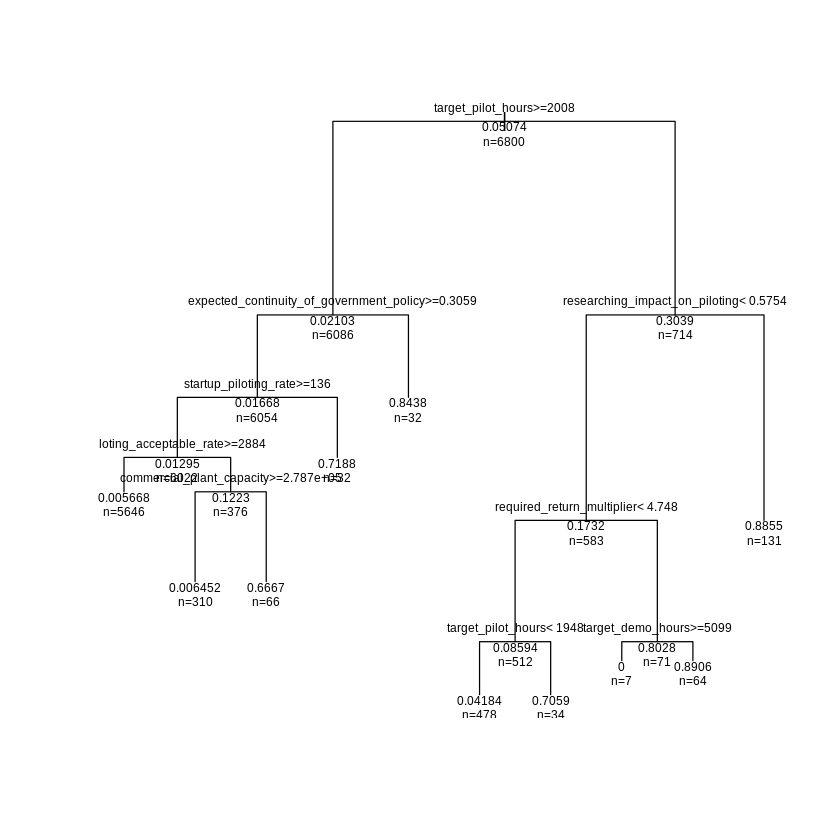

In [369]:
z.temp <- merge(z.inputs, z.outputs[Replacement == "Direct" & Scale == "Niche" & Time == 2050])
colnames(z.temp) <- gsub(" ", "_", colnames(z.temp))
z.tree <- rpart(
    `commercial_plant_operation` ~
    `aversion_to_NPV_deviation` +
    `base_external_investor_ask_rate` +
    `bioproduct_long_term_price` +
    `bioproduct_performance_advantage` +
    `commercial_capital_cost_input` +
    `commercial_plant_capacity` +
    `commercial_plant_capacity_input` +
    `commercial_process_yield_input` +
    `commercial_variable_operating_cost_input` +
    `expected_continuity_of_government_policy` +
    `government_capital_cost_share` +
    `government_production_incentive` +
    `initial_market_size` +
    `management_response_time` +
    `market_growth_rate` +
    `minimum_runway` +
    `number_of_missed_stagegates_allowed` +
    `payback_period_multiplier` +
    `pilot_and_demo_response_time` +
    `pilot_capacity` +
    `piloting_acceptable_rate` +
    `piloting_failure_default_recovery_time` +
    `piloting_failure_distribution_max` +
    `random_stream` +
    `required_internal_return` +
    `required_return_multiplier` +
    `researching_impact_on_piloting` +
    `startup_piloting_period` +
    `startup_piloting_rate` +
    `strategic_value_to_external_investors` +
    `target_demo_hours` +
    `target_pilot_hours`,
    z.temp
)
z.tree
printcp(z.tree)
plot(z.tree)
text(z.tree, use.n=TRUE, all=TRUE, cex=.6)

n= 6800 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 6800 318.496300 0.049264710  
   2) required_internal_return< 2.539244 6734 272.938100 0.042322540  
     4) target_pilot_hours>=1947.656 6086 133.916000 0.022510680  
       8) base_external_investor_ask_rate>=3.80625 5606  82.741350 0.014983950  
        16) piloting_acceptable_rate>=2884.225 5267  49.525350 0.009493070  
          32) target_pilot_hours< 10886.66 5098  32.786390 0.006473127 *
          33) target_pilot_hours>=10886.66 169  15.289940 0.100591700  
            66) random_stream< 22 138   0.000000 0.000000000 *
            67) random_stream>=22 31   7.677419 0.548387100 *
        17) piloting_acceptable_rate< 2884.225 339  30.589970 0.100295000  
          34) initial_market_size< 4.487602e+07 306   6.839869 0.022875820 *
          35) initial_market_size>=4.487602e+07 33   4.909091 0.818181800 *
       9) base_external_investor_ask_rate< 3.80625 480  47.147920 0.110416700  
        18) r


Regression tree:
rpart(formula = commercial_plant_operation ~ aversion_to_NPV_deviation + 
    base_external_investor_ask_rate + bioproduct_long_term_price + 
    bioproduct_performance_advantage + commercial_capital_cost_input + 
    commercial_plant_capacity + commercial_plant_capacity_input + 
    commercial_process_yield_input + commercial_variable_operating_cost_input + 
    expected_continuity_of_government_policy + government_capital_cost_share + 
    government_production_incentive + initial_market_size + management_response_time + 
    market_growth_rate + minimum_runway + number_of_missed_stagegates_allowed + 
    payback_period_multiplier + pilot_and_demo_response_time + 
    pilot_capacity + piloting_acceptable_rate + piloting_failure_default_recovery_time + 
    piloting_failure_distribution_max + random_stream + required_internal_return + 
    required_return_multiplier + researching_impact_on_piloting + 
    startup_piloting_period + startup_piloting_rate + strategic_va

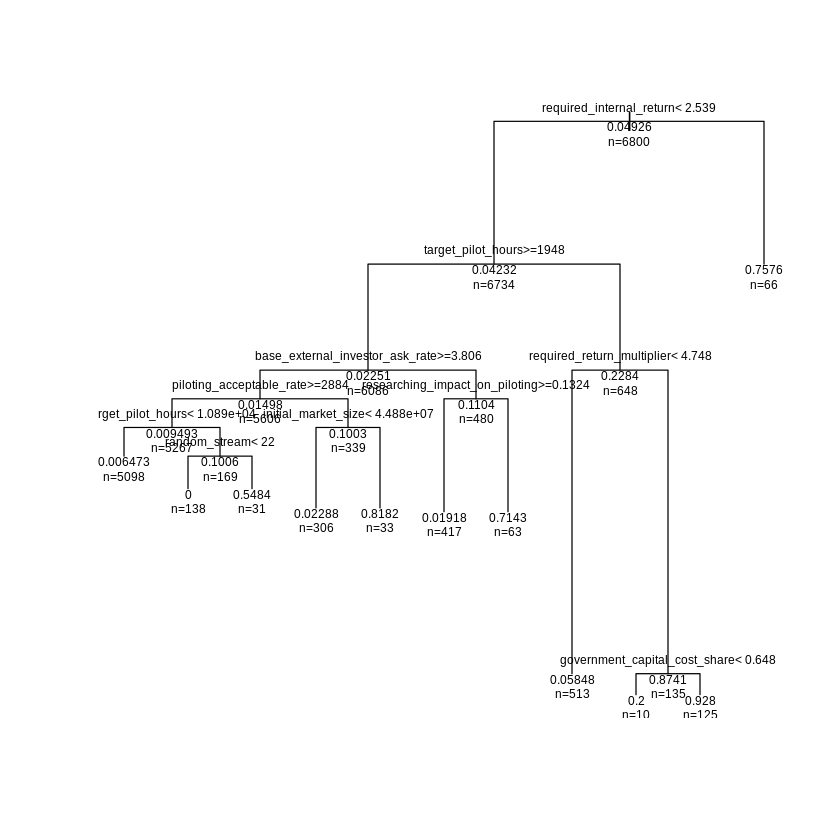

In [375]:
z.temp <- merge(z.inputs, z.outputs[Replacement == "Direct" & Scale == "Commodity" & Time == 2050])
colnames(z.temp) <- gsub(" ", "_", colnames(z.temp))
z.tree <- rpart(
    `commercial_plant_operation` ~
    `aversion_to_NPV_deviation` +
    `base_external_investor_ask_rate` +
    `bioproduct_long_term_price` +
    `bioproduct_performance_advantage` +
    `commercial_capital_cost_input` +
    `commercial_plant_capacity` +
    `commercial_plant_capacity_input` +
    `commercial_process_yield_input` +
    `commercial_variable_operating_cost_input` +
    `expected_continuity_of_government_policy` +
    `government_capital_cost_share` +
    `government_production_incentive` +
    `initial_market_size` +
    `management_response_time` +
    `market_growth_rate` +
    `minimum_runway` +
    `number_of_missed_stagegates_allowed` +
    `payback_period_multiplier` +
    `pilot_and_demo_response_time` +
    `pilot_capacity` +
    `piloting_acceptable_rate` +
    `piloting_failure_default_recovery_time` +
    `piloting_failure_distribution_max` +
    `random_stream` +
    `required_internal_return` +
    `required_return_multiplier` +
    `researching_impact_on_piloting` +
    `startup_piloting_period` +
    `startup_piloting_rate` +
    `strategic_value_to_external_investors` +
    `target_demo_hours` +
    `target_pilot_hours`,
    z.temp
)
z.tree
printcp(z.tree)
plot(z.tree)
text(z.tree, use.n=TRUE, all=TRUE, cex=.6)

n= 6800 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 6800 327.496300 0.050735290  
   2) target_pilot_hours>=2007.516 6086 125.307900 0.021031880  
     4) expected_continuity_of_government_policy>=0.3058594 6054  99.315000 0.016683180  
       8) startup_piloting_rate>=135.9746 6022  76.989700 0.012952510  
        16) piloting_acceptable_rate>=2884.225 5646  31.818630 0.005667729 *
        17) piloting_acceptable_rate< 2884.225 376  40.372340 0.122340400  
          34) commercial_plant_capacity>=278681.9 310   1.987097 0.006451613 *
          35) commercial_plant_capacity< 278681.9 66  14.666670 0.666666700 *
       9) startup_piloting_rate< 135.9746 32   6.468750 0.718750000 *
     5) expected_continuity_of_government_policy< 0.3058594 32   4.218750 0.843750000 *
   3) target_pilot_hours< 2007.516 714 151.049000 0.303921600  
     6) researching_impact_on_piloting< 0.5753906 583  83.502570 0.173241900  
      12) required_return_multiplier< 4.748223 512


Regression tree:
rpart(formula = commercial_plant_operation ~ aversion_to_NPV_deviation + 
    base_external_investor_ask_rate + bioproduct_long_term_price + 
    bioproduct_performance_advantage + commercial_capital_cost_input + 
    commercial_plant_capacity + commercial_plant_capacity_input + 
    commercial_process_yield_input + commercial_variable_operating_cost_input + 
    expected_continuity_of_government_policy + government_capital_cost_share + 
    government_production_incentive + initial_market_size + management_response_time + 
    market_growth_rate + minimum_runway + number_of_missed_stagegates_allowed + 
    payback_period_multiplier + pilot_and_demo_response_time + 
    pilot_capacity + piloting_acceptable_rate + piloting_failure_default_recovery_time + 
    piloting_failure_distribution_max + random_stream + required_internal_return + 
    required_return_multiplier + researching_impact_on_piloting + 
    startup_piloting_period + startup_piloting_rate + strategic_va

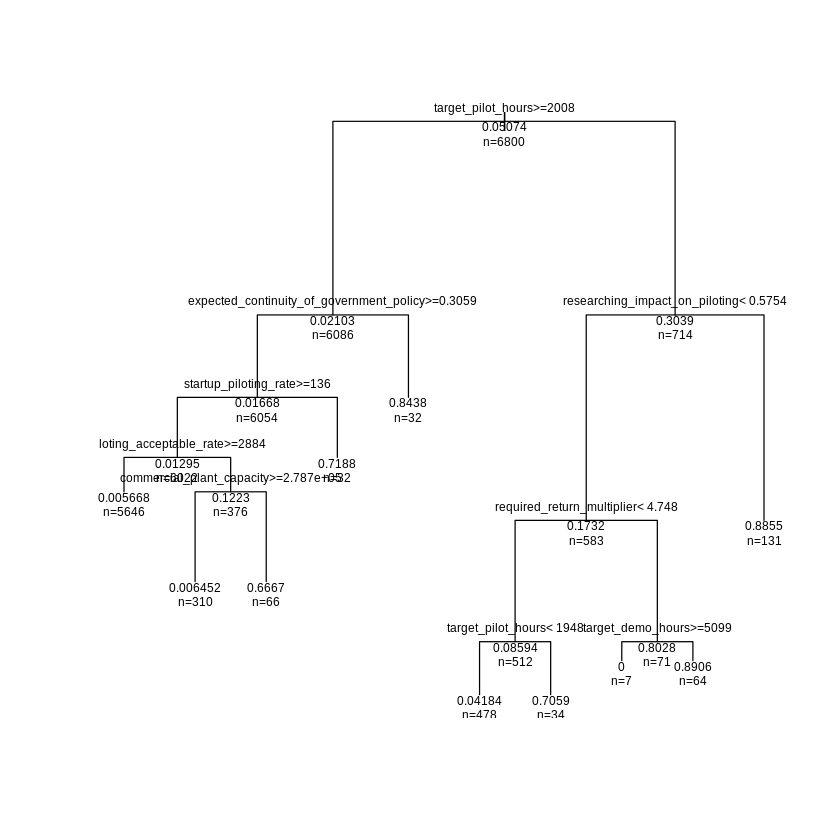

In [376]:
z.temp <- merge(z.inputs, z.outputs[Replacement == "Advantaged" & Scale == "Niche" & Time == 2050])
colnames(z.temp) <- gsub(" ", "_", colnames(z.temp))
z.tree <- rpart(
    `commercial_plant_operation` ~
    `aversion_to_NPV_deviation` +
    `base_external_investor_ask_rate` +
    `bioproduct_long_term_price` +
    `bioproduct_performance_advantage` +
    `commercial_capital_cost_input` +
    `commercial_plant_capacity` +
    `commercial_plant_capacity_input` +
    `commercial_process_yield_input` +
    `commercial_variable_operating_cost_input` +
    `expected_continuity_of_government_policy` +
    `government_capital_cost_share` +
    `government_production_incentive` +
    `initial_market_size` +
    `management_response_time` +
    `market_growth_rate` +
    `minimum_runway` +
    `number_of_missed_stagegates_allowed` +
    `payback_period_multiplier` +
    `pilot_and_demo_response_time` +
    `pilot_capacity` +
    `piloting_acceptable_rate` +
    `piloting_failure_default_recovery_time` +
    `piloting_failure_distribution_max` +
    `random_stream` +
    `required_internal_return` +
    `required_return_multiplier` +
    `researching_impact_on_piloting` +
    `startup_piloting_period` +
    `startup_piloting_rate` +
    `strategic_value_to_external_investors` +
    `target_demo_hours` +
    `target_pilot_hours`,
    z.temp
)
z.tree
printcp(z.tree)
plot(z.tree)
text(z.tree, use.n=TRUE, all=TRUE, cex=.6)

n= 6800 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 6800 327.496300 0.050735290  
   2) target_pilot_hours>=2007.516 6086 125.307900 0.021031880  
     4) expected_continuity_of_government_policy>=0.3058594 6054  99.315000 0.016683180  
       8) startup_piloting_rate>=135.9746 6022  76.989700 0.012952510  
        16) piloting_acceptable_rate>=2884.225 5646  31.818630 0.005667729 *
        17) piloting_acceptable_rate< 2884.225 376  40.372340 0.122340400  
          34) commercial_plant_capacity>=278681.9 310   1.987097 0.006451613 *
          35) commercial_plant_capacity< 278681.9 66  14.666670 0.666666700 *
       9) startup_piloting_rate< 135.9746 32   6.468750 0.718750000 *
     5) expected_continuity_of_government_policy< 0.3058594 32   4.218750 0.843750000 *
   3) target_pilot_hours< 2007.516 714 151.049000 0.303921600  
     6) researching_impact_on_piloting< 0.5753906 583  83.502570 0.173241900  
      12) required_return_multiplier< 4.748223 512


Regression tree:
rpart(formula = commercial_plant_operation ~ aversion_to_NPV_deviation + 
    base_external_investor_ask_rate + bioproduct_long_term_price + 
    bioproduct_performance_advantage + commercial_capital_cost_input + 
    commercial_plant_capacity + commercial_plant_capacity_input + 
    commercial_process_yield_input + commercial_variable_operating_cost_input + 
    expected_continuity_of_government_policy + government_capital_cost_share + 
    government_production_incentive + initial_market_size + management_response_time + 
    market_growth_rate + minimum_runway + number_of_missed_stagegates_allowed + 
    payback_period_multiplier + pilot_and_demo_response_time + 
    pilot_capacity + piloting_acceptable_rate + piloting_failure_default_recovery_time + 
    piloting_failure_distribution_max + random_stream + required_internal_return + 
    required_return_multiplier + researching_impact_on_piloting + 
    startup_piloting_period + startup_piloting_rate + strategic_va

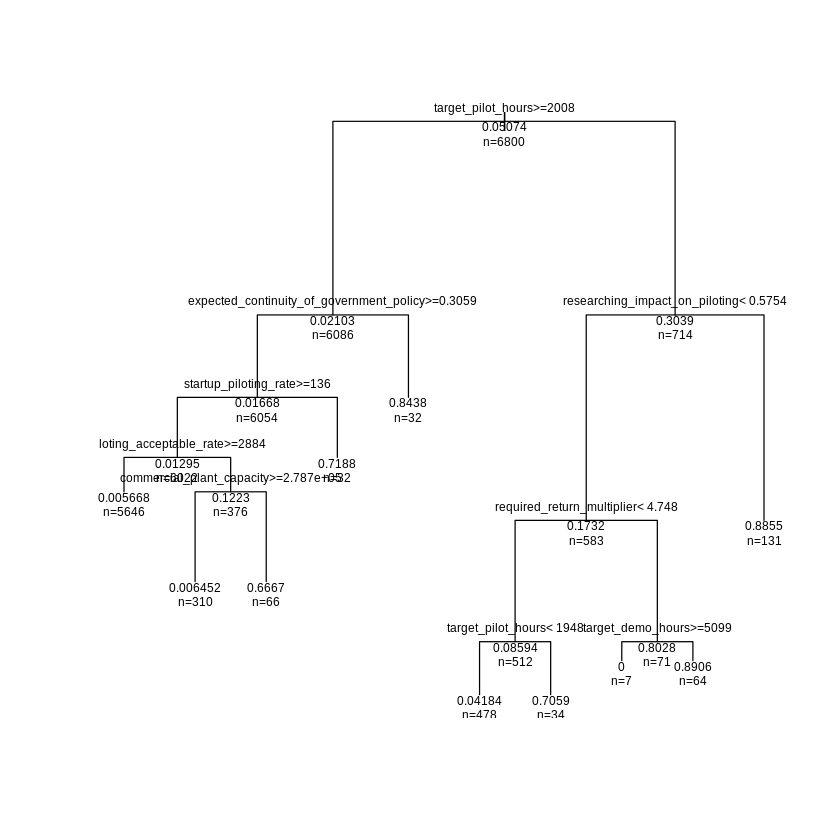

In [377]:
z.temp <- merge(z.inputs, z.outputs[Replacement == "Advantaged" & Scale == "Commodity" & Time == 2050])
colnames(z.temp) <- gsub(" ", "_", colnames(z.temp))
z.tree <- rpart(
    `commercial_plant_operation` ~
    `aversion_to_NPV_deviation` +
    `base_external_investor_ask_rate` +
    `bioproduct_long_term_price` +
    `bioproduct_performance_advantage` +
    `commercial_capital_cost_input` +
    `commercial_plant_capacity` +
    `commercial_plant_capacity_input` +
    `commercial_process_yield_input` +
    `commercial_variable_operating_cost_input` +
    `expected_continuity_of_government_policy` +
    `government_capital_cost_share` +
    `government_production_incentive` +
    `initial_market_size` +
    `management_response_time` +
    `market_growth_rate` +
    `minimum_runway` +
    `number_of_missed_stagegates_allowed` +
    `payback_period_multiplier` +
    `pilot_and_demo_response_time` +
    `pilot_capacity` +
    `piloting_acceptable_rate` +
    `piloting_failure_default_recovery_time` +
    `piloting_failure_distribution_max` +
    `random_stream` +
    `required_internal_return` +
    `required_return_multiplier` +
    `researching_impact_on_piloting` +
    `startup_piloting_period` +
    `startup_piloting_rate` +
    `strategic_value_to_external_investors` +
    `target_demo_hours` +
    `target_pilot_hours`,
    z.temp
)
z.tree
printcp(z.tree)
plot(z.tree)
text(z.tree, use.n=TRUE, all=TRUE, cex=.6)

n= 27200 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 27200 1300.996000 0.050367650  
   2) target_pilot_hours>=2007.516 24344  530.888200 0.022305290  
     4) startup_piloting_rate>=135.9746 24216  442.600600 0.018624050  
       8) expected_continuity_of_government_policy>=0.3058594 24088  364.316700 0.015360350  
        16) piloting_acceptable_rate>=2884.225 22584  196.264100 0.008767269 *
        17) piloting_acceptable_rate< 2884.225 1504  152.329800 0.114361700  
          34) commercial_plant_capacity>=278681.9 1240   11.883870 0.009677419 *
          35) commercial_plant_capacity< 278681.9 264   63.030300 0.606060600 *
       9) expected_continuity_of_government_policy< 0.3058594 128   29.742190 0.632812500 *
     5) startup_piloting_rate< 135.9746 128   25.875000 0.718750000 *
   3) target_pilot_hours< 2007.516 2856  587.529100 0.289565800  
     6) required_return_multiplier< 4.748223 2316  304.730100 0.155872200  
      12) researching_impact_o


Regression tree:
rpart(formula = commercial_plant_operation ~ Replacement + Scale + 
    aversion_to_NPV_deviation + base_external_investor_ask_rate + 
    bioproduct_long_term_price + bioproduct_performance_advantage + 
    commercial_capital_cost_input + commercial_plant_capacity + 
    commercial_plant_capacity_input + commercial_process_yield_input + 
    commercial_variable_operating_cost_input + expected_continuity_of_government_policy + 
    government_capital_cost_share + government_production_incentive + 
    initial_market_size + management_response_time + market_growth_rate + 
    minimum_runway + number_of_missed_stagegates_allowed + payback_period_multiplier + 
    pilot_and_demo_response_time + pilot_capacity + piloting_acceptable_rate + 
    piloting_failure_default_recovery_time + piloting_failure_distribution_max + 
    random_stream + required_internal_return + required_return_multiplier + 
    researching_impact_on_piloting + startup_piloting_period + 
    startup_p

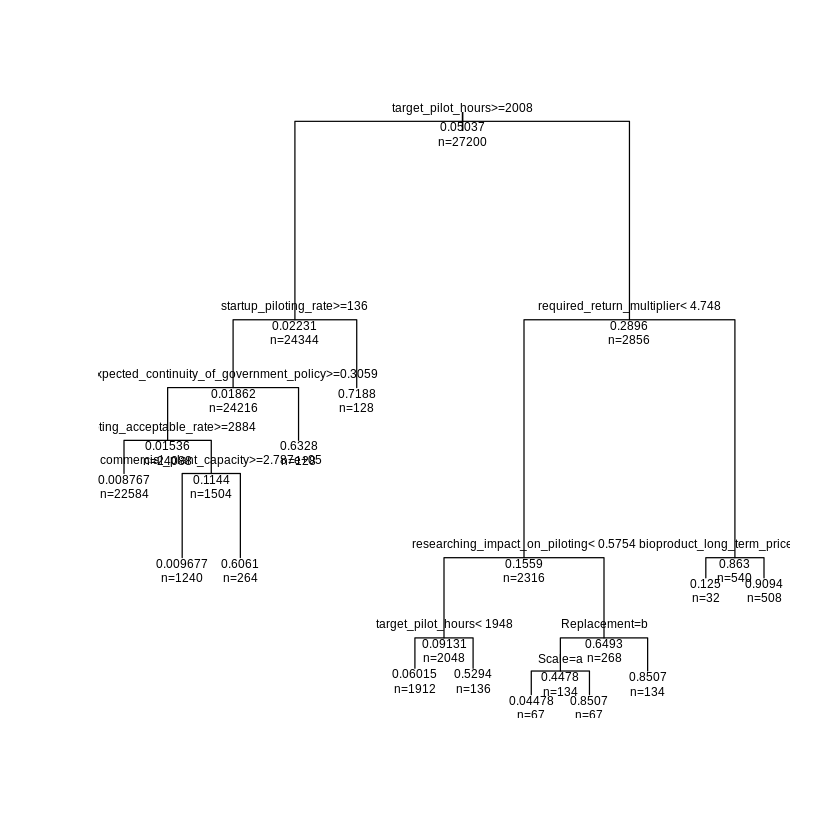

In [378]:
z.temp <- merge(z.inputs, z.outputs[Time == 2050])
colnames(z.temp) <- gsub(" ", "_", colnames(z.temp))
z.tree <- rpart(
    `commercial_plant_operation` ~
    `Replacement` +
    `Scale` +
    `aversion_to_NPV_deviation` +
    `base_external_investor_ask_rate` +
    `bioproduct_long_term_price` +
    `bioproduct_performance_advantage` +
    `commercial_capital_cost_input` +
    `commercial_plant_capacity` +
    `commercial_plant_capacity_input` +
    `commercial_process_yield_input` +
    `commercial_variable_operating_cost_input` +
    `expected_continuity_of_government_policy` +
    `government_capital_cost_share` +
    `government_production_incentive` +
    `initial_market_size` +
    `management_response_time` +
    `market_growth_rate` +
    `minimum_runway` +
    `number_of_missed_stagegates_allowed` +
    `payback_period_multiplier` +
    `pilot_and_demo_response_time` +
    `pilot_capacity` +
    `piloting_acceptable_rate` +
    `piloting_failure_default_recovery_time` +
    `piloting_failure_distribution_max` +
    `random_stream` +
    `required_internal_return` +
    `required_return_multiplier` +
    `researching_impact_on_piloting` +
    `startup_piloting_period` +
    `startup_piloting_rate` +
    `strategic_value_to_external_investors` +
    `target_demo_hours` +
    `target_pilot_hours`,
    z.temp
)
z.tree
printcp(z.tree)
plot(z.tree)
text(z.tree, use.n=TRUE, all=TRUE, cex=.6)